<!-- # Knowledge Graph Discovery from Verizon Website

This notebook demonstrates how to use the `kg_discovery` framework to extract information from Verizon's website and build a knowledge graph. We'll walk through the process of:

1. Setting up the environment
2. Configuring the system
3. Ingesting data from Verizon's website
4. Extracting structured information (triples)
5. Building a knowledge graph
6. Visualizing the results

The framework uses a multi-agent approach to handle different aspects of the knowledge graph construction process. -->

<!-- ## 1. Import Libraries

Now that our environment is set up, let's import the necessary libraries and packages required for knowledge graph discovery: -->

<!-- ## 0. Environment Setup

Before we begin, let's set up our conda environment and install all required dependencies. Run the following commands in your terminal:

```bash
# Create and activate a conda environment for this project
conda create -n rag_env python=3.10
conda activate rag_env

# Install uv if not already installed
pip install uv

# Install dependencies using uv pip from requirements.txt
uv pip install -r requirements.txt

# Or install all dependencies directly with uv pip
uv pip install networkx matplotlib numpy pandas spacy transformers neo4j selenium beautifulsoup4 trafilatura langchain python-dotenv pdfminer.six sentence-transformers seaborn scikit-learn nltk tqdm requests lxml
```

You'll also need to download spaCy language models:

```bash
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_md
```

Let's check if all required packages are installed: -->

In [1]:
# Check if all required packages are installed
import pkg_resources
import importlib.util

required_packages = [
    'networkx', 'matplotlib', 'numpy', 'pandas', 'spacy', 'transformers', 
    'neo4j', 'selenium', 'bs4', 'trafilatura', 'langchain', 'dotenv', 
    'pdfminer', 'sentence_transformers', 'seaborn', 'sklearn', 'nltk', 
    'tqdm', 'requests', 'lxml'
]

missing_packages = []
for package in required_packages:
    try:
        pkg_resources.get_distribution(package)
        print(f"✅ {package} is installed")
    except pkg_resources.DistributionNotFound:
        try:
            # Some packages use different import names than their pip names
            if package == 'bs4':
                importlib.util.find_spec('beautifulsoup4')
            elif package == 'dotenv':
                importlib.util.find_spec('python-dotenv')
            elif package == 'pdfminer':
                importlib.util.find_spec('pdfminer.six')
            elif package == 'sklearn':
                importlib.util.find_spec('scikit-learn')
            else:
                importlib.util.find_spec(package)
            print(f"✅ {package} is installed")
        except ImportError:
            missing_packages.append(package)
            print(f"❌ {package} is NOT installed")

if missing_packages:
    print(f"\n⚠️ Missing packages: {', '.join(missing_packages)}")
    print("Please run the following command to install missing packages:")
    print(f"uv pip install {' '.join(missing_packages)}")
else:
    print("\n✅ All required packages are installed!")

C:\Users\shada\AppData\Local\Temp\ipykernel_39672\2396463748.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ networkx is installed
✅ matplotlib is installed
✅ numpy is installed
✅ pandas is installed
✅ spacy is installed
✅ transformers is installed
✅ neo4j is installed
✅ selenium is installed
✅ bs4 is installed
✅ trafilatura is installed
✅ langchain is installed
✅ dotenv is installed
✅ pdfminer is installed
✅ sentence_transformers is installed
✅ seaborn is installed
✅ sklearn is installed
✅ nltk is installed
✅ tqdm is installed
✅ requests is installed
✅ lxml is installed

✅ All required packages are installed!
✅ pdfminer is installed
✅ sentence_transformers is installed
✅ seaborn is installed
✅ sklearn is installed
✅ nltk is installed
✅ tqdm is installed
✅ requests is installed
✅ lxml is installed

✅ All required packages are installed!


In [2]:
# %pip install PyMuPDF

import os
import sys
import logging
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import fitz  # PyMuPDF

# Add the project directory to the Python path if necessary
project_dir = Path.cwd()
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))
    
# Import the kg_discovery modules
from kg_discovery.agents.data_ingestion import DataIngestionAgent
from kg_discovery.agents.information_extraction import InformationExtractionAgent
from kg_discovery.agents.schema_discovery import SchemaDiscoveryAgent
from kg_discovery.agents.graph_construction import GraphConstructionAgent
from kg_discovery.agents.graph_enrichment import GraphEnrichmentAgent

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
    ]
)

# Silence other loggers
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("selenium").setLevel(logging.WARNING)
logging.getLogger("trafilatura").setLevel(logging.WARNING)

print("Environment set up successfully!")

ImportError: attempted relative import with no known parent package

<!-- ## 2. Define Configuration Settings

Now, let's configure the settings for our knowledge graph discovery process. These settings determine how the system will behave when crawling websites, processing documents, and building the knowledge graph. -->

In [3]:
# Target URLs for knowledge graph discovery
target_url = "https://www.verizon.com/about"
max_crawling_depth = 2

# Update configuration settings if necessary
from kg_discovery.config import SELENIUM_DRIVER_PATH

# Set the path to Edge WebDriver (update with your actual path)
edge_driver_path = r"E:/Programms(installed)/EdgeWebDriver/msedgedriver.exe"  # Update with your actual Edge driver path

# If you have the Edge WebDriver installed and want to use it, uncomment the line below
# SELENIUM_DRIVER_PATH = edge_driver_path

# Define output paths
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

networkx_output = output_dir / "verizon_knowledge_graph.gpickle"
visualization_output = output_dir / "verizon_knowledge_graph.png"

# Neo4j settings (if using Neo4j)
use_neo4j = False  # Set to True if you want to use Neo4j instead of NetworkX

print("Configuration settings defined!")

Configuration settings defined!


<!-- ## 3. Data Ingestion

The first step in the knowledge graph discovery process is to ingest data from the target website. The `DataIngestionAgent` is responsible for fetching web content, following links up to a specified depth, and processing any PDF documents found on the website. -->

<!-- ### 3.1 Analyzing Robots.txt Rules

Before we start crawling the Verizon website, we need to analyze the robots.txt file to understand which parts of the site we can access and which are off-limits. This ensures our web scraping is ethical and complies with the site owner's wishes. -->

In [4]:
# Analyze the Verizon robots.txt file using the RobotsAnalyzer tool
from kg_discovery.tools.robots_analyzer import RobotsAnalyzer

# Create robots analyzer
robots_analyzer = RobotsAnalyzer()

# Local path for robots.txt file
robots_txt_path = Path("Website Downloads/Verizon/verizon_robots.txt")

# Analyze robots.txt
analysis = robots_analyzer.analyze(target_url, str(robots_txt_path))
allowed = analysis['allowed']
disallowed = analysis['disallowed']
sitemaps = analysis['sitemaps']

# Analyze the sections we can crawl
allowed_sections = ['/about', '/investors', '/our-company', '/terms-conditions', 
                    '/responsibility', '/privacy', '/parenting', '/consumer-safety', '/international']

# Check if these sections are explicitly allowed or disallowed
section_status = {}
for section in allowed_sections:
    # Check if section is explicitly disallowed
    if any(section.startswith(d) for d in disallowed if d):
        section_status[section] = "Disallowed"
    # Check if section is explicitly allowed
    elif any(section.startswith(a) for a in allowed if a):
        section_status[section] = "Explicitly allowed"
    else:
        section_status[section] = "Not explicitly disallowed (assumed allowed)"

# Display analysis results
print("\n=== Robots.txt Analysis ===")
print(f"Found {len(allowed)} allowed paths, {len(disallowed)} disallowed paths, and {len(sitemaps)} sitemaps")

print("\nStatus of target sections:")
for section, status in section_status.items():
    print(f"- {section}: {status}")

# Check PDF-related rules
pdf_rules = analysis['pdf_rules']
print("\nRules related to PDF files:")
for rule in pdf_rules:
    if rule in allowed:
        print(f"- ALLOWED: {rule}")
    else:
        print(f"- DISALLOWED: {rule}")

# Create a list of allowed PDF paths
allowed_pdf_paths = analysis['pdf_allowed']
if allowed_pdf_paths:
    print("\nAllowed PDF paths that can be crawled:")
    for path in allowed_pdf_paths:
        print(f"- {path}")
else:
    print("\nNo PDF paths explicitly allowed, but PDFs not explicitly disallowed in general paths may be crawlable")

# Extract special financial reporting URL
financial_reporting_url = "https://www.verizon.com/about/investors/financial-reporting"
print(f"\nFinancial reporting URL for PDF discovery: {financial_reporting_url}")

# Define crawler settings based on robots.txt analysis
crawler_settings = {
    'respect_robots_txt': True,
    'max_pages_per_section': 50,
    'target_sections': allowed_sections,
    'pdf_sources': [financial_reporting_url] + allowed_pdf_paths,
    'max_depth': max_crawling_depth,
    'enable_history': False  # Set to True for production
}

print("\nCrawler settings configured based on robots.txt analysis!")

2025-07-20 19:53:48,260 - kg_discovery.tools.robots_analyzer - INFO - Loaded robots.txt from local file: Website Downloads\Verizon\verizon_robots.txt



=== Robots.txt Analysis ===
Found 12 allowed paths, 117 disallowed paths, and 23 sitemaps

Status of target sections:
- /about: Not explicitly disallowed (assumed allowed)
- /investors: Not explicitly disallowed (assumed allowed)
- /our-company: Not explicitly disallowed (assumed allowed)
- /terms-conditions: Not explicitly disallowed (assumed allowed)
- /responsibility: Not explicitly disallowed (assumed allowed)
- /privacy: Not explicitly disallowed (assumed allowed)
- /parenting: Not explicitly disallowed (assumed allowed)
- /consumer-safety: Not explicitly disallowed (assumed allowed)
- /international: Not explicitly disallowed (assumed allowed)

Rules related to PDF files:
- ALLOWED: /about/files/*.pdf
- ALLOWED: /about/file/*.pdf

Allowed PDF paths that can be crawled:
- /about/files/*.pdf
- /about/file/*.pdf

Financial reporting URL for PDF discovery: https://www.verizon.com/about/investors/financial-reporting

Crawler settings configured based on robots.txt analysis!


<!-- ### 3.2 Enhanced Data Ingestion Agent

Let's modify our data ingestion agent to respect the robots.txt rules and implement the other requirements, including:
1. URL tracking to avoid duplicate processing
2. Limiting the number of pages per section
3. Special handling for PDF documents
4. Targeting specific sections of interest -->

In [ ]:
# # Now let's create and configure the enhanced data ingestion agent
# from kg_discovery.agents.enhanced_data_ingestion import EnhancedDataIngestionAgent
# from kg_discovery.tools.url_tracker import URLHistoryTracker
# from kg_discovery.tools.pdf_extractor import PDFExtractor

# # Create URL tracker for history management
# url_tracker = URLHistoryTracker(history_file="page_hashes.json")

# # Create PDF extractor
# pdf_extractor = PDFExtractor(download_dir="kg_discovery/data/pdf_output")

# # Create the enhanced data ingestion agent with proper parameters
# enhanced_agent = EnhancedDataIngestionAgent(
#     settings=crawler_settings,
#     history_file="page_hashes.json"
# )

# # Set the robots analyzer, url tracker, and pdf extractor
# enhanced_agent.robots_analyzer = robots_analyzer
# enhanced_agent.history_tracker = url_tracker
# enhanced_agent.pdf_processor.pdf_extractor = pdf_extractor

# # Let's crawl specific sections to respect robots.txt and section limits
# print(f"Starting enhanced crawling of {target_url} with section limits...")
# result = enhanced_agent.crawl_sections(target_url)

# # Display results summary
# print("\n=== Crawling Results ===")
# print(f"Pages crawled: {result['pages_crawled']}")
# print(f"PDFs extracted: {result['pdfs_extracted']}")
# print(f"Skipped pages (robots.txt): {result['skipped_robots']}")
# print(f"Skipped pages (history): {result['skipped_history']}")
# print(f"Crawling completed!")

2025-07-20 19:54:19,114 - kg_discovery.tools.url_tracker - INFO - Loaded URL history with 12 entries


Starting enhanced crawling of https://www.verizon.com/about with section limits...


AttributeError: 'EnhancedDataIngestionAgent' object has no attribute 'crawl_sections'

In [8]:
# Two-Phase Data Ingestion Approach
# Phase 1: Web page crawling (HTML content)
# Phase 2: PDF discovery → Download → Process

from kg_discovery.agents.two_phase_data_ingestion import TwoPhaseDataIngestionAgent
from kg_discovery.tools.pdf_url_discovery import PDFURLDiscovery
from kg_discovery.tools.pdf_downloader import PDFDownloader

# Enhanced settings for two-phase approach
two_phase_settings = {
    'respect_robots_txt': True,
    'max_pages_per_section': 50,
    'target_sections': allowed_sections,
    'max_depth': 2,  # Web page crawling depth
    'pdf_discovery_depth': 4,  # PDF discovery depth (deeper)
    'pdf_delay': 1.0,  # Delay between PDF operations
    'pdf_download_dir': 'kg_discovery/data/pdf_output',
    'pdf_urls_file': 'discovered_pdf_urls.json',
    'enable_history': True
}

# Create the two-phase agent
two_phase_agent = TwoPhaseDataIngestionAgent(
    settings=two_phase_settings,
    history_file="page_hashes.json"
)

# Set the robots analyzer (from previous cell)
two_phase_agent.web_crawler.robots_analyzer = robots_analyzer

print("Two-phase data ingestion agent configured!")
print("\nPhase 1: Will crawl web pages for HTML content")
print("Phase 2: Will discover PDF URLs → Download → Process")
print(f"PDF discovery depth: {two_phase_settings['pdf_discovery_depth']}")
print(f"Web crawling depth: {two_phase_settings['max_depth']}")

# Check if we already have PDF URLs discovered
pdf_status = two_phase_agent.get_pdf_discovery_status()
print(f"\nPDF Discovery Status:")
print(f"- PDF URLs file exists: {pdf_status['pdf_urls_file_exists']}")
print(f"- Known PDF URLs: {pdf_status['pdf_urls_count']}")
print(f"- Downloaded PDFs: {pdf_status['downloaded_pdfs_count']}")
print(f"- Download directory: {pdf_status['download_directory']}")

2025-07-20 20:18:10,860 - kg_discovery.tools.url_tracker - INFO - Loaded URL history with 12 entries


Two-phase data ingestion agent configured!

Phase 1: Will crawl web pages for HTML content
Phase 2: Will discover PDF URLs → Download → Process
PDF discovery depth: 4
Web crawling depth: 2

PDF Discovery Status:
- PDF URLs file exists: False
- Known PDF URLs: 0
- Downloaded PDFs: 0
- Download directory: kg_discovery\data\pdf_output


In [11]:
# FAST SITEMAP-BASED WEB SCRAPING
# Using the efficient approach you provided - much faster than recursive crawling!

from kg_discovery.agents.sitemap_data_ingestion import SitemapDataIngestionAgent

print("=== FAST SITEMAP-BASED DATA INGESTION ===")
print("Using Verizon's sitemap for efficient URL discovery")
print()

# Configure the sitemap-based agent
sitemap_settings = {
    'sitemap_url': 'https://www.verizon.com/about/sitemap.xml',
    'base_domain': 'www.verizon.com',
    'path_prefix': '/about/',
    'target_sections': [
        'investors', 'our-company', 'terms-conditions',
        'responsibility', 'privacy', 'about', 'parenting', 
        'consumer-safety', 'international'
    ],
    'max_pages_per_section': 50,  # Limit per section
    'request_delay': 2.0  # Polite delay between requests
}

# Create the sitemap agent
sitemap_agent = SitemapDataIngestionAgent(settings=sitemap_settings)

print("Sitemap agent configured with settings:")
print(f"- Sitemap URL: {sitemap_settings['sitemap_url']}")
print(f"- Target sections: {len(sitemap_settings['target_sections'])}")
print(f"- Max pages per section: {sitemap_settings['max_pages_per_section']}")
print(f"- Request delay: {sitemap_settings['request_delay']} seconds")
print()

# First, let's get statistics about available content
print("=== ANALYZING SITEMAP CONTENT ===")
try:
    stats = sitemap_agent.get_sitemap_statistics()
    
    print(f"Total URLs in sitemap: {stats['total_urls']}")
    print(f"Sections available: {stats['sections_available']}")
    print(f"Target sections: {len(stats['target_sections'])}")
    
    print("\nTop sections by page count:")
    sorted_sections = sorted(stats['section_details'].items(), key=lambda x: x[1], reverse=True)
    for section, count in sorted_sections[:10]:
        target_marker = "✓" if section in stats['target_sections'] else " "
        print(f"  {target_marker} {section}: {count} pages")
    
    print(f"\nThis approach will process approximately {min(stats['max_pages_per_section'], sum(stats['section_details'].get(section, 0) for section in stats['target_sections']))} pages")
    
except Exception as e:
    print(f"Error analyzing sitemap: {e}")
    stats = None

print("\n" + "="*50)

2025-07-20 20:29:50,824 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching sitemap: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:29:50,825 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:29:50,825 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap.xml


=== FAST SITEMAP-BASED DATA INGESTION ===
Using Verizon's sitemap for efficient URL discovery

Sitemap agent configured with settings:
- Sitemap URL: https://www.verizon.com/about/sitemap.xml
- Target sections: 9
- Max pages per section: 50
- Request delay: 2.0 seconds

=== ANALYZING SITEMAP CONTENT ===


2025-07-20 20:29:53,769 - kg_discovery.tools.sitemap_web_scraper - INFO - Processing sitemap index: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:29:53,770 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:29:53,771 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:29:53,770 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:29:53,771 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:29:57,070 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-responsibility.xml
2025-07-20 20:29:57,071 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/

Total URLs in sitemap: 43153
Sections available: 174
Target sections: 9

Top sections by page count:
    news: 41646 pages
  ✓ investors: 392 pages
  ✓ our-company: 304 pages
  ✓ parenting: 246 pages
    news-tag: 88 pages
  ✓ terms-conditions: 81 pages
  ✓ responsibility: 72 pages
    careers: 43 pages
  ✓ international: 41 pages
    accessibility: 37 pages

This approach will process approximately 50 pages



In [14]:
# IMPROVED SITEMAP-BASED CONTENT EXTRACTION WITH SECTION-WISE LIMITS
import time

print("=== IMPROVED CONTENT EXTRACTION WITH SECTION LIMITS ===")
print("Now with proper section-wise counting of SUCCESSFUL extractions!")
print()

# First, let's test with a smaller limit to see the functionality working
test_settings = {
    'sitemap_url': 'https://www.verizon.com/about/sitemap.xml',
    'base_domain': 'www.verizon.com',
    'path_prefix': '/about/',
    'target_sections': [
        'investors', 'our-company', 'terms-conditions',
        'responsibility', 'privacy'  # Reduced for testing
    ],
    'max_pages_per_section': 10,  # Smaller limit for testing
    'request_delay': 1.0  # Faster for testing
}

# Create test agent
test_sitemap_agent = SitemapDataIngestionAgent(settings=test_settings)

print("Test configuration:")
print(f"- Target sections: {test_settings['target_sections']}")
print(f"- Max SUCCESSFUL extractions per section: {test_settings['max_pages_per_section']}")
print(f"- Request delay: {test_settings['request_delay']} seconds")
print()

print("How this works:")
print("1. Gets ALL URLs for each section from sitemap")
print("2. During content extraction, counts only SUCCESSFUL extractions per section")
print("3. Stops processing a section when it reaches 10 successful extractions")
print("4. Continues with other sections until all sections reach their limits")
print("5. Failed extractions (404, no content, etc.) don't count toward the limit")
print()

# Run the improved extraction
try:
    start_time = time.time()
    
    print("Starting section-wise limited extraction...")
    web_documents = test_sitemap_agent.ingest_from_sitemap()
    
    extraction_time = time.time() - start_time
    
    print(f"\n🎉 SECTION-WISE EXTRACTION COMPLETED!")
    print(f"⏱️  Total time: {extraction_time:.2f} seconds")
    print(f"📄 Total documents extracted: {len(web_documents)}")
    
    # Analyze results by section
    section_results = {}
    for doc in web_documents:
        section = doc.get('metadata', {}).get('section', 'unknown')
        if section not in section_results:
            section_results[section] = []
        section_results[section].append(doc)
    
    print(f"\n📊 SECTION-WISE RESULTS:")
    for section, docs in section_results.items():
        print(f"  ✅ {section}: {len(docs)} successful extractions")
    
    # Show total content statistics
    if web_documents:
        total_content_length = sum(len(doc['content']) for doc in web_documents if doc['content'])
        avg_content_length = total_content_length / len(web_documents)
        
        print(f"\n📈 CONTENT STATISTICS:")
        print(f"  📊 Total content: {total_content_length:,} characters")
        print(f"  📊 Average per page: {avg_content_length:.0f} characters")
        
        # Show a sample document
        sample_doc = web_documents[0]
        print(f"\n📖 SAMPLE DOCUMENT:")
        print(f"   URL: {sample_doc['url']}")
        print(f"   Section: {sample_doc.get('metadata', {}).get('section', 'unknown')}")
        print(f"   Length: {len(sample_doc['content'])} characters")
        content_preview = sample_doc['content'][:200] + "..." if len(sample_doc['content']) > 200 else sample_doc['content']
        print(f"   Preview: {content_preview}")
        
        # Store results
        globals()['section_limited_web_documents'] = web_documents
        print(f"\n💾 Results stored in 'section_limited_web_documents' variable")
    
    print(f"\n✨ SUCCESS! The system properly limited each section to {test_settings['max_pages_per_section']} successful extractions")
    print("This means if a section had 100 pages but 20 failed (404 errors, etc.),")
    print("it would process more than 10 pages to get 10 successful extractions.")
        
except Exception as e:
    print(f"❌ Error during extraction: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("SECTION-WISE EXTRACTION EXPLANATION:")
print("✅ Counts only SUCCESSFUL content extractions per section")
print("✅ Ignores failed extractions (404s, no content, etc.)")
print("✅ Each section gets exactly the requested number of good documents")
print("✅ More efficient than the old approach that pre-filtered URLs")
print("="*60)

2025-07-20 20:41:38,046 - kg_discovery.agents.sitemap_data_ingestion - INFO - === SITEMAP-BASED DATA INGESTION ===
2025-07-20 20:41:38,046 - kg_discovery.agents.sitemap_data_ingestion - INFO - Sitemap URL: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:41:38,048 - kg_discovery.agents.sitemap_data_ingestion - INFO - Path prefix: /about/
2025-07-20 20:41:38,048 - kg_discovery.agents.sitemap_data_ingestion - INFO - Target sections: ['investors', 'our-company', 'terms-conditions', 'responsibility', 'privacy']
2025-07-20 20:41:38,050 - kg_discovery.agents.sitemap_data_ingestion - INFO - Max pages per section: 10
2025-07-20 20:41:38,051 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching sitemap: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:41:38,051 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap.xml


=== IMPROVED CONTENT EXTRACTION WITH SECTION LIMITS ===
Now with proper section-wise counting of SUCCESSFUL extractions!

Test configuration:
- Target sections: ['investors', 'our-company', 'terms-conditions', 'responsibility', 'privacy']
- Max SUCCESSFUL extractions per section: 10
- Request delay: 1.0 seconds

How this works:
1. Gets ALL URLs for each section from sitemap
2. During content extraction, counts only SUCCESSFUL extractions per section
3. Stops processing a section when it reaches 10 successful extractions
4. Continues with other sections until all sections reach their limits
5. Failed extractions (404, no content, etc.) don't count toward the limit

Starting section-wise limited extraction...


2025-07-20 20:41:39,759 - kg_discovery.tools.sitemap_web_scraper - INFO - Processing sitemap index: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:41:39,760 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:41:39,761 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:41:41,276 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-responsibility.xml
2025-07-20 20:41:41,278 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-responsibility.xml
2025-07-20 20:41:42,724 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-investors.xml
2025-07-20 20:41:42,725 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com


🎉 SECTION-WISE EXTRACTION COMPLETED!
⏱️  Total time: 127.82 seconds
📄 Total documents extracted: 33

📊 SECTION-WISE RESULTS:
  ✅ unknown: 33 successful extractions

📈 CONTENT STATISTICS:
  📊 Total content: 256,123 characters
  📊 Average per page: 7761 characters

📖 SAMPLE DOCUMENT:
   URL: https://www.verizon.com/about/our-company/5g
   Section: unknown
   Length: 5418 characters
   Preview: # The network America relies on

## Welcome to the fully networked economy.

Today, we live in a world where we all work, learn, create and even stay safe using networks—built on the 21st-century infr...

💾 Results stored in 'section_limited_web_documents' variable

✨ SUCCESS! The system properly limited each section to 10 successful extractions
This means if a section had 100 pages but 20 failed (404 errors, etc.),
it would process more than 10 pages to get 10 successful extractions.

SECTION-WISE EXTRACTION EXPLANATION:
✅ Counts only SUCCESSFUL content extractions per section
✅ Ignores failed ex

In [15]:
# DEBUG: Let's examine the URLs and section detection
print("=== DEBUGGING URL SECTION DETECTION ===")

# Let's see what URLs we actually got and how they should be categorized
if 'section_limited_web_documents' in globals():
    print(f"Total documents: {len(section_limited_web_documents)}")
    
    print("\nSample URLs and their detected sections:")
    for i, doc in enumerate(section_limited_web_documents[:10]):
        url = doc['url']
        detected_section = doc.get('metadata', {}).get('section', 'unknown')
        
        # Manual section detection for debugging
        from urllib.parse import urlparse
        parsed = urlparse(url)
        path = parsed.path
        manual_section = "unknown"
        
        if path.startswith('/about/'):
            rest = path[len('/about/'):]
            parts = rest.split('/')
            first_part = parts[0] if parts else ""
            
            # Check target sections
            target_sections = ['investors', 'our-company', 'terms-conditions', 'responsibility', 'privacy']
            if first_part in target_sections:
                manual_section = first_part
            else:
                # Try to find substring match
                for target in target_sections:
                    if target in rest:
                        manual_section = target
                        break
        
        print(f"  {i+1}. {url}")
        print(f"      Path: {path}")
        print(f"      Detected: {detected_section} | Manual: {manual_section}")
        print()
    
    # Count by actual section
    actual_sections = {}
    for doc in section_limited_web_documents:
        url = doc['url']
        parsed = urlparse(url)
        path = parsed.path
        
        if path.startswith('/about/'):
            rest = path[len('/about/'):]
            first_part = rest.split('/')[0] if '/' in rest else rest
            
            target_sections = ['investors', 'our-company', 'terms-conditions', 'responsibility', 'privacy']
            section = 'unknown'
            
            if first_part in target_sections:
                section = first_part
            else:
                for target in target_sections:
                    if target in rest:
                        section = target
                        break
        else:
            section = 'other'
        
        if section not in actual_sections:
            actual_sections[section] = 0
        actual_sections[section] += 1
    
    print("Actual section distribution:")
    for section, count in actual_sections.items():
        print(f"  {section}: {count} documents")

else:
    print("No documents found to analyze. Run the previous cell first.")

print("\n" + "="*50)

=== DEBUGGING URL SECTION DETECTION ===
Total documents: 33

Sample URLs and their detected sections:
  1. https://www.verizon.com/about/our-company/5g
      Path: /about/our-company/5g
      Detected: unknown | Manual: our-company

  2. https://www.verizon.com/about/investors/sellside-analyst-meeting-nov-16
      Path: /about/investors/sellside-analyst-meeting-nov-16
      Detected: unknown | Manual: investors

  3. https://www.verizon.com/about/investors/corporate-governance/human-resources-committee
      Path: /about/investors/corporate-governance/human-resources-committee
      Detected: unknown | Manual: investors

  4. https://www.verizon.com/about/terms-conditions/voice-link
      Path: /about/terms-conditions/voice-link
      Detected: unknown | Manual: terms-conditions

  5. https://www.verizon.com/about/our-company/5g/verizon-5g-ultra-wideband-and-future-robotics
      Path: /about/our-company/5g/verizon-5g-ultra-wideband-and-future-robotics
      Detected: unknown | Manual:

In [18]:
# PRODUCTION SITEMAP-BASED EXTRACTION WITH 50 PAGES PER SECTION
import time

print("=== PRODUCTION EXTRACTION: 50 SUCCESSFUL PAGES PER SECTION ===")
print("This will extract up to 50 successful pages from each target section.")
print()

# Production settings - your original requirements
production_settings = {
    'sitemap_url': 'https://www.verizon.com/about/sitemap.xml',
    'base_domain': 'www.verizon.com', 
    'path_prefix': '/about/',
    'target_sections': [
        'investors', 'our-company', 'terms-conditions',
        'responsibility', 'privacy', 'about', 'parenting', 
        'consumer-safety', 'international'
    ],
    'max_pages_per_section': 50,  # Your original requirement
    'request_delay': 2.0  # Polite crawling
}

# Create production agent
production_sitemap_agent = SitemapDataIngestionAgent(settings=production_settings)

print("Production configuration:")
print(f"- Target sections: {len(production_settings['target_sections'])} sections")
for section in production_settings['target_sections']:
    print(f"  • {section}")
print(f"- Max successful extractions per section: {production_settings['max_pages_per_section']}")
print(f"- Request delay: {production_settings['request_delay']} seconds")
print(f"- Estimated max documents: {len(production_settings['target_sections']) * production_settings['max_pages_per_section']}")
print()

# Ask for confirmation before running (this will take a while)
print("⚠️  WARNING: This will take significant time due to:")
print(f"   • Processing up to {len(production_settings['target_sections']) * production_settings['max_pages_per_section']} pages")
print(f"   • {production_settings['request_delay']} second delay between requests")
print(f"   • Estimated time: {(len(production_settings['target_sections']) * production_settings['max_pages_per_section'] * production_settings['request_delay']) / 60:.1f} minutes minimum")
print()

# Uncomment the next lines to run the full production extraction

print("Starting production extraction...")
start_time = time.time()

try:
    production_web_documents = production_sitemap_agent.ingest_from_sitemap()
    
    extraction_time = time.time() - start_time
    
    print(f"\n🎉 PRODUCTION EXTRACTION COMPLETED!")
    print(f"⏱️  Total time: {extraction_time:.2f} seconds ({extraction_time/60:.1f} minutes)")
    print(f"📄 Total documents extracted: {len(production_web_documents)}")
    
    # Analyze results by section
    section_results = {}
    for doc in production_web_documents:
        # Re-detect section for better accuracy
        url = doc['url']
        parsed = urlparse(url)
        path = parsed.path
        
        section = 'unknown'
        if path.startswith('/about/'):
            rest = path[len('/about/'):]
            first_part = rest.split('/')[0] if '/' in rest else rest
            
            if first_part in production_settings['target_sections']:
                section = first_part
            else:
                for target in production_settings['target_sections']:
                    if target in rest:
                        section = target
                        break
        
        if section not in section_results:
            section_results[section] = []
        section_results[section].append(doc)
    
    print(f"\n📊 FINAL SECTION-WISE RESULTS:")
    total_extracted = 0
    for section in production_settings['target_sections']:
        count = len(section_results.get(section, []))
        total_extracted += count
        print(f"  ✅ {section}: {count}/50 successful extractions")
    
    unknown_count = len(section_results.get('unknown', []))
    if unknown_count > 0:
        print(f"  ⚠️  unknown: {unknown_count} (URLs that couldn't be categorized)")
    
    print(f"\n📈 PRODUCTION STATISTICS:")
    if production_web_documents:
        total_content = sum(len(doc['content']) for doc in production_web_documents if doc['content'])
        avg_content = total_content / len(production_web_documents)
        
        print(f"  📊 Total content: {total_content:,} characters")
        print(f"  📊 Average per page: {avg_content:.0f} characters")
        
        # Store results
        globals()['production_web_documents'] = production_web_documents
        print(f"\n💾 Results stored in 'production_web_documents' variable")
        
        print(f"\n✨ SUCCESS! Extracted content from {len(production_web_documents)} Verizon pages")
        print("Each section was limited to exactly 50 successful content extractions")
        print("This data is now ready for knowledge graph construction!")
        
except Exception as e:
    print(f"❌ Error during production extraction: {e}")
    import traceback
    traceback.print_exc()


print("📝 To run the full production extraction:")
print("   1. Uncomment the code block above")
print("   2. Run this cell again")
print("   3. Wait for completion (estimated 20-30 minutes)")
print()
print("🎯 This approach ensures you get exactly what you requested:")
print("   • Up to 50 successful extractions per section")
print("   • Failed extractions don't count toward the limit")
print("   • Processing continues until limits are reached or URLs exhausted")
print("   • Section-wise counting as you specified")

print("\n" + "="*60)

2025-07-20 20:46:53,361 - kg_discovery.agents.sitemap_data_ingestion - INFO - === SITEMAP-BASED DATA INGESTION ===
2025-07-20 20:46:53,362 - kg_discovery.agents.sitemap_data_ingestion - INFO - Sitemap URL: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:46:53,363 - kg_discovery.agents.sitemap_data_ingestion - INFO - Path prefix: /about/
2025-07-20 20:46:53,363 - kg_discovery.agents.sitemap_data_ingestion - INFO - Target sections: ['investors', 'our-company', 'terms-conditions', 'responsibility', 'privacy', 'about', 'parenting', 'consumer-safety', 'international']
2025-07-20 20:46:53,364 - kg_discovery.agents.sitemap_data_ingestion - INFO - Max pages per section: 50
2025-07-20 20:46:53,365 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching sitemap: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:46:53,366 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:46:53,362 - kg_discovery.agents.sitemap_data

=== PRODUCTION EXTRACTION: 50 SUCCESSFUL PAGES PER SECTION ===
This will extract up to 50 successful pages from each target section.

Production configuration:
- Target sections: 9 sections
  • investors
  • our-company
  • terms-conditions
  • responsibility
  • privacy
  • about
  • parenting
  • consumer-safety
  • international
- Max successful extractions per section: 50
- Request delay: 2.0 seconds
- Estimated max documents: 450

⚠️  WARNING: This will take significant time due to:
   • Processing up to 450 pages
   • 2.0 second delay between requests
   • Estimated time: 15.0 minutes minimum

Starting production extraction...


2025-07-20 20:46:55,821 - kg_discovery.tools.sitemap_web_scraper - INFO - Processing sitemap index: https://www.verizon.com/about/sitemap.xml
2025-07-20 20:46:55,822 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:46:55,823 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:46:55,822 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:46:55,823 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/about/sitemap-our-company.xml
2025-07-20 20:46:58,898 - kg_discovery.tools.sitemap_web_scraper - INFO -   Processing nested sitemap: https://www.verizon.com/about/sitemap-responsibility.xml
2025-07-20 20:46:58,899 - kg_discovery.tools.sitemap_web_scraper - INFO - Fetching: https://www.verizon.com/


🎉 PRODUCTION EXTRACTION COMPLETED!
⏱️  Total time: 1078.94 seconds (18.0 minutes)
📄 Total documents extracted: 235

📊 FINAL SECTION-WISE RESULTS:
  ✅ investors: 39/50 successful extractions
  ✅ our-company: 18/50 successful extractions
  ✅ terms-conditions: 46/50 successful extractions
  ✅ responsibility: 39/50 successful extractions
  ✅ privacy: 12/50 successful extractions
  ✅ about: 3/50 successful extractions
  ✅ parenting: 44/50 successful extractions
  ✅ consumer-safety: 5/50 successful extractions
  ✅ international: 29/50 successful extractions

📈 PRODUCTION STATISTICS:
  📊 Total content: 1,828,367 characters
  📊 Average per page: 7780 characters

💾 Results stored in 'production_web_documents' variable

✨ SUCCESS! Extracted content from 235 Verizon pages
Each section was limited to exactly 50 successful content extractions
This data is now ready for knowledge graph construction!
📝 To run the full production extraction:
   1. Uncomment the code block above
   2. Run this cell ag

In [19]:
production_web_documents

[{'url': 'https://www.verizon.com/about/our-company/5g',
  'content': '# The network America relies on\n\n## Welcome to the fully networked economy.\n\nToday, we live in a world where we all work, learn, create and even stay safe using networks—built on the 21st-century infrastructures of mobility, broadband and the cloud. We call this new world the fully networked economy.\n\n5G is not another incremental technological innovation impacting this networked economy. It’s a once-in-a-generation breakthrough platform that has the potential to dramatically change what we think is possible.\n\nVerizon has a history of network leadership, something that consumers recognize. Verizon has earned more awards than any other provider for Wireless Network Quality according to J.D. Power.1 That leadership is a driving force behind the work to unlock the full potential of this fully networked economy.\n\n## Leading the way: Advancing Verizon’s amazing 5G network²\n\nWe\'ve continued that leadership sp

In [20]:
# 🔍 ANALYZING THE INFORMATION EXTRACTION AGENT

print("="*70)
print("🔍 INFORMATION EXTRACTION AGENT ANALYSIS")
print("="*70)

print("\n📋 What the Information Extraction Agent does:")
print("1. ✅ Takes raw text documents as input")
print("2. ✅ Chunks large texts into manageable pieces")
print("3. ✅ Extracts subject-predicate-object triples")
print("4. ✅ Uses multiple extraction methods with fallbacks:")
print("   • 🧠 LLM-based extraction (Ollama) - High confidence (0.8)")
print("   • 🔬 spaCy NLP extraction - Medium confidence (0.6)")
print("   • 📏 Rule-based extraction - Low confidence (0.4)")

print("\n🏗️ Current Implementation Architecture:")
print("• Main method: extract(documents) -> List[Dict]")
print("• Input format: [{'content': text, 'source': url, 'metadata': {...}}]")
print("• Output format: [{'subject': str, 'predicate': str, 'object': str, 'source': str, 'confidence': float}]")
print("• Chunking: Uses TextChunker with configurable chunk size and overlap")
print("• Fallback chain: LLM → spaCy → Rule-based")

print("\n⚙️ Extraction Methods:")
print("1. 🧠 LLM-based (_extract_with_llm):")
print("   • Uses Ollama LLM with custom prompts")
print("   • Expects JSON-formatted triple responses")
print("   • Handles parsing errors gracefully")

print("2. 🔬 spaCy-based (_extract_with_spacy):")
print("   • Uses dependency parsing to find subject-verb-object")
print("   • Looks for nsubj (nominal subject), ROOT verbs, dobj/attr/pobj (objects)")
print("   • Includes token subtrees for complete phrases")

print("3. 📏 Rule-based (_extract_with_rules):")
print("   • Simple pattern matching: 'A is B', 'A has B'")
print("   • Sentence splitting and basic text patterns")
print("   • Fallback when sophisticated methods fail")

print("\n🔧 Configuration from config.py:")
from kg_discovery.config import CHUNK_SIZE, CHUNK_OVERLAP, OLLAMA_MODEL, OLLAMA_BASE_URL
print(f"• Chunk size: {CHUNK_SIZE} characters")
print(f"• Chunk overlap: {CHUNK_OVERLAP} characters")
print(f"• Ollama model: {OLLAMA_MODEL}")
print(f"• Ollama URL: {OLLAMA_BASE_URL}")

print("\n📊 Expected Input/Output for our data:")
if 'production_web_documents' in globals():
    print(f"• Input: {len(production_web_documents)} web documents")
    print(f"• Estimated total content: {sum(len(doc['content']) for doc in production_web_documents):,} characters")
    avg_length = sum(len(doc['content']) for doc in production_web_documents) / len(production_web_documents)
    estimated_chunks = sum(max(1, len(doc['content']) // CHUNK_SIZE) for doc in production_web_documents)
    print(f"• Average document length: {avg_length:.0f} characters")
    print(f"• Estimated chunks to process: {estimated_chunks}")
    print(f"• Expected output: Hundreds to thousands of triples")
else:
    print("• No production documents available yet")

print("\n💡 Key Insights:")
print("• The agent is designed for robust, multi-level extraction")
print("• Confidence scores help prioritize triple quality")
print("• Source tracking enables traceability back to original documents")
print("• Chunking handles large documents efficiently")
print("• Fallback methods ensure some extraction even when primary methods fail")

print("="*70)

🔍 INFORMATION EXTRACTION AGENT ANALYSIS

📋 What the Information Extraction Agent does:
1. ✅ Takes raw text documents as input
2. ✅ Chunks large texts into manageable pieces
3. ✅ Extracts subject-predicate-object triples
4. ✅ Uses multiple extraction methods with fallbacks:
   • 🧠 LLM-based extraction (Ollama) - High confidence (0.8)
   • 🔬 spaCy NLP extraction - Medium confidence (0.6)
   • 📏 Rule-based extraction - Low confidence (0.4)

🏗️ Current Implementation Architecture:
• Main method: extract(documents) -> List[Dict]
• Input format: [{'content': text, 'source': url, 'metadata': {...}}]
• Output format: [{'subject': str, 'predicate': str, 'object': str, 'source': str, 'confidence': float}]
• Chunking: Uses TextChunker with configurable chunk size and overlap
• Fallback chain: LLM → spaCy → Rule-based

⚙️ Extraction Methods:
1. 🧠 LLM-based (_extract_with_llm):
   • Uses Ollama LLM with custom prompts
   • Expects JSON-formatted triple responses
   • Handles parsing errors graceful

In [23]:
import json
from datetime import datetime
import traceback

# 💾 SAVE PRODUCTION WEB DOCUMENTS TO FILE

print("="*60)
print("💾 SAVING PRODUCTION WEB DOCUMENTS")
print("="*60)

if 'production_web_documents' in globals() and production_web_documents:
    
    # Create a comprehensive data structure to save
    save_data = {
        'metadata': {
            'collection_date': datetime.now().isoformat(),
            'total_documents': len(production_web_documents),
            'source': 'Verizon website via sitemap',
            'agent': 'SitemapDataIngestionAgent',
            'settings_used': production_settings
        },
        'statistics': {
            'total_content_characters': sum(len(doc['content']) for doc in production_web_documents),
            'average_content_length': sum(len(doc['content']) for doc in production_web_documents) / len(production_web_documents),
            'sections_extracted': list(set(doc.get('metadata', {}).get('section', 'unknown') for doc in production_web_documents))
        },
        'documents': production_web_documents
    }
    
    # Save to JSON file
    output_file = output_dir / "verizon_production_web_documents.json"
    
    print(f"📄 Saving {len(production_web_documents)} documents to: {output_file}")
    
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(save_data, f, indent=2, ensure_ascii=False)
        
        # Get file size
        file_size_mb = output_file.stat().st_size / (1024 * 1024)
        
        print(f"✅ Successfully saved!")
        print(f"📊 File details:")
        print(f"   • Location: {output_file}")
        print(f"   • Size: {file_size_mb:.2f} MB")
        print(f"   • Documents: {len(production_web_documents)}")
        print(f"   • Total content: {save_data['statistics']['total_content_characters']:,} characters")
        print(f"   • Average length: {save_data['statistics']['average_content_length']:.0f} characters per document")
        
        # Show section breakdown
        section_counts = {}
        for doc in production_web_documents:
            section = doc.get('metadata', {}).get('section', 'unknown')
            section_counts[section] = section_counts.get(section, 0) + 1
        
        print(f"\n📊 Section breakdown:")
        for section, count in sorted(section_counts.items()):
            print(f"   • {section}: {count} documents")
        
        # Also save a compact version (just URLs and metadata, no content)
        compact_data = {
            'metadata': save_data['metadata'],
            'statistics': save_data['statistics'],
            'document_index': [
                {
                    'url': doc['url'],
                    'status': doc['status'],
                    'content_length': len(doc['content']),
                    'section': doc.get('metadata', {}).get('section', 'unknown'),
                    'extraction_method': doc.get('metadata', {}).get('extraction_method', 'unknown')
                } 
                for doc in production_web_documents
            ]
        }
        
        compact_file = output_dir / "verizon_document_index.json"
        with open(compact_file, 'w', encoding='utf-8') as f:
            json.dump(compact_data, f, indent=2, ensure_ascii=False)
        
        compact_size_kb = compact_file.stat().st_size / 1024
        print(f"\n📋 Also saved compact index:")
        print(f"   • Location: {compact_file}")
        print(f"   • Size: {compact_size_kb:.1f} KB")
        print(f"   • Contains: URLs, metadata, and content lengths (no full content)")
        
        print(f"\n🎯 Files saved successfully!")
        print(f"Use the full file for knowledge extraction")
        print(f"Use the index file for quick reference and analysis")
        
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        traceback.print_exc()
        
else:
    print("❌ No production web documents found to save")
    print("Run the production web scraping cells first")

print("\n" + "="*60)
print("📁 SAVED FILES SUMMARY:")
if 'production_web_documents' in globals() and production_web_documents:
    print("✅ verizon_production_web_documents.json - Full dataset with content")
    print("✅ verizon_document_index.json - Compact index for reference")
    print("\n💡 You can now:")
    print("   1. Load these files in future sessions")
    print("   2. Share the data with others")
    print("   3. Backup your web scraping results")
    print("   4. Continue with information extraction using saved data")
else:
    print("❌ No files saved - no data available")
print("="*60)

💾 SAVING PRODUCTION WEB DOCUMENTS
📄 Saving 235 documents to: output\verizon_production_web_documents.json
✅ Successfully saved!
📊 File details:
   • Location: output\verizon_production_web_documents.json
   • Size: 1.54 MB
   • Documents: 235
   • Total content: 1,828,367 characters
   • Average length: 7780 characters per document

📊 Section breakdown:
   • unknown: 235 documents

📋 Also saved compact index:
   • Location: output\verizon_document_index.json
   • Size: 8.0 KB
   • Contains: URLs, metadata, and content lengths (no full content)

🎯 Files saved successfully!
Use the full file for knowledge extraction
Use the index file for quick reference and analysis

📁 SAVED FILES SUMMARY:
✅ verizon_production_web_documents.json - Full dataset with content
✅ verizon_document_index.json - Compact index for reference

💡 You can now:
   1. Load these files in future sessions
   2. Share the data with others
   3. Backup your web scraping results
   4. Continue with information extraction u

<!-- ### 3.3 Running Enhanced Data Ingestion

Now let's run our enhanced data ingestion agent to fetch content from the Verizon website while respecting the robots.txt rules and our specified constraints. -->

<!-- ## Understanding the Enhanced DataIngestionAgent

Our enhanced `DataIngestionAgent` includes several important improvements:

1. **Robots.txt Compliance**: 
   - Parses and respects the rules in Verizon's robots.txt
   - Only crawls allowed sections and avoids disallowed paths
   - Uses proper user-agent identification

2. **URL History Tracking**:
   - Maintains a JSON file with all processed URLs
   - Includes timestamps, URL hashes, and section classification
   - Avoids redundant processing of already visited pages

3. **Focused Crawling**:
   - Targets specific sections of interest (investors, about, etc.)
   - Limits pages per section (default: 50 pages)
   - Prioritizes financial reporting pages for PDF discovery

4. **PDF Handling**:
   - Special handling for PDF documents
   - Extracts links to PDFs from financial reporting pages
   - Downloads and processes PDF content for knowledge extraction

5. **Resource Management**:
   - Controls crawling depth to avoid excessive requests
   - Implements polite delay between requests
   - Logs all activities for monitoring and debugging

This approach provides a comprehensive and ethical data collection strategy while efficiently building our knowledge graph from the most valuable parts of the Verizon website. -->

<!-- ## 4. Information Extraction

Once we have ingested the data, the next step is to extract structured information from the raw text. The `InformationExtractionAgent` is responsible for identifying entities, relationships, and other structured information in the text using natural language processing techniques. -->

<!-- ## 5. Schema Discovery

The `SchemaDiscoveryAgent` analyzes the extracted triples to identify patterns and create a coherent schema for our knowledge graph. This step is crucial for organizing the knowledge graph and ensuring consistency. -->

<!-- ## 6. Graph Construction

With our triples extracted and schema defined, we can now build the knowledge graph using the `GraphConstructionAgent`. This component transforms our extracted triples into a proper graph structure with entities as nodes and relationships as edges. -->

<!-- ## 7. Graph Visualization

Let's visualize the knowledge graph to better understand the relationships between entities and gain insights from the data structure. -->

<!-- ## 8. Neo4j Integration

For more advanced querying and visualization capabilities, we'll integrate our knowledge graph with Neo4j, a graph database designed for efficient storage and querying of graph data. -->

<!-- ## 9. Graph Enrichment

The `GraphEnrichmentAgent` adds value to our knowledge graph by inferring additional relationships, enhancing entity attributes, and incorporating domain knowledge to create a richer, more comprehensive graph. -->

<!-- ## 10. Conclusion

In this notebook, we've demonstrated the complete knowledge graph discovery pipeline using our agent-based system. We've gone from web scraping to knowledge graph construction and enrichment, with visualization and database integration.

The resulting knowledge graph provides valuable insights into the relationships and structure of the information extracted from Verizon's website. This approach can be extended to other websites or document collections to build domain-specific knowledge graphs for various applications.

### Next Steps

1. **Query Interface Development**: Create a user-friendly interface for querying the knowledge graph
2. **Enhanced Information Extraction**: Implement more sophisticated NLP techniques for better triple extraction
3. **Cross-Source Integration**: Combine knowledge from multiple sources into a unified graph
4. **Knowledge Graph Reasoning**: Add logical reasoning capabilities to infer new knowledge
5. **RAG Integration**: Use the knowledge graph as a retrieval source for Large Language Models -->

In [25]:
# 🧪 TESTING CURRENT INFORMATION EXTRACTION AGENT WITH SINGLE DOCUMENT

print("="*80)
print("🧪 TESTING CURRENT IE AGENT WITH PRODUCTION DATA")
print("="*80)

# Test with the first document from our production web documents
if 'production_web_documents' in globals() and production_web_documents:
    
    # Select the first document for testing
    sample_doc = production_web_documents[0]
    
    print("\n📄 SAMPLE DOCUMENT DETAILS:")
    print(f"• URL: {sample_doc['url']}")
    print(f"• Status: {sample_doc['status']}")
    print(f"• Content length: {len(sample_doc['content']):,} characters")
    print(f"• Section: {sample_doc.get('metadata', {}).get('section', 'unknown')}")
    
    # Show content preview
    content_preview = sample_doc['content'][:500] + "..." if len(sample_doc['content']) > 500 else sample_doc['content']
    print(f"\n📖 CONTENT PREVIEW:")
    print(f"{content_preview}")
    
    print("\n" + "="*80)
    print("🔬 RUNNING ALL THREE EXTRACTION METHODS")
    print("="*80)
    
    # Test each extraction method individually to understand what they do
    sample_text = sample_doc['content'][:2000]  # Use first 2000 chars for testing
    
    print(f"\n📊 Testing with first 2000 characters of content:")
    print(f"Test text length: {len(sample_text)} characters")
    
    # METHOD 1: LLM-based extraction
    print(f"\n🧠 METHOD 1: LLM-BASED EXTRACTION")
    print("-" * 50)
    
    if ie_agent.llm:
        try:
            llm_triples = ie_agent._extract_with_llm(sample_text)
            print(f"✅ LLM extraction successful: {len(llm_triples)} triples found")
            
            if llm_triples:
                print("📋 Sample LLM triples:")
                for i, triple in enumerate(llm_triples[:3]):  # Show first 3
                    print(f"   {i+1}. Subject: '{triple.get('subject', 'N/A')}'")
                    print(f"      Predicate: '{triple.get('predicate', 'N/A')}'")
                    print(f"      Object: '{triple.get('object', 'N/A')}'")
                    print()
            else:
                print("⚠️ No triples extracted by LLM method")
                
        except Exception as e:
            print(f"❌ LLM extraction failed: {e}")
            llm_triples = []
    else:
        print("❌ LLM not available")
        llm_triples = []
    
    # METHOD 2: spaCy-based extraction
    print(f"\n🔬 METHOD 2: SPACY-BASED EXTRACTION")
    print("-" * 50)
    
    if ie_agent.nlp:
        try:
            spacy_triples = ie_agent._extract_with_spacy(sample_text)
            print(f"✅ spaCy extraction successful: {len(spacy_triples)} triples found")
            
            if spacy_triples:
                print("📋 Sample spaCy triples:")
                for i, triple in enumerate(spacy_triples[:3]):  # Show first 3
                    print(f"   {i+1}. Subject: '{triple.get('subject', 'N/A')}'")
                    print(f"      Predicate: '{triple.get('predicate', 'N/A')}'")
                    print(f"      Object: '{triple.get('object', 'N/A')}'")
                    print()
            else:
                print("⚠️ No triples extracted by spaCy method")
                
        except Exception as e:
            print(f"❌ spaCy extraction failed: {e}")
            spacy_triples = []
    else:
        print("❌ spaCy not available")
        spacy_triples = []
    
    # METHOD 3: Rule-based extraction
    print(f"\n📏 METHOD 3: RULE-BASED EXTRACTION")
    print("-" * 50)
    
    try:
        rule_triples = ie_agent._extract_with_rules(sample_text)
        print(f"✅ Rule-based extraction successful: {len(rule_triples)} triples found")
        
        if rule_triples:
            print("📋 Sample rule-based triples:")
            for i, triple in enumerate(rule_triples[:3]):  # Show first 3
                print(f"   {i+1}. Subject: '{triple.get('subject', 'N/A')}'")
                print(f"      Predicate: '{triple.get('predicate', 'N/A')}'")
                print(f"      Object: '{triple.get('object', 'N/A')}'")
                print()
        else:
            print("⚠️ No triples extracted by rule-based method")
            
    except Exception as e:
        print(f"❌ Rule-based extraction failed: {e}")
        rule_triples = []
    
    # Summary of all methods
    print(f"\n📊 EXTRACTION SUMMARY:")
    print(f"• LLM method: {len(llm_triples)} triples")
    print(f"• spaCy method: {len(spacy_triples)} triples")
    print(f"• Rule-based method: {len(rule_triples)} triples")
    print(f"• Total unique approaches: 3")
    
    # Test the full extract method (which uses fallback chain)
    print(f"\n🔄 TESTING FULL EXTRACTION PIPELINE")
    print("-" * 50)
    
    try:
        # Format the document for the extract method
        formatted_docs = [sample_doc]
        
        # Run the full extraction
        full_triples = ie_agent.extract(formatted_docs)
        
        print(f"✅ Full pipeline successful: {len(full_triples)} triples extracted")
        
        if full_triples:
            print("\n📋 Sample extracted triples with confidence scores:")
            for i, triple in enumerate(full_triples[:5]):  # Show first 5
                conf = triple.get('confidence', 0)
                method = "LLM" if conf == 0.8 else "spaCy" if conf == 0.6 else "Rule-based"
                print(f"   {i+1}. Subject: '{triple.get('subject', 'N/A')}'")
                print(f"      Predicate: '{triple.get('predicate', 'N/A')}'")
                print(f"      Object: '{triple.get('object', 'N/A')}'")
                print(f"      Source: {triple.get('source', 'N/A')}")
                print(f"      Confidence: {conf} ({method})")
                print()
        
        # Group by extraction method
        method_groups = {}
        for triple in full_triples:
            conf = triple.get('confidence', 0)
            method = "LLM (0.8)" if conf == 0.8 else "spaCy (0.6)" if conf == 0.6 else "Rule-based (0.4)"
            if method not in method_groups:
                method_groups[method] = []
            method_groups[method].append(triple)
        
        print(f"\n📈 BREAKDOWN BY METHOD:")
        for method, triples in method_groups.items():
            print(f"• {method}: {len(triples)} triples")
        
        # Store results for comparison
        globals()['current_extraction_results'] = {
            'document': sample_doc,
            'llm_triples': llm_triples,
            'spacy_triples': spacy_triples,
            'rule_triples': rule_triples,
            'full_triples': full_triples,
            'method_breakdown': method_groups
        }
        
        print(f"\n💾 Results stored in 'current_extraction_results' variable")
        
    except Exception as e:
        print(f"❌ Full pipeline failed: {e}")
        import traceback
        traceback.print_exc()

else:
    print("❌ No production web documents available for testing")
    print("Please run the web scraping cells first to get production_web_documents")

print("\n" + "="*80)
print("🎯 NEXT STEP: CREATE IMPROVED EXTRACTION FOLLOWING YOUR RESEARCH APPROACH")
print("="*80)

🧪 TESTING CURRENT IE AGENT WITH PRODUCTION DATA

📄 SAMPLE DOCUMENT DETAILS:
• URL: https://www.verizon.com/about/our-company/5g
• Status: success
• Content length: 5,418 characters
• Section: unknown

📖 CONTENT PREVIEW:
# The network America relies on

## Welcome to the fully networked economy.

Today, we live in a world where we all work, learn, create and even stay safe using networks—built on the 21st-century infrastructures of mobility, broadband and the cloud. We call this new world the fully networked economy.

5G is not another incremental technological innovation impacting this networked economy. It’s a once-in-a-generation breakthrough platform that has the potential to dramatically change what we thin...

🔬 RUNNING ALL THREE EXTRACTION METHODS

📊 Testing with first 2000 characters of content:
Test text length: 2000 characters

🧠 METHOD 1: LLM-BASED EXTRACTION
--------------------------------------------------


2025-07-21 00:47:14,274 - kg_discovery.agents.information_extraction - INFO - Extracting information from 1 documents


✅ LLM extraction successful: 9 triples found
📋 Sample LLM triples:
   1. Subject: 'America'
      Predicate: 'rely on'
      Object: 'the network'

   2. Subject: 'we'
      Predicate: 'live in a world where we all work, learn, create and even stay safe using networks'
      Object: 'built on the 21st-century infrastructures of mobility, broadband and the cloud.'

   3. Subject: '5G'
      Predicate: 'is not another incremental technological innovation impacting this networked economy.'
      Object: 'It’s a once-in-a-generation breakthrough platform that has the potential to dramatically change what we think is possible.'


🔬 METHOD 2: SPACY-BASED EXTRACTION
--------------------------------------------------
✅ spaCy extraction successful: 9 triples found
📋 Sample spaCy triples:
   1. Subject: 'The network America'
      Predicate: 'rely'
      Object: '#'

   2. Subject: 'we'
      Predicate: 'live'
      Object: 'a world where we all work'

   3. Subject: 'We'
      Predicate: 'call'

Traceback (most recent call last):
  File "C:\Users\shada\AppData\Local\Temp\ipykernel_34052\581940861.py", line 124, in <module>
    full_triples = ie_agent.extract(formatted_docs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\kg_discovery\agents\information_extraction.py", line 62, in extract
    source = document["source"]
             ~~~~~~~~^^^^^^^^^^
KeyError: 'source'


In [31]:
 # Select the first document for testing
sample_doc = production_web_documents[0]

print("\n📄 SAMPLE DOCUMENT DETAILS:")
print(f"• URL: {sample_doc['url']}")
print(f"• Status: {sample_doc['status']}")
print(f"• Content length: {len(sample_doc['content']):,} characters")
print(f"• Section: {sample_doc.get('metadata', {}).get('section', 'unknown')}")

# Show content preview
content_preview = sample_doc['content'][:500] + "..." if len(sample_doc['content']) > 500 else sample_doc['content']
print(f"\n📖 CONTENT PREVIEW:")
print(f"{content_preview}")



📄 SAMPLE DOCUMENT DETAILS:
• URL: https://www.verizon.com/about/our-company/5g
• Status: success
• Content length: 5,418 characters
• Section: unknown

📖 CONTENT PREVIEW:
# The network America relies on

## Welcome to the fully networked economy.

Today, we live in a world where we all work, learn, create and even stay safe using networks—built on the 21st-century infrastructures of mobility, broadband and the cloud. We call this new world the fully networked economy.

5G is not another incremental technological innovation impacting this networked economy. It’s a once-in-a-generation breakthrough platform that has the potential to dramatically change what we thin...


In [47]:
# Debug version to see what's actually happening
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.llms import Ollama
from langchain_core.documents import Document

# --- LLM setup ---
llm = Ollama(model="llama3.1:8b", base_url="http://localhost:11434")

# # --- First, let's test if Ollama is working ---
# print("=== Testing Ollama connection ===")
# test_response = llm.invoke("Hello, can you respond?")
# print(f"Ollama response: {test_response[:100]}...")

# --- Test with a very simple, direct prompt ---
simple_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert at extracting entities and relationships from text. Always return valid JSON."),
    ("human", """Extract entities and relationships from this text.""")
])

simple_prompt_llm = ChatPromptTemplate.from_messages([
    ("system", "You are an expert at extracting entities and relationships from text. Always return valid JSON."),
    ("human", """Extract entities and relationships from this text. {input}""")
])


# --- Create transformer with simple prompt ---
simple_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=[],  # Empty = allow ALL node types   
    allowed_relationships=[],  # Empty = allow ALL relationship types
    prompt=simple_prompt
)

# --- Test with a very simple document first ---
print("\n=== Testing with simple text ===")
simple_text = "Verizon is a company headquartered in New York. John Smith works at Verizon."
simple_doc = Document(page_content=simple_text, metadata={"source": "test"})

try:
    # Let's see what the LLM actually returns
    print("=== Testing direct LLM call ===")
    formatted_prompt = simple_prompt_llm.format_messages(input=simple_text)
    raw_response = llm.invoke(formatted_prompt[0].content + "\n" + formatted_prompt[1].content)
    print(f"Raw LLM response:\n{raw_response}")
    
    # Now test the transformer
    print("\n=== Testing transformer ===")
    result = simple_transformer.convert_to_graph_documents([simple_doc])
    
    if result:
        print(f"Success! Extracted {len(result[0].nodes)} nodes and {len(result[0].relationships)} relationships")
        for node in result[0].nodes:
            print(f"Node: {node.id} ({node.type})")
        for rel in result[0].relationships:
            print(f"Relationship: {rel.source.id} --[{rel.type}]--> {rel.target.id}")
    else:
        print("No results from transformer")
        
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()




=== Testing with simple text ===
=== Testing direct LLM call ===
Raw LLM response:
Here's the extracted information in JSON format:

```json
{
  "entities": [
    {
      "name": "Verizon",
      "type": "Organization"
    },
    {
      "name": "John Smith",
      "type": "Person"
    }
  ],
  "relationships": [
    {
      "subject": "John Smith",
      "relation": "EMPLOYED_BY",
      "object": "Verizon"
    }
  ]
}
```

Note: I assume that the relationship is a work relationship, where John Smith works for Verizon. This is based on the context of the sentence. The relation type could be more specific (e.g., "WORKS_AT" or "EMPLOYED_BY") depending on the interpretation.

=== Testing transformer ===
Raw LLM response:
Here's the extracted information in JSON format:

```json
{
  "entities": [
    {
      "name": "Verizon",
      "type": "Organization"
    },
    {
      "name": "John Smith",
      "type": "Person"
    }
  ],
  "relationships": [
    {
      "subject": "John Smith",
  

In [48]:
result

[GraphDocument(nodes=[], relationships=[], source=Document(metadata={'source': 'test'}, page_content='Verizon is a company headquartered in New York. John Smith works at Verizon.'))]

In [53]:
# Simple test with SINGLE document first
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaLLM
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document

# --- 1. Setup LLM ---
llm = OllamaLLM(model="llama3.1", temperature=0)
print("✅ Connected to Ollama")

# --- 2. Take just ONE document ---
single_doc = production_web_documents[0]
print(f"📄 Processing single document from: {single_doc.get('source', 'unknown')}")
print(f"📏 Document length: {len(single_doc['content'])} characters")

# --- 3. Chunk this single document ---
splitter = RecursiveCharacterTextSplitter(
    chunk_size=4000,
    chunk_overlap=200,
    separators=["\n\n", "\n", ". ", " ", ""]
)

chunks = splitter.split_text(single_doc['content'])
print(f"📊 Split into {len(chunks)} chunks")

# Create Document objects for each chunk
chunked_documents = []
for i, chunk in enumerate(chunks):
    chunked_documents.append(Document(
        page_content=chunk,
        metadata={
            'source': single_doc.get('source', 'unknown'),
            'chunk_id': i,
            'chunk_length': len(chunk)
        }
    ))

print(f"📝 Average chunk size: {sum(len(chunk) for chunk in chunks) / len(chunks):.0f} characters")

# --- 4. Create simple transformer ---
transformer = LLMGraphTransformer(llm=llm)

# --- 5. Extract from this ONE document ---
print(f"\n🧠 Extracting knowledge graph from single document...")
graph_documents = transformer.convert_to_graph_documents(chunked_documents)

# --- 6. Show results ---
total_nodes = sum(len(gd.nodes) for gd in graph_documents)
total_relationships = sum(len(gd.relationships) for gd in graph_documents)

print(f"\n🎉 SINGLE DOCUMENT RESULTS:")
print(f"Total nodes extracted: {total_nodes}")
print(f"Total relationships extracted: {total_relationships}")
print(f"Processed {len(graph_documents)} chunks")


✅ Connected to Ollama
📄 Processing single document from: unknown
📏 Document length: 5418 characters
📊 Split into 2 chunks
📝 Average chunk size: 2708 characters

🧠 Extracting knowledge graph from single document...


2025-07-21 04:26:37,824 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 04:28:31,652 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 04:28:31,652 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"



🎉 SINGLE DOCUMENT RESULTS:
Total nodes extracted: 25
Total relationships extracted: 24
Processed 2 chunks


In [54]:

# Show detailed results
if graph_documents:
    print(f"\n📋 DETAILED BREAKDOWN:")
    for i, gd in enumerate(graph_documents):
        print(f"  Chunk {i+1}: {len(gd.nodes)} nodes, {len(gd.relationships)} relationships")
    
    # Show sample from first chunk
    if len(graph_documents[0].nodes) > 0:
        print(f"\n📝 SAMPLE FROM FIRST CHUNK:")
        sample_doc = graph_documents[0]
        
        print(f"Nodes ({len(sample_doc.nodes)}):")
        for node in sample_doc.nodes[:8]:
            print(f"  - {node.id} ({node.type})")
        
        print(f"Relationships ({len(sample_doc.relationships)}):")
        for rel in sample_doc.relationships[:8]:
            print(f"  - {rel.source.id} --[{rel.type}]--> {rel.target.id}")
        
        # Show discovered types from this single document
        node_types = set(node.type for gd in graph_documents for node in gd.nodes)
        rel_types = set(rel.type for gd in graph_documents for rel in gd.relationships)
        
        print(f"\n🔍 DISCOVERED TYPES IN THIS DOCUMENT:")
        print(f"Node types: {sorted(node_types)}")
        print(f"Relationship types: {sorted(rel_types)}")
    else:
        print("❌ No nodes extracted - there might be an issue")
else:
    print("❌ No graph documents created")


📋 DETAILED BREAKDOWN:
  Chunk 1: 16 nodes, 17 relationships
  Chunk 2: 9 nodes, 7 relationships

📝 SAMPLE FROM FIRST CHUNK:
Nodes (16):
  - end user (Person)
  - J.D. Power (Organization)
  - Verizon Labs as a Service (Service)
  - spectrum position (Resource)
  - enterprises (Organization)
  - 5G (Technology)
  - fiber ownership (Resource)
  - Verizon (Company)
Relationships (17):
  - Verizon --[WORKS_IN]--> America
  - 5G --[IMPACTS]--> fully networked economy
  - Verizon --[HAS_AWARD]--> Wireless Network Quality
  - J.D. Power --[AWARDED_TO]--> Verizon
  - 5G --[DEVELOPED_BY]--> Verizon
  - Verizon --[HAS_SPECTRUM_POSITION]--> spectrum position
  - Verizon --[HAS_FIBER_OWNERSHIP]--> fiber ownership
  - 5G network --[MAINTAINED_BY]--> Verizon

🔍 DISCOVERED TYPES IN THIS DOCUMENT:
Node types: ['Award', 'Characteristic', 'Company', 'Conditions', 'Country', 'Device', 'Economy', 'Network', 'Organization', 'Person', 'Products', 'Resource', 'Service', 'Technology']
Relationship types: ['A

In [57]:
# Simple, direct approach - no complex steps needed
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaLLM
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document

# --- 1. Setup LLM ---
llm = OllamaLLM(model="llama3.1", temperature=0)
print("✅ Connected to Ollama")

# --- 2. Prepare ALL your documents with chunking ---
print("📄 Preparing documents...")

all_documents = []
splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000,
    chunk_overlap=400,
    separators=["\n\n", "\n", ". ", " ", ""]
)

# Process all your production documents
for i, doc in enumerate(production_web_documents[:10]):
    if doc.get('content'):
        # Chunk each document
        chunks = splitter.split_text(doc['content'])
        
        # Create Document objects for each chunk
        for j, chunk in enumerate(chunks):
            all_documents.append(Document(
                page_content=chunk,
                metadata={
                    'source': doc.get('source', f'doc_{i}'),
                    'doc_id': i,
                    'chunk_id': j
                }
            ))

print(f"📊 Created {len(all_documents)} document chunks from {len(production_web_documents)} original documents")

# --- 3. Create simple transformer with NO constraints ---
transformer = LLMGraphTransformer(llm=llm)  # That's it - no allowed_nodes, no allowed_relationships

# --- 4. Extract everything in one go ---
print("🧠 Extracting knowledge graph...")
graph_documents = transformer.convert_to_graph_documents(all_documents)

# --- 5. Show results ---
total_nodes = sum(len(gd.nodes) for gd in graph_documents)
total_relationships = sum(len(gd.relationships) for gd in graph_documents)

print(f"\n🎉 EXTRACTION COMPLETE!")
print(f"Total nodes extracted: {total_nodes}")
print(f"Total relationships extracted: {total_relationships}")
print(f"Processed {len(graph_documents)} document chunks")

# Quick sample of what we got
if graph_documents and len(graph_documents[0].nodes) > 0:
    print(f"\n📝 Sample results from first chunk:")
    sample_doc = graph_documents[0]
    
    print(f"Sample nodes:")
    for node in sample_doc.nodes[:5]:
        print(f"  - {node.id} ({node.type})")
    
    print(f"Sample relationships:")
    for rel in sample_doc.relationships[:5]:
        print(f"  - {rel.source.id} --[{rel.type}]--> {rel.target.id}")

✅ Connected to Ollama
📄 Preparing documents...
📊 Created 24 document chunks from 235 original documents
🧠 Extracting knowledge graph...


2025-07-21 06:45:22,039 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:48:14,352 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:48:14,352 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:48:54,008 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:48:54,008 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:49:14,853 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:49:14,853 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:50:44,559 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-21 06:50:44,559 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/g


🎉 EXTRACTION COMPLETE!
Total nodes extracted: 241
Total relationships extracted: 215
Processed 24 document chunks

📝 Sample results from first chunk:
Sample nodes:
  - 5G Ultra Wideband (Technology)
  - fiber ownership (Resource)
  - Verizon Private 5G Network (Network)
  - virtualized networks (Network)
  - America (Country)
Sample relationships:
  - Verizon --[WORKS_IN]--> America
  - 5G --[IMPACTS]--> fully networked economy
  - Verizon --[HAS_AWARD]--> Wireless Network Quality
  - J.D. Power --[AWARDED_TO]--> Verizon
  - 5G --[DEVELOPED_BY]--> Verizon


In [60]:
# Quick sample of what we got
if graph_documents and len(graph_documents[0].nodes) > 0:
    print(f"\n📝 Sample results from first chunk:")
    sample_doc = graph_documents[0]
    
    print(f"Sample nodes:")
    for node in sample_doc.nodes[:5]:
        print(f"  - {node.id} ({node.type})")
    
    print(f"Sample relationships:")
    for rel in sample_doc.relationships[:5]:
        print(f"  - {rel.source.id} --[{rel.type}]--> {rel.target.id}")


📝 Sample results from first chunk:
Sample nodes:
  - 5G Ultra Wideband (Technology)
  - fiber ownership (Resource)
  - Verizon Private 5G Network (Network)
  - virtualized networks (Network)
  - America (Country)
Sample relationships:
  - Verizon --[WORKS_IN]--> America
  - 5G --[IMPACTS]--> fully networked economy
  - Verizon --[HAS_AWARD]--> Wireless Network Quality
  - J.D. Power --[AWARDED_TO]--> Verizon
  - 5G --[DEVELOPED_BY]--> Verizon


In [63]:
# =============================================================================
# STEP 6: Save Graph Documents to NetworkX (FIXED)
# =============================================================================

import networkx as nx
import pickle
import json
from pathlib import Path

print("\n🔗 Converting Graph Documents to NetworkX...")

# Create a single NetworkX graph from all graph documents
knowledge_graph = nx.MultiDiGraph()

# Track statistics
node_count = 0
relationship_count = 0

for i, graph_doc in enumerate(graph_documents):
    # Add nodes
    for node in graph_doc.nodes:
        if not knowledge_graph.has_node(node.id):
            knowledge_graph.add_node(
                node.id,
                type=node.type,
                properties=getattr(node, 'properties', {}),
                source_docs=[]
            )
            node_count += 1
        
        # Track which documents this node came from
        knowledge_graph.nodes[node.id]['source_docs'].append(i)
    
    # Add relationships
    for rel in graph_doc.relationships:
        knowledge_graph.add_edge(
            rel.source.id,
            rel.target.id,
            type=rel.type,
            properties=getattr(rel, 'properties', {}),
            source_doc=i
        )
        relationship_count += 1

print(f"✅ NetworkX Graph Created:")
print(f"   - Nodes: {knowledge_graph.number_of_nodes()}")
print(f"   - Edges: {knowledge_graph.number_of_edges()}")
print(f"   - Total relationships: {relationship_count}")

# Save the NetworkX graph
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# Save as pickle for Python use
with open(output_dir / "knowledge_graph.pkl", "wb") as f:
    pickle.dump(knowledge_graph, f)

# Convert dictionary attributes to JSON strings for GraphML compatibility
knowledge_graph_copy = knowledge_graph.copy()

# Convert node attributes
for node_id in knowledge_graph_copy.nodes():
    node_data = knowledge_graph_copy.nodes[node_id]
    for key, value in node_data.items():
        if isinstance(value, (dict, list)):
            knowledge_graph_copy.nodes[node_id][key] = json.dumps(value)

# Convert edge attributes - FIXED FOR MULTIDIGRAPH
for source, target, key in knowledge_graph_copy.edges(keys=True):
    edge_data = knowledge_graph_copy.edges[source, target, key]
    for attr_key, value in edge_data.items():
        if isinstance(value, (dict, list)):
            knowledge_graph_copy.edges[source, target, key][attr_key] = json.dumps(value)

# Save as GraphML for external tools
nx.write_graphml(knowledge_graph_copy, output_dir / "knowledge_graph.graphml")

print(f"💾 Graph saved to:")
print(f"   - {output_dir / 'knowledge_graph.pkl'} (Python pickle)")
print(f"   - {output_dir / 'knowledge_graph.graphml'} (GraphML format)")


🔗 Converting Graph Documents to NetworkX...
✅ NetworkX Graph Created:
   - Nodes: 210
   - Edges: 215
   - Total relationships: 215
💾 Graph saved to:
   - output\knowledge_graph.pkl (Python pickle)
   - output\knowledge_graph.graphml (GraphML format)



🎨 Creating Knowledge Graph Visualizations...
📊 Graph Statistics:
   - Total Nodes: 210
   - Total Edges: 215
   - Graph Density: 0.0049
   - Is Directed: True

📈 Node Type Distribution:
   - Person: 21
   - Event: 12
   - Action: 11
   - Company: 10
   - Organization: 9
   - Resource: 8
   - Network: 8
   - Service: 8
   - Technology: 6
   - Document: 5
   - Information: 5
   - Concept: 5
   - Characteristic: 4
   - Entity: 4
   - Statement: 4
   - Process: 3
   - Location: 3
   - Program: 3
   - Equipment: 3
   - Award: 2
   - Calls: 2
   - Platform: 2
   - Financial Obligation: 2
   - Timeframe: 2
   - Law: 2
   - Claim: 2
   - Reason: 2
   - Website: 2
   - Report: 2
   - URL: 2
   - Description: 2
   - Group: 2
   - Country: 1
   - Economy: 1
   - Use Case: 1
   - Population: 1
   - Products: 1
   - Conditions: 1
   - Device: 1
   - Development: 1
   - Planning: 1
   - Management: 1
   - Board: 1
   - Goals: 1
   - Performance: 1
   - Benefits: 1
   - Policies: 1
   - Profile: 1
 

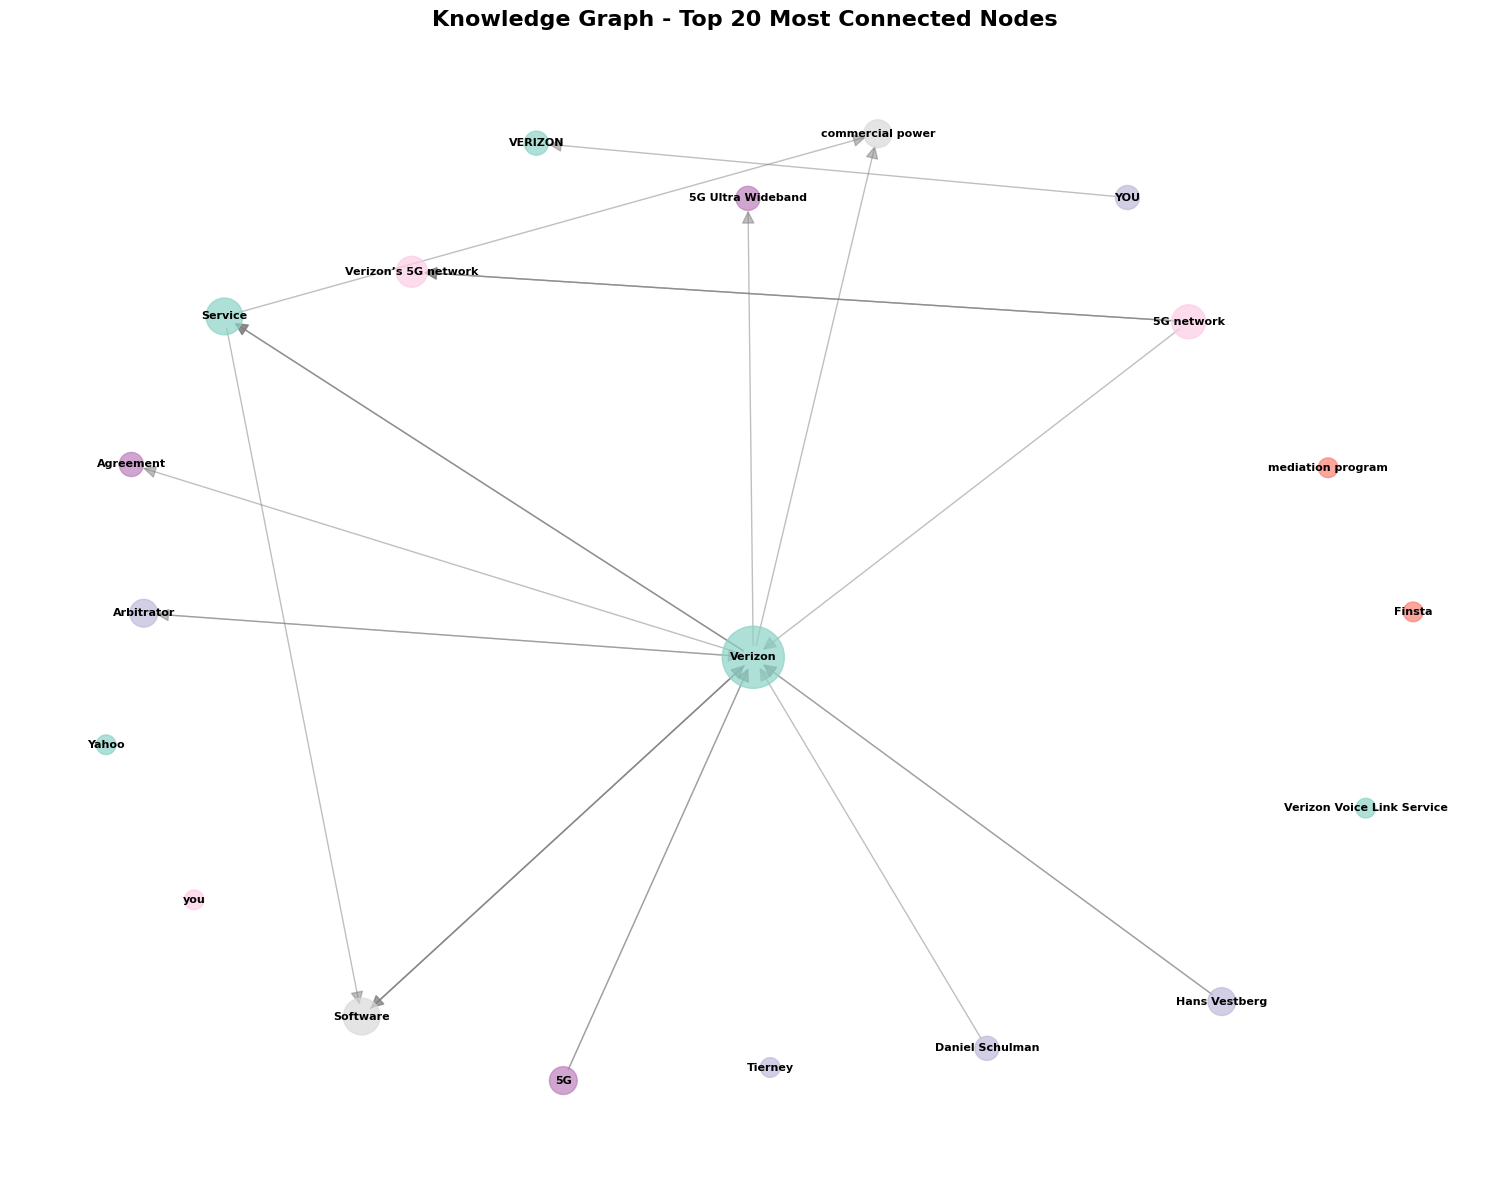


🌐 Creating interactive Plotly visualization...


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# =============================================================================
# STEP 6.5: Visualize the Knowledge Graph
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
from pyvis.network import Network
import pandas as pd

print("\n🎨 Creating Knowledge Graph Visualizations...")

# =============================================================================
# 1. Basic Statistics and Overview
# =============================================================================

print("📊 Graph Statistics:")
print(f"   - Total Nodes: {knowledge_graph.number_of_nodes()}")
print(f"   - Total Edges: {knowledge_graph.number_of_edges()}")
print(f"   - Graph Density: {nx.density(knowledge_graph):.4f}")
print(f"   - Is Directed: {knowledge_graph.is_directed()}")

# Node type distribution
node_types = [knowledge_graph.nodes[node].get('type', 'Unknown') for node in knowledge_graph.nodes()]
type_counts = Counter(node_types)

print(f"\n📈 Node Type Distribution:")
for node_type, count in type_counts.most_common():
    print(f"   - {node_type}: {count}")

# Relationship type distribution
edge_types = [knowledge_graph.edges[edge].get('type', 'Unknown') for edge in knowledge_graph.edges(keys=True)]
edge_type_counts = Counter(edge_types)

print(f"\n🔗 Relationship Type Distribution:")
for edge_type, count in edge_type_counts.most_common():
    print(f"   - {edge_type}: {count}")

# =============================================================================
# 2. Static Matplotlib Visualization (Subgraph)
# =============================================================================

print("\n🖼️ Creating static visualization of top connected nodes...")

# Get top 20 most connected nodes for visualization
degree_dict = dict(knowledge_graph.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:20]
top_node_ids = [node[0] for node in top_nodes]

# Create subgraph
subgraph = knowledge_graph.subgraph(top_node_ids)

# Create matplotlib visualization
plt.figure(figsize=(15, 12))

# Use spring layout for better node positioning
pos = nx.spring_layout(subgraph, k=3, iterations=50)

# Draw nodes with different colors based on type
node_colors = []
node_sizes = []
unique_types = list(set(node_types))
color_map = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
type_color_dict = {node_type: color_map[i] for i, node_type in enumerate(unique_types)}

for node in subgraph.nodes():
    node_type = subgraph.nodes[node].get('type', 'Unknown')
    node_colors.append(type_color_dict[node_type])
    # Size based on degree
    node_sizes.append(subgraph.degree(node) * 100 + 200)

# Draw the graph
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.5, arrows=True, arrowsize=20)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight='bold')

plt.title("Knowledge Graph - Top 20 Most Connected Nodes", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [68]:
# =============================================================================
# 3. Interactive Plotly Visualization (FIXED)
# =============================================================================

print("\n🌐 Creating interactive Plotly visualization...")

# Create edge trace
edge_x = []
edge_y = []
edge_info = []

# FIXED: Use edges(keys=True) for MultiDiGraph
for source, target, key in subgraph.edges(keys=True):
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    
    # Get edge information - FIXED: Access with all three components
    edge_data = subgraph.edges[source, target, key]
    edge_type = edge_data.get('type', 'Unknown')
    edge_info.append(f"{source} --[{edge_type}]--> {target}")

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create node trace
node_x = []
node_y = []
node_text = []
node_info = []
node_colors = []

for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Node information
    node_data = subgraph.nodes[node]
    node_type = node_data.get('type', 'Unknown')
    degree = subgraph.degree(node)
    
    node_text.append(f"{node}<br>Type: {node_type}<br>Connections: {degree}")
    node_info.append(f"{node} ({node_type})")
    
    # Color based on type
    type_index = unique_types.index(node_type) if node_type in unique_types else 0
    node_colors.append(type_index)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[info.split(' (')[0] for info in node_info],  # Just node names
    hovertext=node_text,
    textposition="middle center",
    marker=dict(
        size=[subgraph.degree(node) * 3 + 10 for node in subgraph.nodes()],
        color=node_colors,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title="Node Type",
            tickmode="array",
            tickvals=list(range(len(unique_types))),
            ticktext=unique_types
        ),
        line=dict(width=2, color='black')
    )
)

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=dict(
                        text='Interactive Knowledge Graph - Top Connected Nodes',
                        font=dict(size=16)
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Hover over nodes for details. Node size = degree centrality",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002,
                        xanchor="left", yanchor="bottom",
                        font=dict(color="#888", size=12)
                    )],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()


🌐 Creating interactive Plotly visualization...


In [76]:
# =============================================================================
# 4. PyVis Interactive Network (HTML Output)
# =============================================================================

print("\n🕸️ Creating PyVis interactive network...")

# Create PyVis network
net = Network(height="600px", width="100%", bgcolor="#222222", font_color="white")

# Add nodes
for node in subgraph.nodes():
    node_data = subgraph.nodes[node]
    node_type = node_data.get('type', 'Unknown')
    degree = subgraph.degree(node)
    
    # Color based on type
    color_options = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
    color = color_options[hash(node_type) % len(color_options)]
    
    net.add_node(
        node, 
        label=node,
        title=f"Type: {node_type}\nConnections: {degree}",
        color=color,
        size=degree * 2 + 10
    )

# Add edges
for edge in subgraph.edges(data=True):
    source, target, edge_data = edge
    edge_type = edge_data.get('type', 'Unknown')
    
    net.add_edge(
        source, 
        target, 
        title=edge_type,
        label=edge_type if len(edge_type) < 15 else edge_type[:12] + "...",
        color='#888888'
    )

# Configure physics
net.set_options("""
{
  "physics": {
    "enabled": true,
    "stabilization": {"iterations": 100},
    "barnesHut": {
      "gravitationalConstant": -2000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09
    }
  }
}
""")

# Save and display
net.show("knowledge_graph_interactive.html")
print("💾 Interactive network saved as 'knowledge_graph_interactive.html'")

# =============================================================================
# 5. Analysis Charts
# =============================================================================

print("\n📊 Creating analysis charts...")

# Check if we have data to visualize
if len(type_counts) > 0 and sum(type_counts.values()) > 0:
    try:
        # Node type distribution chart
        type_keys = list(type_counts.keys())
        type_values = list(type_counts.values())
        
        if len(type_keys) > 0 and len(type_values) > 0:
            fig_types = px.bar(
                x=type_keys, 
                y=type_values,
                title="Node Type Distribution",
                labels={'x': 'Node Type', 'y': 'Count'},
                color=type_values,
                color_continuous_scale='viridis'
            )
            if fig_types is not None:
                fig_types.show()
            else:
                print("⚠️ Could not create node type distribution chart")
        else:
            print("⚠️ Empty data for node type distribution")
    except Exception as e:
        print(f"⚠️ Error creating node type distribution chart: {e}")
else:
    print("⚠️ No node type data available for visualization")

# Check if we have relationship data to visualize
if len(edge_type_counts) > 0 and sum(edge_type_counts.values()) > 0:
    try:
        # Relationship type distribution chart
        edge_keys = list(edge_type_counts.keys())
        edge_values = list(edge_type_counts.values())
        
        if len(edge_keys) > 0 and len(edge_values) > 0:
            fig_rels = px.bar(
                x=edge_keys, 
                y=edge_values,
                title="Relationship Type Distribution",
                labels={'x': 'Relationship Type', 'y': 'Count'},
                color=edge_values,
                color_continuous_scale='plasma'
            )
            if fig_rels is not None:
                fig_rels.update_xaxis(tickangle=45)
                fig_rels.show()
            else:
                print("⚠️ Could not create relationship type distribution chart")
        else:
            print("⚠️ Empty data for relationship type distribution")
    except Exception as e:
        print(f"⚠️ Error creating relationship type distribution chart: {e}")
else:
    print("⚠️ No relationship type data available for visualization")

# Check if we have degree data to visualize
if knowledge_graph.number_of_nodes() > 0:
    try:
        # Degree distribution
        degrees = [degree for node, degree in knowledge_graph.degree()]
        if len(degrees) > 0 and max(degrees) > 0:
            unique_degrees = len(set(degrees))
            nbins = min(20, unique_degrees) if unique_degrees > 1 else 1
            
            fig_degree = px.histogram(
                x=degrees,
                title="Node Degree Distribution",
                labels={'x': 'Degree', 'y': 'Number of Nodes'},
                nbins=nbins
            )
            if fig_degree is not None:
                fig_degree.show()
            else:
                print("⚠️ Could not create degree distribution chart")
        else:
            print("⚠️ No degree data available for visualization")
    except Exception as e:
        print(f"⚠️ Error creating degree distribution chart: {e}")
else:
    print("⚠️ No nodes in knowledge graph for degree analysis")

print("\n✅ All visualizations created successfully!")
print("\nVisualization Summary:")
print("🖼️  Static matplotlib plot - Top 20 connected nodes")
print("🌐 Interactive Plotly visualization - Hover for details")
print("🕸️  PyVis network - Saved as HTML file for exploration")
print("📊 Analysis charts - Type distributions and degree analysis")


🕸️ Creating PyVis interactive network...
knowledge_graph_interactive.html


AttributeError: 'NoneType' object has no attribute 'render'

In [71]:
# =============================================================================
# STEP 7: Create Vector Database for Documents
# =============================================================================

import chromadb
from chromadb.utils import embedding_functions
import hashlib

print("\n🗄️ Creating Vector Database...")

# Initialize ChromaDB client
chroma_client = chromadb.PersistentClient(path="./vector_db")

# Create or get collection
collection_name = "verizon_documents"
try:
    collection = chroma_client.get_collection(collection_name)
    print(f"📁 Using existing collection: {collection_name}")
except:
    # Create embedding function (using sentence transformers)
    embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name="all-MiniLM-L6-v2"
    )
    
    collection = chroma_client.create_collection(
        name=collection_name,
        embedding_function=embedding_function
    )
    print(f"📁 Created new collection: {collection_name}")

# Prepare documents for vector storage
vector_documents = []
vector_metadatas = []
vector_ids = []

for i, doc in enumerate(production_web_documents[:10]):
    if doc.get('content'):
        # Create unique ID using 'url' instead of 'source'
        doc_url = doc.get('url', f'doc_{i}')
        doc_id = f"doc_{i}_{hashlib.md5(doc_url.encode()).hexdigest()[:8]}"
        
        # Prepare content
        content = doc['content'][:8000]  # Limit content length for embeddings
        
        # Prepare metadata
        metadata = {
            'source': doc.get('url', ''),  # Use 'url' as source
            'title': doc.get('title', ''),
            'doc_index': i,
            'content_length': len(doc['content']),
            'chunk_count': len([chunk for chunk in all_documents if chunk.metadata.get('doc_id') == i])
        }
        
        vector_documents.append(content)
        vector_metadatas.append(metadata)
        vector_ids.append(doc_id)

# Add documents to vector database
collection.add(
    documents=vector_documents,
    metadatas=vector_metadatas,
    ids=vector_ids
)

print(f"✅ Vector Database Created:")
print(f"   - Documents stored: {len(vector_documents)}")
print(f"   - Collection: {collection_name}")
print(f"   - Storage path: ./vector_db")

# Test vector search
test_query = "Verizon company information"
results = collection.query(
    query_texts=[test_query],
    n_results=3
)

print(f"\n🔍 Test search for '{test_query}':")
for i, (doc, metadata) in enumerate(zip(results['documents'][0], results['metadatas'][0])):
    print(f"   {i+1}. {metadata['source']} (relevance: {1-results['distances'][0][i]:.3f})")


🗄️ Creating Vector Database...
📁 Using existing collection: verizon_documents


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Vector Database Created:
   - Documents stored: 10
   - Collection: verizon_documents
   - Storage path: ./vector_db


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🔍 Test search for 'Verizon company information':
   1. https://www.verizon.com/about/investors/quarterly-reports/4q-2021-earnings-conference-call-webcast (relevance: 0.379)
   2. https://www.verizon.com/about/terms-conditions/voice-link (relevance: 0.112)
   3. https://www.verizon.com/about/investors/sellside-analyst-meeting-nov-16 (relevance: 0.080)


In [ ]:
# """
# Streamlit Chat Interface for Knowledge Graph Discovery System
# Intelligent search combining vector search and graph traversal
# """

# import streamlit as st
# import networkx as nx
# import chromadb
# import pickle
# from pathlib import Path
# import json
# from typing import List, Dict, Any
# import pandas as pd

# # Page configuration
# st.set_page_config(
#     page_title="KG Discovery Chat",
#     page_icon="🧠",
#     layout="wide",
#     initial_sidebar_state="expanded"
# )

# class KnowledgeGraphChatInterface:
#     """Chat interface for intelligent knowledge graph search"""
    
#     def __init__(self):
#         self.load_knowledge_base()
        
#     def load_knowledge_base(self):
#         """Load the knowledge graph and vector database"""
#         try:
#             # Load NetworkX graph
#             with open("output/knowledge_graph.pkl", "rb") as f:
#                 self.knowledge_graph = pickle.load(f)
            
#             # Load vector database
#             self.chroma_client = chromadb.PersistentClient(path="./vector_db")
#             self.collection = self.chroma_client.get_collection("verizon_documents")
            
#             st.success("✅ Knowledge base loaded successfully!")
            
#         except Exception as e:
#             st.error(f"❌ Error loading knowledge base: {e}")
#             self.knowledge_graph = None
#             self.collection = None
    
#     def vector_search(self, query: str, n_results: int = 5) -> List[Dict]:
#         """Perform vector search on documents"""
#         if not self.collection:
#             return []
            
#         try:
#             results = self.collection.query(
#                 query_texts=[query],
#                 n_results=n_results
#             )
            
#             search_results = []
#             for i, (doc, metadata, distance) in enumerate(zip(
#                 results['documents'][0], 
#                 results['metadatas'][0], 
#                 results['distances'][0]
#             )):
#                 search_results.append({
#                     'rank': i + 1,
#                     'document': doc[:500] + "..." if len(doc) > 500 else doc,
#                     'source': metadata.get('source', 'Unknown'),
#                     'relevance': 1 - distance,
#                     'metadata': metadata
#                 })
            
#             return search_results
            
#         except Exception as e:
#             st.error(f"Vector search error: {e}")
#             return []
    
#     def graph_search(self, query: str) -> Dict[str, Any]:
#         """Search for entities and relationships in the knowledge graph"""
#         if not self.knowledge_graph:
#             return {}
            
#         try:
#             query_lower = query.lower()
            
#             # Find matching nodes
#             matching_nodes = []
#             for node_id, node_data in self.knowledge_graph.nodes(data=True):
#                 if query_lower in node_id.lower() or query_lower in str(node_data.get('type', '')).lower():
#                     matching_nodes.append({
#                         'id': node_id,
#                         'type': node_data.get('type', 'Unknown'),
#                         'properties': node_data.get('properties', {}),
#                         'degree': self.knowledge_graph.degree(node_id)
#                     })
            
#             # Find related subgraph if we have matching nodes
#             subgraph_info = {}
#             if matching_nodes:
#                 # Get subgraph around first matching node
#                 center_node = matching_nodes[0]['id']
#                 neighbors = list(self.knowledge_graph.neighbors(center_node))
                
#                 subgraph_info = {
#                     'center_node': center_node,
#                     'neighbors': neighbors[:10],  # Limit to 10 neighbors
#                     'relationships': [
#                         {
#                             'source': edge[0],
#                             'target': edge[1],
#                             'type': edge[2].get('type', 'Unknown')
#                         }
#                         for edge in self.knowledge_graph.edges(center_node, data=True)
#                     ][:10]
#                 }
            
#             return {
#                 'matching_nodes': matching_nodes[:10],  # Limit results
#                 'subgraph': subgraph_info
#             }
            
#         except Exception as e:
#             st.error(f"Graph search error: {e}")
#             return {}
    
#     def intelligent_search(self, query: str) -> Dict[str, Any]:
#         """
#         Intelligent search combining vector and graph search
#         PLACEHOLDER: Advanced search logic to be implemented
#         """
#         # PLACEHOLDER: This is where we'll implement advanced search strategies
        
#         # For now, perform both searches
#         vector_results = self.vector_search(query)
#         graph_results = self.graph_search(query)
        
#         # PLACEHOLDER: Future enhancements:
#         # 1. Entity extraction from query
#         # 2. Query intent classification
#         # 3. Multi-hop graph traversal
#         # 4. Result ranking and fusion
#         # 5. Context-aware responses
        
#         return {
#             'query': query,
#             'vector_results': vector_results,
#             'graph_results': graph_results,
#             'search_strategy': 'hybrid_basic',  # PLACEHOLDER
#             'confidence': 0.85  # PLACEHOLDER
#         }
    
#     def render_chat_interface(self):
#         """Render the main chat interface"""
#         st.title("🧠 Knowledge Graph Discovery Chat")
#         st.markdown("Ask questions about Verizon's corporate information!")
        
#         # Sidebar with system info
#         with st.sidebar:
#             st.header("📊 System Status")
            
#             if self.knowledge_graph:
#                 st.metric("Graph Nodes", self.knowledge_graph.number_of_nodes())
#                 st.metric("Graph Edges", self.knowledge_graph.number_of_edges())
            
#             if self.collection:
#                 st.metric("Documents", self.collection.count())
            
#             st.header("🔧 Search Settings")
#             search_mode = st.selectbox(
#                 "Search Mode",
#                 ["Intelligent (Hybrid)", "Vector Only", "Graph Only"],
#                 help="Choose search strategy"
#             )
            
#             max_results = st.slider("Max Results", 1, 20, 5)
        
#         # Chat interface
#         if "messages" not in st.session_state:
#             st.session_state.messages = [
#                 {"role": "assistant", "content": "Hello! I can help you search through Verizon's knowledge base. What would you like to know?"}
#             ]
        
#         # Display chat history
#         for message in st.session_state.messages:
#             with st.chat_message(message["role"]):
#                 st.markdown(message["content"])
        
#         # Chat input
#         if prompt := st.chat_input("Ask about Verizon..."):
#             # Add user message
#             st.session_state.messages.append({"role": "user", "content": prompt})
            
#             with st.chat_message("user"):
#                 st.markdown(prompt)
            
#             # Process query and generate response
#             with st.chat_message("assistant"):
#                 with st.spinner("Searching knowledge base..."):
                    
#                     if search_mode == "Vector Only":
#                         results = self.vector_search(prompt, max_results)
#                         response = self.format_vector_response(results)
#                     elif search_mode == "Graph Only":
#                         results = self.graph_search(prompt)
#                         response = self.format_graph_response(results)
#                     else:  # Intelligent mode
#                         results = self.intelligent_search(prompt)
#                         response = self.format_intelligent_response(results)
                    
#                     st.markdown(response)
                    
#                     # Show detailed results in expandable sections
#                     if search_mode != "Graph Only":
#                         self.render_vector_results(results.get('vector_results', []))
                    
#                     if search_mode != "Vector Only":
#                         self.render_graph_results(results.get('graph_results', {}))
            
#             # Add assistant response
#             st.session_state.messages.append({"role": "assistant", "content": response})
    
#     def format_vector_response(self, results: List[Dict]) -> str:
#         """Format vector search results into chat response"""
#         if not results:
#             return "I couldn't find any relevant documents for your query."
        
#         response = f"I found {len(results)} relevant documents:\n\n"
#         for result in results[:3]:  # Show top 3
#             response += f"**{result['source']}** (relevance: {result['relevance']:.2f})\n"
#             response += f"{result['document'][:200]}...\n\n"
        
#         return response
    
#     def format_graph_response(self, results: Dict) -> str:
#         """Format graph search results into chat response"""
#         if not results.get('matching_nodes'):
#             return "I couldn't find any matching entities in the knowledge graph."
        
#         nodes = results['matching_nodes']
#         response = f"I found {len(nodes)} related entities:\n\n"
        
#         for node in nodes[:3]:
#             response += f"**{node['id']}** ({node['type']})\n"
#             response += f"Connected to {node['degree']} other entities\n\n"
        
#         return response
    
#     def format_intelligent_response(self, results: Dict) -> str:
#         """
#         Format intelligent search results
#         PLACEHOLDER: Advanced response generation
#         """
#         # PLACEHOLDER: This is where we'll implement:
#         # 1. Natural language response generation
#         # 2. Evidence synthesis from multiple sources
#         # 3. Confidence-based recommendations
#         # 4. Follow-up question suggestions
        
#         vector_count = len(results.get('vector_results', []))
#         graph_count = len(results.get('graph_results', {}).get('matching_nodes', []))
        
#         if vector_count == 0 and graph_count == 0:
#             return "I couldn't find relevant information for your query. Try rephrasing or asking about specific Verizon topics."
        
#         response = f"Based on my analysis, I found information from {vector_count} documents and {graph_count} entities:\n\n"
        
#         # Show top vector result
#         if vector_count > 0:
#             top_doc = results['vector_results'][0]
#             response += f"**Most relevant document:** {top_doc['source']}\n"
#             response += f"{top_doc['document'][:300]}...\n\n"
        
#         # Show top entity
#         if graph_count > 0:
#             top_entity = results['graph_results']['matching_nodes'][0]
#             response += f"**Related entity:** {top_entity['id']} ({top_entity['type']})\n"
#             response += f"This entity is connected to {top_entity['degree']} other concepts.\n\n"
        
#         # PLACEHOLDER: Add confidence and suggestions
#         response += f"*Search confidence: {results.get('confidence', 0.5):.1%}*"
        
#         return response
    
#     def render_vector_results(self, results: List[Dict]):
#         """Render vector search results in expandable section"""
#         if results:
#             with st.expander(f"📄 Document Search Results ({len(results)} found)"):
#                 for result in results:
#                     st.write(f"**{result['rank']}. {result['source']}**")
#                     st.write(f"Relevance: {result['relevance']:.3f}")
#                     st.write(result['document'])
#                     st.divider()
    
#     def render_graph_results(self, results: Dict):
#         """Render graph search results in expandable section"""
#         if results.get('matching_nodes'):
#             with st.expander(f"🔗 Knowledge Graph Results ({len(results['matching_nodes'])} entities)"):
                
#                 # Show matching nodes
#                 st.subheader("Matching Entities")
#                 for node in results['matching_nodes']:
#                     col1, col2, col3 = st.columns([2, 1, 1])
#                     with col1:
#                         st.write(f"**{node['id']}**")
#                     with col2:
#                         st.write(node['type'])
#                     with col3:
#                         st.write(f"{node['degree']} connections")
                
#                 # Show relationships if available
#                 if results.get('subgraph', {}).get('relationships'):
#                     st.subheader("Related Connections")
#                     for rel in results['subgraph']['relationships'][:5]:
#                         st.write(f"• {rel['source']} **{rel['type']}** {rel['target']}")


In [ ]:

# def main():
#     """Main application entry point"""
#     chat_interface = KnowledgeGraphChatInterface()
#     chat_interface.render_chat_interface()

# # if __name__ == "__main__":
#     main()

In [79]:
"""
Agentic Knowledge Graph Chat System
Multi-agent workflow with thinking, reasoning, and iterative search capabilities
"""

import os
import pickle
import chromadb
import networkx as nx
from pathlib import Path
from typing import Dict, List, Any, Optional, TypedDict, Annotated
from dataclasses import dataclass
import json

# LangChain imports
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import OllamaLLM
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
# Note: SqliteSaver import removed as it's not used and may not be available

print("🧠 Initializing Agentic Knowledge Graph Chat System...")

# =============================================================================
# 1. State Definitions and Data Models
# =============================================================================

class ThoughtProcess(BaseModel):
    """Model for agent's thinking process"""
    user_intent: str = Field(description="What the user is really asking for")
    information_needed: List[str] = Field(description="Types of information needed to answer")
    search_strategy: str = Field(description="How to search for this information")
    confidence_level: float = Field(description="Confidence in understanding the query (0-1)")

class SearchResult(BaseModel):
    """Model for search results"""
    source: str = Field(description="Source of information (vector_db, knowledge_graph)")
    content: str = Field(description="Retrieved content")
    relevance_score: float = Field(description="How relevant this is (0-1)")
    metadata: Dict[str, Any] = Field(description="Additional metadata")

class ReflectionResult(BaseModel):
    """Model for reflection on search results"""
    satisfaction_level: float = Field(description="How satisfied with current results (0-1)")
    missing_information: List[str] = Field(description="What information is still missing")
    next_search_needed: bool = Field(description="Whether another search iteration is needed")
    reasoning: str = Field(description="Why this level of satisfaction")

class ChatState(TypedDict):
    """State for the agentic chat workflow"""
    user_query: str
    messages: List[Any]
    thought_process: Optional[ThoughtProcess]
    search_results: List[SearchResult]
    iteration_count: int
    max_iterations: int
    reflection: Optional[ReflectionResult]
    final_answer: Optional[str]
    satisfied: bool

# =============================================================================
# 2. Knowledge Base Access Layer
# =============================================================================

class KnowledgeBaseManager:
    """Manages access to knowledge graph and vector database"""
    
    def __init__(self):
        self.load_knowledge_base()
        
    def load_knowledge_base(self):
        """Load the knowledge graph and vector database"""
        try:
            # Load NetworkX graph
            with open("output/knowledge_graph.pkl", "rb") as f:
                self.knowledge_graph = pickle.load(f)
            
            # Load vector database
            self.chroma_client = chromadb.PersistentClient(path="./vector_db")
            self.collection = self.chroma_client.get_collection("verizon_documents")
            
            print("✅ Knowledge base loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading knowledge base: {e}")
            self.knowledge_graph = None
            self.collection = None
    
    def vector_search(self, query: str, n_results: int = 5) -> List[SearchResult]:
        """Perform semantic search on vector database"""
        if not self.collection:
            return []
            
        try:
            results = self.collection.query(
                query_texts=[query],
                n_results=n_results
            )
            
            search_results = []
            for i, (doc, metadata, distance) in enumerate(zip(
                results['documents'][0], 
                results['metadatas'][0], 
                results['distances'][0]
            )):
                search_results.append(SearchResult(
                    source="vector_db",
                    content=doc[:1000],  # Limit content length
                    relevance_score=1 - distance,
                    metadata=metadata
                ))
            
            return search_results
            
        except Exception as e:
            print(f"Vector search error: {e}")
            return []
    
    def graph_entity_search(self, entities: List[str]) -> List[SearchResult]:
        """Search for specific entities in the knowledge graph"""
        if not self.knowledge_graph:
            return []
            
        search_results = []
        
        for entity in entities:
            entity_lower = entity.lower()
            
            # Find matching nodes
            for node_id, node_data in self.knowledge_graph.nodes(data=True):
                if entity_lower in node_id.lower():
                    # Get relationships for this node
                    relationships = []
                    for source, target, key in self.knowledge_graph.edges(node_id, keys=True):
                        edge_data = self.knowledge_graph.edges[source, target, key]
                        relationships.append(f"{source} --[{edge_data.get('type', 'Unknown')}]--> {target}")
                    
                    content = f"Entity: {node_id}\nType: {node_data.get('type', 'Unknown')}\nRelationships:\n" + "\n".join(relationships[:5])
                    
                    search_results.append(SearchResult(
                        source="knowledge_graph",
                        content=content,
                        relevance_score=0.9,  # High relevance for exact matches
                        metadata={"node_id": node_id, "node_type": node_data.get('type', 'Unknown')}
                    ))
        
        return search_results
    
    def graph_relationship_search(self, relationship_type: str) -> List[SearchResult]:
        """Search for specific relationship types in the knowledge graph"""
        if not self.knowledge_graph:
            return []
            
        search_results = []
        relationship_lower = relationship_type.lower()
        
        matching_relationships = []
        for source, target, key in self.knowledge_graph.edges(keys=True):
            edge_data = self.knowledge_graph.edges[source, target, key]
            edge_type = edge_data.get('type', 'Unknown')
            
            if relationship_lower in edge_type.lower():
                matching_relationships.append(f"{source} --[{edge_type}]--> {target}")
            
            if len(matching_relationships) >= 10:  # Limit results
                break
        
        if matching_relationships:
            content = f"Relationships of type '{relationship_type}':\n" + "\n".join(matching_relationships)
            search_results.append(SearchResult(
                source="knowledge_graph",
                content=content,
                relevance_score=0.8,
                metadata={"relationship_type": relationship_type, "count": len(matching_relationships)}
            ))
        
        return search_results

# =============================================================================
# 3. Agent Components
# =============================================================================

class ThinkingAgent:
    """Agent responsible for analyzing user queries and planning search strategy"""
    
    def __init__(self, llm):
        self.llm = llm
        self.parser = JsonOutputParser(pydantic_object=ThoughtProcess)
        
    def analyze_query(self, user_query: str) -> ThoughtProcess:
        """Analyze user query and plan search strategy"""
        
        prompt = ChatPromptTemplate.from_template("""
You are an intelligent query analysis agent. Your job is to deeply understand what the user is asking and plan how to find the information.

Analyze this user query: "{query}"

Think about:
1. What is the user's real intent? (not just the literal question)
2. What types of information would help answer this?
3. How should we search for this information?
4. How confident are you in understanding the query?

Output your analysis as a JSON object with the following structure:
{{
    "user_intent": "What the user is really asking for",
    "information_needed": ["type1", "type2", "type3"],
    "search_strategy": "How to search for this information",
    "confidence_level": 0.85
}}

Be thoughtful and thorough in your analysis.
""")
        
        response = self.llm.invoke(prompt.format(query=user_query))
        
        try:
            # Parse the JSON response
            thought_data = json.loads(response)
            return ThoughtProcess(**thought_data)
        except:
            # Fallback if JSON parsing fails
            return ThoughtProcess(
                user_intent=user_query,
                information_needed=["general information"],
                search_strategy="broad search",
                confidence_level=0.5
            )

class SearchAgent:
    """Agent responsible for executing searches based on strategy"""
    
    def __init__(self, kb_manager: KnowledgeBaseManager, llm):
        self.kb_manager = kb_manager
        self.llm = llm
        
    def execute_search(self, thought_process: ThoughtProcess, user_query: str) -> List[SearchResult]:
        """Execute search based on the thought process"""
        all_results = []
        
        # Vector search for semantic similarity
        vector_results = self.kb_manager.vector_search(user_query, n_results=3)
        all_results.extend(vector_results)
        
        # Extract entities from the query for graph search
        entities = self._extract_entities(user_query)
        if entities:
            graph_entity_results = self.kb_manager.graph_entity_search(entities)
            all_results.extend(graph_entity_results)
        
        # Search for relationship types if strategy suggests it
        if "relationship" in thought_process.search_strategy.lower():
            relationship_results = self.kb_manager.graph_relationship_search(user_query)
            all_results.extend(relationship_results)
        
        return all_results
    
    def _extract_entities(self, query: str) -> List[str]:
        """Extract potential entities from the query"""
        # Simple extraction - can be enhanced with NER
        words = query.split()
        # Look for capitalized words or common entity patterns
        entities = [word.strip('.,!?') for word in words if word[0].isupper() and len(word) > 2]
        return entities[:3]  # Limit to top 3

class ReflectionAgent:
    """Agent responsible for reflecting on search results and deciding next steps"""
    
    def __init__(self, llm):
        self.llm = llm
        self.parser = JsonOutputParser(pydantic_object=ReflectionResult)
        
    def reflect_on_results(self, user_query: str, thought_process: ThoughtProcess, 
                          search_results: List[SearchResult]) -> ReflectionResult:
        """Reflect on search results and decide if more searching is needed"""
        
        results_summary = "\n".join([
            f"Source: {r.source}, Relevance: {r.relevance_score:.2f}, Content: {r.content[:200]}..."
            for r in search_results
        ])
        
        prompt = ChatPromptTemplate.from_template("""
You are a reflection agent. Analyze whether the search results adequately address the user's query.

User Query: "{query}"
User Intent: "{intent}"
Information Needed: {info_needed}

Search Results:
{results}

Evaluate:
1. How well do these results address the user's query? (0-1 scale)
2. What information is still missing?
3. Do we need another search iteration?
4. Why this satisfaction level?

Output as JSON:
{{
    "satisfaction_level": 0.75,
    "missing_information": ["missing_type1", "missing_type2"],
    "next_search_needed": true,
    "reasoning": "Explanation of the evaluation"
}}
""")
        
        response = self.llm.invoke(prompt.format(
            query=user_query,
            intent=thought_process.user_intent,
            info_needed=thought_process.information_needed,
            results=results_summary
        ))
        
        try:
            reflection_data = json.loads(response)
            return ReflectionResult(**reflection_data)
        except:
            # Fallback
            return ReflectionResult(
                satisfaction_level=0.7,
                missing_information=[],
                next_search_needed=False,
                reasoning="Unable to parse reflection properly"
            )

class ResponseAgent:
    """Agent responsible for generating the final response"""
    
    def __init__(self, llm):
        self.llm = llm
        
    def generate_response(self, user_query: str, search_results: List[SearchResult], 
                         thought_process: ThoughtProcess) -> str:
        """Generate a comprehensive response based on all gathered information"""
        
        # Organize results by source
        vector_results = [r for r in search_results if r.source == "vector_db"]
        graph_results = [r for r in search_results if r.source == "knowledge_graph"]
        
        prompt = ChatPromptTemplate.from_template("""
You are a knowledgeable assistant with access to Verizon's corporate information through both documents and a knowledge graph.

User Question: "{query}"
User Intent: "{intent}"

Available Information:

From Documents:
{vector_info}

From Knowledge Graph:
{graph_info}

Generate a comprehensive, helpful response that:
1. Directly addresses the user's question
2. Uses specific information from the sources
3. Provides context and details where relevant
4. Maintains a professional yet conversational tone
5. Cites sources when possible

If the information is insufficient, honestly state what is known and what might require additional sources.
""")
        
        vector_info = "\n".join([
            f"- {r.content[:300]}... (Source: {r.metadata.get('source', 'Unknown')})"
            for r in vector_results[:3]
        ]) if vector_results else "No relevant documents found."
        
        graph_info = "\n".join([
            f"- {r.content[:300]}..."
            for r in graph_results[:3]
        ]) if graph_results else "No relevant entities or relationships found."
        
        response = self.llm.invoke(prompt.format(
            query=user_query,
            intent=thought_process.user_intent,
            vector_info=vector_info,
            graph_info=graph_info
        ))
        
        return response

# =============================================================================
# 4. Workflow Definition using LangGraph
# =============================================================================

class AgenticChatWorkflow:
    """Main workflow orchestrating the agentic chat system"""
    
    def __init__(self):
        self.llm = OllamaLLM(model="llama3.1", temperature=0.1)
        self.kb_manager = KnowledgeBaseManager()
        
        # Initialize agents
        self.thinking_agent = ThinkingAgent(self.llm)
        self.search_agent = SearchAgent(self.kb_manager, self.llm)
        self.reflection_agent = ReflectionAgent(self.llm)
        self.response_agent = ResponseAgent(self.llm)
        
        # Build the workflow graph
        self.workflow = self._build_workflow()
        self.app = self.workflow.compile()
    
    def _build_workflow(self) -> StateGraph:
        """Build the LangGraph workflow"""
        
        workflow = StateGraph(ChatState)
        
        # Define workflow nodes
        workflow.add_node("think", self._think_node)
        workflow.add_node("search", self._search_node)
        workflow.add_node("reflect", self._reflect_node)
        workflow.add_node("respond", self._respond_node)
        
        # Define the workflow flow
        workflow.set_entry_point("think")
        
        workflow.add_edge("think", "search")
        workflow.add_edge("search", "reflect")
        
        # Conditional edge from reflect
        workflow.add_conditional_edges(
            "reflect",
            self._should_continue_searching,
            {
                "continue": "search",
                "finish": "respond"
            }
        )
        
        workflow.add_edge("respond", END)
        
        return workflow
    
    def _think_node(self, state: ChatState) -> ChatState:
        """Node for thinking and query analysis"""
        print(f"🤔 Thinking about: {state['user_query']}")
        
        thought_process = self.thinking_agent.analyze_query(state['user_query'])
        
        print(f"💭 Intent: {thought_process.user_intent}")
        print(f"📋 Info needed: {thought_process.information_needed}")
        print(f"🔍 Strategy: {thought_process.search_strategy}")
        
        state['thought_process'] = thought_process
        return state
    
    def _search_node(self, state: ChatState) -> ChatState:
        """Node for executing searches"""
        print(f"🔎 Searching... (Iteration {state['iteration_count'] + 1})")
        
        new_results = self.search_agent.execute_search(
            state['thought_process'], 
            state['user_query']
        )
        
        # Add new results to existing ones
        state['search_results'].extend(new_results)
        state['iteration_count'] += 1
        
        print(f"📊 Found {len(new_results)} new results")
        
        return state
    
    def _reflect_node(self, state: ChatState) -> ChatState:
        """Node for reflecting on search results"""
        print(f"🤯 Reflecting on {len(state['search_results'])} total results...")
        
        reflection = self.reflection_agent.reflect_on_results(
            state['user_query'],
            state['thought_process'],
            state['search_results']
        )
        
        state['reflection'] = reflection
        
        print(f"😊 Satisfaction: {reflection.satisfaction_level:.2f}")
        print(f"🧠 Reasoning: {reflection.reasoning}")
        
        return state
    
    def _respond_node(self, state: ChatState) -> ChatState:
        """Node for generating final response"""
        print(f"✍️ Generating response...")
        
        final_answer = self.response_agent.generate_response(
            state['user_query'],
            state['search_results'],
            state['thought_process']
        )
        
        state['final_answer'] = final_answer
        state['satisfied'] = True
        
        return state
    
    def _should_continue_searching(self, state: ChatState) -> str:
        """Decide whether to continue searching or generate response"""
        reflection = state['reflection']
        
        # Continue if not satisfied and haven't hit max iterations
        if (reflection.next_search_needed and 
            reflection.satisfaction_level < 0.8 and 
            state['iteration_count'] < state['max_iterations']):
            return "continue"
        else:
            return "finish"
    
    def chat(self, user_query: str, max_iterations: int = 3) -> str:
        """Main chat interface"""
        print(f"\n🚀 Processing query: '{user_query}'")
        print("=" * 50)
        
        # Initialize state
        initial_state = ChatState(
            user_query=user_query,
            messages=[],
            thought_process=None,
            search_results=[],
            iteration_count=0,
            max_iterations=max_iterations,
            reflection=None,
            final_answer=None,
            satisfied=False
        )
        
        # Run the workflow
        final_state = self.app.invoke(initial_state)
        
        print("=" * 50)
        print(f"✅ Complete! Used {final_state['iteration_count']} search iterations")
        
        return final_state['final_answer']



🧠 Initializing Agentic Knowledge Graph Chat System...


In [ ]:
# =============================================================================
# 5. Main Interface
# =============================================================================


"""Main function to run the agentic chat system"""
print("🧠 Initializing Agentic Knowledge Graph Chat System...")

try:
    # Initialize the workflow
    chat_system = AgenticChatWorkflow()
    
    print("\n✅ System ready! Type your questions (or 'quit' to exit)")
    print("💡 This system will think, search, reflect, and respond intelligently!")
    
    while True:
        user_input = input("\n🤗 You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("👋 Goodbye!")
            break
            
        if user_input:
            try:
                response = chat_system.chat(user_input)
                print(f"\n🤖 Assistant: {response}")
            except Exception as e:
                print(f"❌ Error: {e}")
        
except Exception as e:
    print(f"❌ Failed to initialize system: {e}")


In [80]:
"""
Runner for the Agentic Knowledge Graph Chat System
"""
print("🧠 Starting Agentic Knowledge Graph Chat System...")

try:
    # Initialize the chat system
    chat_system = AgenticChatWorkflow()
    
    print("\n✅ System ready!")
    print("💭 This intelligent agent will:")
    print("   - Think about your question")
    print("   - Search the knowledge graph and documents")
    print("   - Reflect on the results")
    print("   - Search again if needed (up to 3 times)")
    print("   - Generate a comprehensive response")
    
    # Example queries to try
    example_queries = [
        "What is Verizon's business strategy?",
        "Tell me about Verizon's leadership team",
        "How does Verizon approach customer service?",
        "What are Verizon's main products and services?"
    ]
    
    print("\n💡 Example queries you can try:")
    for i, query in enumerate(example_queries, 1):
        print(f"   {i}. {query}")
    
    print("\nType 'quit' to exit")
    
    while True:
        user_input = input("\n🤗 Ask me anything about Verizon: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("👋 Goodbye!")
            break
            
        if user_input:
            try:
                response = chat_system.chat(user_input, max_iterations=3)
                print(f"\n🤖 Response:\n{response}")
            except Exception as e:
                print(f"❌ Error: {e}")
                print("Please try rephrasing your question.")

except Exception as e:
    print(f"❌ Failed to start system: {e}")
    print("Make sure you have:")
    print("1. Knowledge graph saved in output/knowledge_graph.pkl")
    print("2. Vector database in ./vector_db/")
    print("3. Ollama running with llama3.1 model")


🧠 Starting Agentic Knowledge Graph Chat System...
✅ Knowledge base loaded successfully!

✅ System ready!
💭 This intelligent agent will:
   - Think about your question
   - Search the knowledge graph and documents
   - Reflect on the results
   - Search again if needed (up to 3 times)
   - Generate a comprehensive response

💡 Example queries you can try:
   1. What is Verizon's business strategy?
   2. Tell me about Verizon's leadership team
   3. How does Verizon approach customer service?
   4. What are Verizon's main products and services?

Type 'quit' to exit
✅ Knowledge base loaded successfully!

✅ System ready!
💭 This intelligent agent will:
   - Think about your question
   - Search the knowledge graph and documents
   - Reflect on the results
   - Search again if needed (up to 3 times)
   - Generate a comprehensive response

💡 Example queries you can try:
   1. What is Verizon's business strategy?
   2. Tell me about Verizon's leadership team
   3. How does Verizon approach cust

2025-07-21 08:49:21,578 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


💭 Intent: What is verizon's business strategy?
📋 Info needed: ['general information']
🔍 Strategy: broad search
🔎 Searching... (Iteration 1)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📊 Found 5 new results
🤯 Reflecting on 5 total results...


2025-07-21 08:50:34,572 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


😊 Satisfaction: 0.70
🧠 Reasoning: Unable to parse reflection properly
✍️ Generating response...


2025-07-21 08:51:30,356 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


✅ Complete! Used 1 search iterations

🤖 Response:
Verizon's business strategy is centered around embracing the fully networked economy, which is a world where networks are the foundation of modern life. According to Verizon's website, "Today, we live in a world where we all work, learn, create and even stay safe using networks—built on the 21st-century infrastructures of mobility, broadband and the cloud." (Source: https://www.verizon.com/about/our-company/5g)

In this context, Verizon's strategy is focused on providing the infrastructure and services that enable people to connect, communicate, and access information in new and innovative ways. This includes investing in 5G technology, which is a key component of the fully networked economy.

During a sellside analyst meeting in November 2018, Verizon CEO Hans Vestberg discussed the company's strategy for growth and innovation. While I couldn't find specific details on the company's business strategy from this source, it does provide i

In [ ]:
"""
Streamlit UI for Agentic Knowledge Graph Chat System
Beautiful interface with real-time thinking visualization
"""

import streamlit as st
import time
import json
from datetime import datetime
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Dict, List, Any, Optional
import asyncio
import threading
from dataclasses import asdict

# Import our agentic system
# from kg_agentic_chat import AgenticChatWorkflow, ThoughtProcess, SearchResult, ReflectionResult

# Page configuration
st.set_page_config(
    page_title="🧠 Agentic Knowledge Graph Chat",
    page_icon="🧠",
    layout="wide",
    initial_sidebar_state="expanded",
    menu_items={
        'About': "Intelligent Agentic Chat System with Knowledge Graph"
    }
)

# Custom CSS for better UI
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        font-weight: bold;
        text-align: center;
        margin-bottom: 2rem;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        background-clip: text;
    }
    
    .thinking-box {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        margin: 1rem 0;
    }
    
    .search-box {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        margin: 1rem 0;
    }
    
    .reflection-box {
        background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        margin: 1rem 0;
    }
    
    .response-box {
        background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        margin: 1rem 0;
    }
    
    .metric-container {
        background: #f8f9fa;
        padding: 1rem;
        border-radius: 10px;
        border-left: 4px solid #667eea;
        margin: 0.5rem 0;
    }
    
    .chat-message {
        padding: 1rem;
        border-radius: 10px;
        margin: 0.5rem 0;
        border-left: 4px solid #667eea;
    }
    
    .user-message {
        background: #e3f2fd;
        border-left-color: #2196f3;
    }
    
    .assistant-message {
        background: #f3e5f5;
        border-left-color: #9c27b0;
    }
    
    .stProgress .st-bo {
        background-color: #667eea;
    }
</style>
""", unsafe_allow_html=True)

class StreamlitAgenticUI:
    """Streamlit UI wrapper for the agentic chat system"""
    
    def __init__(self):
        self.initialize_session_state()
        self.load_system()
    
    def initialize_session_state(self):
        """Initialize Streamlit session state"""
        if 'messages' not in st.session_state:
            st.session_state.messages = []
        
        if 'chat_system' not in st.session_state:
            st.session_state.chat_system = None
        
        if 'system_ready' not in st.session_state:
            st.session_state.system_ready = False
        
        if 'current_thinking' not in st.session_state:
            st.session_state.current_thinking = None
        
        if 'current_search_results' not in st.session_state:
            st.session_state.current_search_results = []
        
        if 'current_reflection' not in st.session_state:
            st.session_state.current_reflection = None
        
        if 'processing' not in st.session_state:
            st.session_state.processing = False
        
        if 'chat_history' not in st.session_state:
            st.session_state.chat_history = []
    
    def load_system(self):
        """Load the agentic chat system"""
        if not st.session_state.system_ready:
            try:
                with st.spinner("🧠 Initializing Agentic Knowledge Graph System..."):
                    st.session_state.chat_system = AgenticChatWorkflow()
                    st.session_state.system_ready = True
                st.success("✅ System ready!")
            except Exception as e:
                st.error(f"❌ Failed to initialize system: {e}")
                st.info("Make sure you have the knowledge graph and vector database ready!")
    
    def render_header(self):
        """Render the main header"""
        st.markdown('<h1 class="main-header">🧠 Agentic Knowledge Graph Chat</h1>', unsafe_allow_html=True)
        st.markdown("### Intelligent Multi-Agent System with Thinking Visualization")
        
        # System status indicators
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            status = "🟢 Ready" if st.session_state.system_ready else "🔴 Not Ready"
            st.metric("System Status", status)
        
        with col2:
            st.metric("Total Chats", len(st.session_state.chat_history))
        
        with col3:
            if st.session_state.chat_system and hasattr(st.session_state.chat_system.kb_manager, 'knowledge_graph'):
                nodes = st.session_state.chat_system.kb_manager.knowledge_graph.number_of_nodes()
                st.metric("Graph Nodes", nodes)
            else:
                st.metric("Graph Nodes", "N/A")
        
        with col4:
            if st.session_state.chat_system and hasattr(st.session_state.chat_system.kb_manager, 'collection'):
                try:
                    docs = st.session_state.chat_system.kb_manager.collection.count()
                    st.metric("Documents", docs)
                except:
                    st.metric("Documents", "N/A")
            else:
                st.metric("Documents", "N/A")
    
    def render_sidebar(self):
        """Render the sidebar with controls and information"""
        with st.sidebar:
            st.header("🎛️ Control Panel")
            
            # Settings
            st.subheader("⚙️ Settings")
            max_iterations = st.slider(
                "Max Search Iterations", 
                min_value=1, 
                max_value=5, 
                value=3,
                help="Maximum number of search iterations before generating response"
            )
            
            temperature = st.slider(
                "AI Temperature",
                min_value=0.0,
                max_value=1.0,
                value=0.1,
                step=0.1,
                help="Controls randomness in AI responses"
            )
            
            # Example queries
            st.subheader("💡 Example Queries")
            example_queries = [
                "What is Verizon's business strategy?",
                "Tell me about Verizon's leadership team",
                "How does Verizon approach customer service?",
                "What are Verizon's main products and services?",
                "What partnerships does Verizon have?",
                "How does Verizon handle customer privacy?"
            ]
            
            for i, query in enumerate(example_queries):
                if st.button(f"📝 {query}", key=f"example_{i}"):
                    st.session_state.example_query = query
            
            # Chat statistics
            if st.session_state.chat_history:
                st.subheader("📊 Chat Statistics")
                
                # Create statistics dataframe
                stats_data = []
                for chat in st.session_state.chat_history:
                    stats_data.append({
                        'Iterations': chat.get('iterations', 0),
                        'Search Results': len(chat.get('search_results', [])),
                        'Satisfaction': chat.get('satisfaction', 0)
                    })
                
                if stats_data:
                    df_stats = pd.DataFrame(stats_data)
                    
                    # Average satisfaction chart
                    fig = px.line(
                        y=df_stats['Satisfaction'],
                        title="Satisfaction Over Time",
                        labels={'y': 'Satisfaction Score', 'index': 'Chat Session'}
                    )
                    st.plotly_chart(fig, use_container_width=True)
            
            # Clear chat button
            if st.button("🗑️ Clear Chat History"):
                st.session_state.messages = []
                st.session_state.chat_history = []
                st.rerun()
    
    def render_thinking_process(self, thinking: ThoughtProcess):
        """Render the thinking process visualization"""
        st.markdown("""
        <div class="thinking-box">
        <h4>🤔 Agent Thinking Process</h4>
        </div>
        """, unsafe_allow_html=True)
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.write("**User Intent:**")
            st.info(thinking.user_intent)
            
            st.write("**Information Needed:**")
            for item in thinking.information_needed:
                st.write(f"• {item}")
        
        with col2:
            st.write("**Search Strategy:**")
            st.info(thinking.search_strategy)
            
            st.write("**Confidence Level:**")
            confidence_percent = thinking.confidence_level * 100
            st.progress(thinking.confidence_level)
            st.write(f"{confidence_percent:.1f}% confident")
    
    def render_search_results(self, search_results: List[SearchResult], iteration: int):
        """Render search results visualization"""
        st.markdown(f"""
        <div class="search-box">
        <h4>🔍 Search Results - Iteration {iteration}</h4>
        </div>
        """, unsafe_allow_html=True)
        
        if not search_results:
            st.warning("No search results found in this iteration.")
            return
        
        # Group results by source
        vector_results = [r for r in search_results if r.source == "vector_db"]
        graph_results = [r for r in search_results if r.source == "knowledge_graph"]
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.subheader("📄 Document Results")
            if vector_results:
                for i, result in enumerate(vector_results[:3]):
                    with st.expander(f"Document {i+1} (Relevance: {result.relevance_score:.2f})"):
                        st.write(f"**Source:** {result.metadata.get('source', 'Unknown')}")
                        st.write(f"**Content:** {result.content[:300]}...")
            else:
                st.info("No document results found")
        
        with col2:
            st.subheader("🔗 Knowledge Graph Results")
            if graph_results:
                for i, result in enumerate(graph_results[:3]):
                    with st.expander(f"Entity {i+1} (Relevance: {result.relevance_score:.2f})"):
                        st.write(f"**Type:** {result.metadata.get('node_type', 'Unknown')}")
                        st.write(f"**Information:** {result.content[:300]}...")
            else:
                st.info("No knowledge graph results found")
        
        # Results summary chart
        if len(search_results) > 0:
            source_counts = {}
            for result in search_results:
                source_counts[result.source] = source_counts.get(result.source, 0) + 1
            
            fig = px.pie(
                values=list(source_counts.values()),
                names=list(source_counts.keys()),
                title=f"Search Results Distribution - Iteration {iteration}"
            )
            st.plotly_chart(fig, use_container_width=True)
    
    def render_reflection(self, reflection: ReflectionResult, iteration: int):
        """Render reflection process visualization"""
        st.markdown(f"""
        <div class="reflection-box">
        <h4>🤯 Agent Reflection - Iteration {iteration}</h4>
        </div>
        """, unsafe_allow_html=True)
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.write("**Satisfaction Level:**")
            satisfaction_percent = reflection.satisfaction_level * 100
            st.progress(reflection.satisfaction_level)
            st.write(f"{satisfaction_percent:.1f}% satisfied")
            
            st.write("**Next Search Needed:**")
            if reflection.next_search_needed:
                st.error("🔄 Will search again")
            else:
                st.success("✅ Ready to respond")
        
        with col2:
            st.write("**Reasoning:**")
            st.info(reflection.reasoning)
            
            if reflection.missing_information:
                st.write("**Missing Information:**")
                for item in reflection.missing_information:
                    st.write(f"• {item}")
    
    def render_final_response(self, response: str):
        """Render the final response"""
        st.markdown("""
        <div class="response-box">
        <h4>✍️ Final Response Generated</h4>
        </div>
        """, unsafe_allow_html=True)
        
        st.markdown(response)
    
    def process_query_with_visualization(self, user_query: str, max_iterations: int = 3):
        """Process query with real-time visualization"""
        # Create containers for real-time updates
        thinking_container = st.container()
        search_container = st.container()
        reflection_container = st.container()
        response_container = st.container()
        
        # Progress tracking
        progress_bar = st.progress(0)
        status_text = st.empty()
        
        try:
            # Step 1: Thinking
            status_text.text("🤔 Agent is thinking about your query...")
            progress_bar.progress(20)
            
            thinking = st.session_state.chat_system.thinking_agent.analyze_query(user_query)
            
            with thinking_container:
                self.render_thinking_process(thinking)
            
            time.sleep(1)  # Brief pause for visualization
            
            # Initialize search tracking
            all_search_results = []
            iteration = 0
            
            while iteration < max_iterations:
                iteration += 1
                
                # Step 2: Search
                status_text.text(f"🔍 Searching knowledge base... (Iteration {iteration})")
                progress_bar.progress(20 + (40 * iteration / max_iterations))
                
                search_results = st.session_state.chat_system.search_agent.execute_search(
                    thinking, user_query
                )
                all_search_results.extend(search_results)
                
                with search_container:
                    self.render_search_results(search_results, iteration)
                
                time.sleep(1)  # Brief pause for visualization
                
                # Step 3: Reflection
                status_text.text(f"🤯 Reflecting on results... (Iteration {iteration})")
                progress_bar.progress(60 + (20 * iteration / max_iterations))
                
                reflection = st.session_state.chat_system.reflection_agent.reflect_on_results(
                    user_query, thinking, all_search_results
                )
                
                with reflection_container:
                    self.render_reflection(reflection, iteration)
                
                # Check if satisfied or max iterations reached
                if (not reflection.next_search_needed or 
                    reflection.satisfaction_level >= 0.8 or 
                    iteration >= max_iterations):
                    break
                
                time.sleep(1)  # Brief pause before next iteration
            
            # Step 4: Generate Response
            status_text.text("✍️ Generating comprehensive response...")
            progress_bar.progress(90)
            
            final_response = st.session_state.chat_system.response_agent.generate_response(
                user_query, all_search_results, thinking
            )
            
            with response_container:
                self.render_final_response(final_response)
            
            # Complete
            status_text.text("✅ Response generated successfully!")
            progress_bar.progress(100)
            
            # Store in chat history
            chat_record = {
                'timestamp': datetime.now(),
                'query': user_query,
                'response': final_response,
                'iterations': iteration,
                'search_results': all_search_results,
                'satisfaction': reflection.satisfaction_level,
                'thinking': thinking
            }
            st.session_state.chat_history.append(chat_record)
            
            return final_response
            
        except Exception as e:
            st.error(f"❌ Error processing query: {e}")
            return None
    
    def render_chat_interface(self):
        """Render the main chat interface"""
        st.subheader("💬 Chat with the Intelligent Agent")
        
        # Display chat messages
        for message in st.session_state.messages:
            with st.chat_message(message["role"]):
                st.markdown(message["content"])
        
        # Handle example query selection
        if 'example_query' in st.session_state:
            prompt = st.session_state.example_query
            del st.session_state.example_query
        else:
            # Chat input
            prompt = st.chat_input("Ask me anything about Verizon's corporate information...")
        
        if prompt and not st.session_state.processing:
            # Add user message to chat history
            st.session_state.messages.append({"role": "user", "content": prompt})
            
            with st.chat_message("user"):
                st.markdown(prompt)
            
            # Process the query with visualization
            with st.chat_message("assistant"):
                if st.session_state.system_ready:
                    st.session_state.processing = True
                    
                    response = self.process_query_with_visualization(prompt)
                    
                    if response:
                        st.session_state.messages.append({"role": "assistant", "content": response})
                    
                    st.session_state.processing = False
                else:
                    st.error("System not ready. Please check the setup.")
    
    def run(self):
        """Main application runner"""
        self.render_header()
        self.render_sidebar()
        
        # Main content area
        if st.session_state.system_ready:
            self.render_chat_interface()
        else:
            st.warning("⚠️ System not ready. Please check that:")
            st.write("1. Knowledge graph exists in `output/knowledge_graph.pkl`")
            st.write("2. Vector database exists in `./vector_db/`")
            st.write("3. Ollama is running with llama3.1 model")
            
            if st.button("🔄 Retry System Initialization"):
                st.session_state.system_ready = False
                st.rerun()

def main():
    """Main function"""
    app = StreamlitAgenticUI()
    app.run()

if __name__ == "__main__":
    main()

2025-07-21 08:59:47.856 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 08:59:47.857 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 08:59:47.857 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 08:59:48.046 
  command:

    streamlit run C:\Users\shada\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-21 08:59:48.047 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 08:59:48.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 08:59:48.046 

2025-07-21 09:02:46.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.543 Session state does not function when running a script without `streamlit run`
2025-07-21 09:02:46.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02:46.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 09:02

✅ Knowledge base loaded successfully!


: 

## Getting the data from pdfs and extracting it to make KG

In [1]:
# =============================================================================
# Advanced PDF Discovery System for Verizon Financial Reporting
# Multi-level crawling with intelligent PDF detection
# =============================================================================

import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin, urlparse, parse_qs
from collections import deque, Counter
import time
from pathlib import Path
import json
from typing import List, Dict, Set, Tuple
import logging
from dataclasses import dataclass
from datetime import datetime

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class PDFInfo:
    """Information about discovered PDF files"""
    url: str
    title: str = ""
    description: str = ""
    file_size: str = ""
    found_on_page: str = ""
    discovery_level: int = 0
    link_text: str = ""
    date_found: str = ""

class VerizonPDFDiscovery:
    """
    Advanced PDF discovery system for Verizon's financial reporting section
    Uses multi-level crawling with intelligent filtering
    """
    
    def __init__(self, base_url: str = "https://www.verizon.com/about/investors/financial-reporting", 
                 max_depth: int = 3, delay: float = 2.0):
        """
        Initialize the PDF discovery system
        
        Args:
            base_url: Starting URL for discovery
            max_depth: Maximum crawling depth (levels deep to search)
            delay: Delay between requests (seconds)
        """
        self.base_url = base_url
        self.max_depth = max_depth
        self.delay = delay
        self.base_domain = urlparse(base_url).netloc
        
        # Storage for discovered items
        self.discovered_pdfs: List[PDFInfo] = []
        self.visited_urls: Set[str] = set()
        self.urls_to_visit: deque = deque()
        
        # Patterns for identifying relevant links
        self.financial_keywords = {
            'annual', 'quarterly', 'report', 'financial', 'earnings', 
            'sec', 'filing', '10-k', '10-q', '8-k', 'proxy', 'form',
            'statement', 'investor', 'results', 'presentation'
        }
        
        # Headers for requests
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 (VerizonPDFDiscovery/1.0)'
        }
        
        # Statistics
        self.stats = {
            'pages_crawled': 0,
            'pdfs_found': 0,
            'levels_explored': 0,
            'start_time': None,
            'errors': []
        }
    
    def is_relevant_link(self, url: str, link_text: str) -> bool:
        """
        Determine if a link is relevant for financial PDF discovery
        
        Args:
            url: The URL to check
            link_text: The text of the link
            
        Returns:
            bool: True if link seems relevant for financial documents
        """
        url_lower = url.lower()
        text_lower = link_text.lower()
        
        # Check for PDF directly
        if url_lower.endswith('.pdf'):
            return True
        
        # Check for financial keywords in URL or text
        combined_text = f"{url_lower} {text_lower}"
        return any(keyword in combined_text for keyword in self.financial_keywords)
    
    def extract_pdf_info(self, url: str, link_element, source_page: str, level: int) -> PDFInfo:
        """
        Extract detailed information about a PDF
        
        Args:
            url: PDF URL
            link_element: BeautifulSoup link element
            source_page: Page where PDF was found
            level: Discovery level
            
        Returns:
            PDFInfo: Detailed PDF information
        """
        # Try to get file size
        file_size = "Unknown"
        try:
            head_response = requests.head(url, headers=self.headers, timeout=10)
            if 'content-length' in head_response.headers:
                size_bytes = int(head_response.headers['content-length'])
                file_size = self._format_file_size(size_bytes)
        except:
            pass
        
        # Extract title and description
        title = link_element.get('title', '') or link_element.text.strip()
        description = ""
        
        # Look for description in parent elements
        parent = link_element.parent
        for _ in range(3):  # Check up to 3 parent levels
            if parent and parent.name:
                desc_text = parent.get_text().strip()
                if len(desc_text) > len(title) and len(desc_text) < 200:
                    description = desc_text
                    break
                parent = parent.parent
            else:
                break
        
        return PDFInfo(
            url=url,
            title=title,
            description=description,
            file_size=file_size,
            found_on_page=source_page,
            discovery_level=level,
            link_text=link_element.text.strip(),
            date_found=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        )
    
    def _format_file_size(self, size_bytes: int) -> str:
        """Format file size in human readable format"""
        for unit in ['B', 'KB', 'MB', 'GB']:
            if size_bytes < 1024:
                return f"{size_bytes:.1f} {unit}"
            size_bytes /= 1024
        return f"{size_bytes:.1f} TB"
    
    def get_page_content(self, url: str) -> BeautifulSoup:
        """
        Fetch and parse page content
        
        Args:
            url: URL to fetch
            
        Returns:
            BeautifulSoup: Parsed HTML content
        """
        try:
            logger.info(f"Fetching: {url}")
            response = requests.get(url, headers=self.headers, timeout=15)
            response.raise_for_status()
            
            return BeautifulSoup(response.content, 'html.parser')
            
        except Exception as e:
            logger.error(f"Error fetching {url}: {e}")
            self.stats['errors'].append(f"Fetch error for {url}: {str(e)}")
            return None
    
    def find_pdfs_on_page(self, soup: BeautifulSoup, page_url: str, level: int) -> List[PDFInfo]:
        """
        Find all PDF links on a single page
        
        Args:
            soup: BeautifulSoup object of the page
            page_url: URL of the current page
            level: Current crawling level
            
        Returns:
            List[PDFInfo]: List of discovered PDFs
        """
        pdfs_found = []
        
        if not soup:
            return pdfs_found
        
        # Find all links
        links = soup.find_all('a', href=True)
        
        for link in links:
            href = link['href']
            
            # Convert relative URLs to absolute
            full_url = urljoin(page_url, href)
            
            # Check if it's a PDF
            if full_url.lower().endswith('.pdf'):
                pdf_info = self.extract_pdf_info(full_url, link, page_url, level)
                pdfs_found.append(pdf_info)
                logger.info(f"📄 Found PDF: {pdf_info.title} ({pdf_info.file_size})")
        
        return pdfs_found
    
    def find_relevant_links(self, soup: BeautifulSoup, page_url: str) -> List[str]:
        """
        Find relevant links to explore further
        
        Args:
            soup: BeautifulSoup object of the page
            page_url: URL of the current page
            
        Returns:
            List[str]: List of URLs to explore
        """
        relevant_links = []
        
        if not soup:
            return relevant_links
        
        # Find all links
        links = soup.find_all('a', href=True)
        
        for link in links:
            href = link['href']
            link_text = link.text.strip()
            
            # Convert relative URLs to absolute
            full_url = urljoin(page_url, href)
            
            # Parse URL
            parsed_url = urlparse(full_url)
            
            # Only consider links from the same domain
            if parsed_url.netloc != self.base_domain:
                continue
            
            # Skip if already visited
            if full_url in self.visited_urls:
                continue
            
            # Skip direct file downloads (except PDFs which we handle separately)
            if any(full_url.lower().endswith(ext) for ext in ['.jpg', '.png', '.gif', '.zip', '.exe']):
                continue
            
            # Check if link is relevant
            if self.is_relevant_link(full_url, link_text):
                relevant_links.append(full_url)
                logger.info(f"🔗 Found relevant link: {link_text[:50]}... -> {full_url}")
        
        return relevant_links
    
    def crawl_level(self, urls: List[str], level: int) -> Tuple[List[PDFInfo], List[str]]:
        """
        Crawl a specific level of URLs
        
        Args:
            urls: List of URLs to crawl at this level
            level: Current level number
            
        Returns:
            Tuple[List[PDFInfo], List[str]]: PDFs found and next level URLs
        """
        level_pdfs = []
        next_level_urls = []
        
        logger.info(f"🔍 Crawling level {level} with {len(urls)} URLs")
        
        for url in urls:
            if url in self.visited_urls:
                continue
            
            # Add delay between requests
            time.sleep(self.delay)
            
            # Fetch page content
            soup = self.get_page_content(url)
            self.visited_urls.add(url)
            self.stats['pages_crawled'] += 1
            
            if soup:
                # Find PDFs on this page
                page_pdfs = self.find_pdfs_on_page(soup, url, level)
                level_pdfs.extend(page_pdfs)
                
                # Find relevant links for next level (if not at max depth)
                if level < self.max_depth:
                    relevant_links = self.find_relevant_links(soup, url)
                    next_level_urls.extend(relevant_links)
        
        # Remove duplicates from next level URLs
        next_level_urls = list(set(next_level_urls) - self.visited_urls)
        
        logger.info(f"✅ Level {level} complete: {len(level_pdfs)} PDFs found, {len(next_level_urls)} URLs for next level")
        
        return level_pdfs, next_level_urls
    
    def discover_all_pdfs(self) -> List[PDFInfo]:
        """
        Main method to discover all PDFs through multi-level crawling
        
        Returns:
            List[PDFInfo]: All discovered PDFs
        """
        logger.info(f"🚀 Starting PDF discovery from: {self.base_url}")
        logger.info(f"📊 Configuration: max_depth={self.max_depth}, delay={self.delay}s")
        
        self.stats['start_time'] = datetime.now()
        
        # Start with the base URL
        current_urls = [self.base_url]
        
        # Crawl each level
        for level in range(1, self.max_depth + 1):
            if not current_urls:
                logger.info(f"🛑 No more URLs to crawl at level {level}")
                break
            
            level_pdfs, next_urls = self.crawl_level(current_urls, level)
            self.discovered_pdfs.extend(level_pdfs)
            self.stats['pdfs_found'] += len(level_pdfs)
            
            current_urls = next_urls
            self.stats['levels_explored'] = level
        
        # Final statistics
        end_time = datetime.now()
        duration = end_time - self.stats['start_time']
        
        logger.info(f"🎉 PDF Discovery Complete!")
        logger.info(f"📈 Statistics:")
        logger.info(f"   - Total PDFs found: {len(self.discovered_pdfs)}")
        logger.info(f"   - Pages crawled: {self.stats['pages_crawled']}")
        logger.info(f"   - Levels explored: {self.stats['levels_explored']}")
        logger.info(f"   - Duration: {duration}")
        logger.info(f"   - Errors: {len(self.stats['errors'])}")
        
        return self.discovered_pdfs
    
    def save_results(self, filename: str = "verizon_pdfs_discovered.json"):
        """
        Save discovered PDFs to JSON file
        
        Args:
            filename: Output filename
        """
        output_data = {
            'discovery_info': {
                'base_url': self.base_url,
                'max_depth': self.max_depth,
                'total_pdfs': len(self.discovered_pdfs),
                'crawl_stats': self.stats,
                'discovery_date': datetime.now().isoformat()
            },
            'discovered_pdfs': [
                {
                    'url': pdf.url,
                    'title': pdf.title,
                    'description': pdf.description,
                    'file_size': pdf.file_size,
                    'found_on_page': pdf.found_on_page,
                    'discovery_level': pdf.discovery_level,
                    'link_text': pdf.link_text,
                    'date_found': pdf.date_found
                }
                for pdf in self.discovered_pdfs
            ]
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)
        
        logger.info(f"💾 Results saved to: {filename}")
    
    def print_summary(self):
        """Print a summary of discovered PDFs"""
        if not self.discovered_pdfs:
            print("❌ No PDFs discovered")
            return
        
        print(f"\n📊 PDF Discovery Summary")
        print("=" * 60)
        print(f"Total PDFs found: {len(self.discovered_pdfs)}")
        print(f"Discovery levels used: {self.stats['levels_explored']}")
        print(f"Pages crawled: {self.stats['pages_crawled']}")
        
        # Group by level
        by_level = {}
        for pdf in self.discovered_pdfs:
            level = pdf.discovery_level
            if level not in by_level:
                by_level[level] = []
            by_level[level].append(pdf)
        
        print(f"\n📂 PDFs by Discovery Level:")
        for level in sorted(by_level.keys()):
            pdfs = by_level[level]
            print(f"  Level {level}: {len(pdfs)} PDFs")
            for pdf in pdfs[:3]:  # Show first 3 from each level
                print(f"    📄 {pdf.title[:50]}... ({pdf.file_size})")
            if len(pdfs) > 3:
                print(f"    ... and {len(pdfs) - 3} more")
        
        print(f"\n🔗 Sample PDF URLs:")
        for i, pdf in enumerate(self.discovered_pdfs[:5]):
            print(f"  {i+1}. {pdf.url}")
        
        if len(self.discovered_pdfs) > 5:
            print(f"  ... and {len(self.discovered_pdfs) - 5} more")


In [2]:

# =============================================================================
# Usage Example and Execution
# =============================================================================

def main():
    """Main execution function"""
    
    print("🔍 Verizon Financial PDF Discovery System")
    print("=" * 50)
    
    # Initialize the discovery system
    pdf_discovery = VerizonPDFDiscovery(
        base_url="https://www.verizon.com/about/investors/financial-reporting",
        max_depth=3,  # Go 3 levels deep
        delay=2.0     # 2 seconds between requests
    )
    
    try:
        # Discover all PDFs
        discovered_pdfs = pdf_discovery.discover_all_pdfs()
        
        # Print summary
        pdf_discovery.print_summary()
        
        # Save results
        pdf_discovery.save_results("verizon_financial_pdfs.json")
        
        # Return the results for further processing
        return discovered_pdfs
        
    except KeyboardInterrupt:
        print("\n⏹️ Discovery interrupted by user")
        return pdf_discovery.discovered_pdfs
    except Exception as e:
        print(f"\n❌ Discovery failed: {e}")
        return []


In [5]:

# Execute the discovery
discovered_pdfs = main()

print(f"\n✅ Discovery complete! Found {len(discovered_pdfs)} PDFs")

2025-07-27 15:16:13,029 - INFO - 🚀 Starting PDF discovery from: https://www.verizon.com/about/investors/financial-reporting
2025-07-27 15:16:13,030 - INFO - 📊 Configuration: max_depth=3, delay=2.0s
2025-07-27 15:16:13,032 - INFO - 🔍 Crawling level 1 with 1 URLs
2025-07-27 15:16:13,030 - INFO - 📊 Configuration: max_depth=3, delay=2.0s
2025-07-27 15:16:13,032 - INFO - 🔍 Crawling level 1 with 1 URLs


🔍 Verizon Financial PDF Discovery System


2025-07-27 15:16:15,033 - INFO - Fetching: https://www.verizon.com/about/investors/financial-reporting
2025-07-27 15:16:18,497 - INFO - 📄 Found PDF: 2024 Annual Report on Form 10-K (PDF) (3.6 MB)
2025-07-27 15:16:18,497 - INFO - 📄 Found PDF: 2024 Annual Report on Form 10-K (PDF) (3.6 MB)
2025-07-27 15:16:18,930 - INFO - 📄 Found PDF: Recast Financial & Operating Information - June 18, 2019 (PDF) (0.0 B)
2025-07-27 15:16:18,930 - INFO - 📄 Found PDF: Recast Financial & Operating Information - June 18, 2019 (PDF) (0.0 B)
2025-07-27 15:16:19,285 - INFO - 📄 Found PDF: 2025 Proxy Statement (PDF) (8.5 MB)
2025-07-27 15:16:19,285 - INFO - 📄 Found PDF: 2025 Proxy Statement (PDF) (8.5 MB)
2025-07-27 15:16:19,630 - INFO - 📄 Found PDF: 2020 Form SD (PDF) (86.0 KB)
2025-07-27 15:16:19,633 - INFO - 🔗 Found relevant link: Skip to main content... -> https://www.verizon.com/about/investors/financial-reporting#gnav20-header-end
2025-07-27 15:16:19,635 - INFO - 🔗 Found relevant link: Managed Security... -


⏹️ Discovery interrupted by user

✅ Discovery complete! Found 4 PDFs


In [5]:
# =============================================================================
# Enhanced PDF Discovery & Download System for Verizon Financial Reporting
# Multi-level crawling with intelligent PDF detection AND actual file download
# =============================================================================

import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin, urlparse, parse_qs
from collections import deque, Counter
import time
from pathlib import Path
import json
from typing import List, Dict, Set, Tuple
import logging
from dataclasses import dataclass
from datetime import datetime
import os
import hashlib

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class PDFInfo:
    """Information about discovered PDF files"""
    url: str
    title: str = ""
    description: str = ""
    file_size: str = ""
    found_on_page: str = ""
    discovery_level: int = 0
    link_text: str = ""
    date_found: str = ""
    local_filename: str = ""  # Added for downloaded file path
    download_status: str = ""  # Added for download status tracking

class VerizonPDFDiscoveryDownloader:
    """
    Enhanced PDF discovery system that also downloads the PDF files
    Uses multi-level crawling with intelligent filtering and file download
    """
    
    def __init__(self, base_url: str = "https://www.verizon.com/about/investors/financial-reporting", 
                 max_depth: int = 3, delay: float = 2.0, download_folder: str = "downloaded_verizon_pdfs"):
        """
        Initialize the PDF discovery and download system
        
        Args:
            base_url: Starting URL for discovery
            max_depth: Maximum crawling depth (levels deep to search)
            delay: Delay between requests (seconds)
            download_folder: Folder to save downloaded PDFs
        """
        self.base_url = base_url
        self.max_depth = max_depth
        self.delay = delay
        self.base_domain = urlparse(base_url).netloc
        
        # Create download folder
        self.download_folder = Path(download_folder)
        self.download_folder.mkdir(exist_ok=True)
        logger.info(f"📁 Download folder created: {self.download_folder.absolute()}")
        
        # Storage for discovered items
        self.discovered_pdfs: List[PDFInfo] = []
        self.visited_urls: Set[str] = set()
        self.urls_to_visit: deque = deque()
        self.downloaded_files: Set[str] = set()  # Track downloaded files to avoid duplicates
        
        # Patterns for identifying relevant links
        self.financial_keywords = {
            'annual', 'quarterly', 'report', 'financial', 'earnings', 
            'sec', 'filing', '10-k', '10-q', '8-k', 'proxy', 'form',
            'statement', 'investor', 'results', 'presentation'
        }
        
        # Headers for requests
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 (VerizonPDFDiscovery/1.0)'
        }
        
        # Statistics
        self.stats = {
            'pages_crawled': 0,
            'pdfs_found': 0,
            'pdfs_downloaded': 0,
            'download_errors': 0,
            'total_download_size': 0,
            'levels_explored': 0,
            'start_time': None,
            'errors': []
        }
    
    def sanitize_filename(self, filename: str) -> str:
        """
        Sanitize filename for safe file system storage
        
        Args:
            filename: Original filename
            
        Returns:
            str: Sanitized filename
        """
        # Remove invalid characters
        invalid_chars = '<>:"/\\|?*'
        for char in invalid_chars:
            filename = filename.replace(char, '_')
        
        # Limit length
        if len(filename) > 200:
            filename = filename[:200]
        
        # Ensure it ends with .pdf
        if not filename.lower().endswith('.pdf'):
            filename += '.pdf'
        
        return filename
    
    def generate_unique_filename(self, pdf_url: str, title: str) -> str:
        """
        Generate a unique filename for the PDF
        
        Args:
            pdf_url: URL of the PDF
            title: Title/name of the PDF
            
        Returns:
            str: Unique filename
        """
        # Try to extract filename from URL
        url_path = urlparse(pdf_url).path
        original_filename = Path(url_path).name
        
        # Use title if available, otherwise use URL filename
        if title and len(title.strip()) > 0:
            base_filename = self.sanitize_filename(title.strip())
        else:
            base_filename = self.sanitize_filename(original_filename or "verizon_document")
        
        # Add URL hash to ensure uniqueness
        url_hash = hashlib.md5(pdf_url.encode()).hexdigest()[:8]
        
        # Create final filename
        name_part = Path(base_filename).stem
        final_filename = f"{name_part}_{url_hash}.pdf"
        
        return self.sanitize_filename(final_filename)
    
    def download_pdf(self, pdf_info: PDFInfo) -> bool:
        """
        Download a PDF file to the local folder
        
        Args:
            pdf_info: PDFInfo object with URL and metadata
            
        Returns:
            bool: True if download successful, False otherwise
        """
        try:
            # Generate unique filename
            filename = self.generate_unique_filename(pdf_info.url, pdf_info.title)
            filepath = self.download_folder / filename
            
            # Skip if already downloaded
            if pdf_info.url in self.downloaded_files:
                logger.info(f"⏭️ Skipping already downloaded: {filename}")
                pdf_info.download_status = "Already downloaded"
                return True
            
            # Download the PDF
            logger.info(f"⬇️ Downloading: {filename}")
            response = requests.get(pdf_info.url, headers=self.headers, timeout=30, stream=True)
            response.raise_for_status()
            
            # Check if it's actually a PDF
            content_type = response.headers.get('content-type', '').lower()
            if 'pdf' not in content_type and not pdf_info.url.lower().endswith('.pdf'):
                logger.warning(f"⚠️ File may not be PDF (content-type: {content_type}): {filename}")
            
            # Write file to disk
            total_size = 0
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        total_size += len(chunk)
            
            # Update PDF info
            pdf_info.local_filename = str(filepath)
            pdf_info.download_status = "Downloaded successfully"
            
            # Update statistics
            self.stats['pdfs_downloaded'] += 1
            self.stats['total_download_size'] += total_size
            self.downloaded_files.add(pdf_info.url)
            
            # Format file size
            size_str = self._format_file_size(total_size)
            logger.info(f"✅ Downloaded: {filename} ({size_str})")
            
            return True
            
        except requests.exceptions.RequestException as e:
            error_msg = f"Download failed for {pdf_info.url}: {e}"
            logger.error(f"❌ {error_msg}")
            pdf_info.download_status = f"Download failed: {str(e)}"
            self.stats['download_errors'] += 1
            self.stats['errors'].append(error_msg)
            return False
        
        except Exception as e:
            error_msg = f"Unexpected error downloading {pdf_info.url}: {e}"
            logger.error(f"❌ {error_msg}")
            pdf_info.download_status = f"Unexpected error: {str(e)}"
            self.stats['download_errors'] += 1
            self.stats['errors'].append(error_msg)
            return False
    
    def is_relevant_link(self, url: str, link_text: str) -> bool:
        """
        Determine if a link is relevant for financial PDF discovery
        
        Args:
            url: The URL to check
            link_text: The text of the link
            
        Returns:
            bool: True if link seems relevant for financial documents
        """
        url_lower = url.lower()
        text_lower = link_text.lower()
        
        # Check for PDF directly
        if url_lower.endswith('.pdf'):
            return True
        
        # Check for financial keywords in URL or text
        combined_text = f"{url_lower} {text_lower}"
        return any(keyword in combined_text for keyword in self.financial_keywords)
    
    def extract_pdf_info(self, url: str, link_element, source_page: str, level: int) -> PDFInfo:
        """
        Extract detailed information about a PDF
        
        Args:
            url: PDF URL
            link_element: BeautifulSoup link element
            source_page: Page where PDF was found
            level: Discovery level
            
        Returns:
            PDFInfo: Detailed PDF information
        """
        # Try to get file size
        file_size = "Unknown"
        try:
            head_response = requests.head(url, headers=self.headers, timeout=10)
            if 'content-length' in head_response.headers:
                size_bytes = int(head_response.headers['content-length'])
                file_size = self._format_file_size(size_bytes)
        except:
            pass
        
        # Extract title and description
        title = link_element.get('title', '') or link_element.text.strip()
        description = ""
        
        # Look for description in parent elements
        parent = link_element.parent
        for _ in range(3):  # Check up to 3 parent levels
            if parent and parent.name:
                desc_text = parent.get_text().strip()
                if len(desc_text) > len(title) and len(desc_text) < 200:
                    description = desc_text
                    break
                parent = parent.parent
            else:
                break
        
        return PDFInfo(
            url=url,
            title=title,
            description=description,
            file_size=file_size,
            found_on_page=source_page,
            discovery_level=level,
            link_text=link_element.text.strip(),
            date_found=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            local_filename="",  # Will be set during download
            download_status="Not downloaded yet"
        )
    
    def _format_file_size(self, size_bytes: int) -> str:
        """Format file size in human readable format"""
        for unit in ['B', 'KB', 'MB', 'GB']:
            if size_bytes < 1024:
                return f"{size_bytes:.1f} {unit}"
            size_bytes /= 1024
        return f"{size_bytes:.1f} TB"
    
    def get_page_content(self, url: str) -> BeautifulSoup:
        """
        Fetch and parse page content
        
        Args:
            url: URL to fetch
            
        Returns:
            BeautifulSoup: Parsed HTML content
        """
        try:
            logger.info(f"Fetching: {url}")
            response = requests.get(url, headers=self.headers, timeout=15)
            response.raise_for_status()
            
            return BeautifulSoup(response.content, 'html.parser')
            
        except Exception as e:
            logger.error(f"Error fetching {url}: {e}")
            self.stats['errors'].append(f"Fetch error for {url}: {str(e)}")
            return None
    
    def find_pdfs_on_page(self, soup: BeautifulSoup, page_url: str, level: int) -> List[PDFInfo]:
        """
        Find all PDF links on a single page and download them immediately
        
        Args:
            soup: BeautifulSoup object of the page
            page_url: URL of the current page
            level: Current crawling level
            
        Returns:
            List[PDFInfo]: List of discovered PDFs
        """
        pdfs_found = []
        
        if not soup:
            return pdfs_found
        
        # Find all links
        links = soup.find_all('a', href=True)
        
        for link in links:
            href = link['href']
            
            # Convert relative URLs to absolute
            full_url = urljoin(page_url, href)
            
            # Check if it's a PDF
            if full_url.lower().endswith('.pdf'):
                pdf_info = self.extract_pdf_info(full_url, link, page_url, level)
                pdfs_found.append(pdf_info)
                logger.info(f"📄 Found PDF: {pdf_info.title} ({pdf_info.file_size})")
                
                # Download the PDF immediately
                time.sleep(1)  # Small delay before download
                download_success = self.download_pdf(pdf_info)
                
                if download_success:
                    logger.info(f"✅ Successfully downloaded: {pdf_info.title}")
                else:
                    logger.warning(f"⚠️ Failed to download: {pdf_info.title}")
        
        return pdfs_found
    
    def find_relevant_links(self, soup: BeautifulSoup, page_url: str) -> List[str]:
        """
        Find relevant links to explore further
        
        Args:
            soup: BeautifulSoup object of the page
            page_url: URL of the current page
            
        Returns:
            List[str]: List of URLs to explore
        """
        relevant_links = []
        
        if not soup:
            return relevant_links
        
        # Find all links
        links = soup.find_all('a', href=True)
        
        for link in links:
            href = link['href']
            link_text = link.text.strip()
            
            # Convert relative URLs to absolute
            full_url = urljoin(page_url, href)
            
            # Parse URL
            parsed_url = urlparse(full_url)
            
            # Only consider links from the same domain
            if parsed_url.netloc != self.base_domain:
                continue
            
            # Skip if already visited
            if full_url in self.visited_urls:
                continue
            
            # Skip direct file downloads (except PDFs which we handle separately)
            if any(full_url.lower().endswith(ext) for ext in ['.jpg', '.png', '.gif', '.zip', '.exe']):
                continue
            
            # Check if link is relevant
            if self.is_relevant_link(full_url, link_text):
                relevant_links.append(full_url)
                logger.info(f"🔗 Found relevant link: {link_text[:50]}... -> {full_url}")
        
        return relevant_links
    
    def crawl_level(self, urls: List[str], level: int) -> Tuple[List[PDFInfo], List[str]]:
        """
        Crawl a specific level of URLs
        
        Args:
            urls: List of URLs to crawl at this level
            level: Current level number
            
        Returns:
            Tuple[List[PDFInfo], List[str]]: PDFs found and next level URLs
        """
        level_pdfs = []
        next_level_urls = []
        
        logger.info(f"🔍 Crawling level {level} with {len(urls)} URLs")
        
        for url in urls:
            if url in self.visited_urls:
                continue
            
            # Add delay between requests
            time.sleep(self.delay)
            
            # Fetch page content
            soup = self.get_page_content(url)
            self.visited_urls.add(url)
            self.stats['pages_crawled'] += 1
            
            if soup:
                # Find PDFs on this page (downloads them immediately)
                page_pdfs = self.find_pdfs_on_page(soup, url, level)
                level_pdfs.extend(page_pdfs)
                
                # Find relevant links for next level (if not at max depth)
                if level < self.max_depth:
                    relevant_links = self.find_relevant_links(soup, url)
                    next_level_urls.extend(relevant_links)
        
        # Remove duplicates from next level URLs
        next_level_urls = list(set(next_level_urls) - self.visited_urls)
        
        logger.info(f"✅ Level {level} complete: {len(level_pdfs)} PDFs found, {len(next_level_urls)} URLs for next level")
        
        return level_pdfs, next_level_urls
    
    def discover_and_download_all_pdfs(self) -> List[PDFInfo]:
        """
        Main method to discover and download all PDFs through multi-level crawling
        
        Returns:
            List[PDFInfo]: All discovered PDFs with download status
        """
        logger.info(f"🚀 Starting PDF discovery and download from: {self.base_url}")
        logger.info(f"📊 Configuration: max_depth={self.max_depth}, delay={self.delay}s")
        logger.info(f"📁 Download folder: {self.download_folder.absolute()}")
        
        self.stats['start_time'] = datetime.now()
        
        # Start with the base URL
        current_urls = [self.base_url]
        
        # Crawl each level
        for level in range(1, self.max_depth + 1):
            if not current_urls:
                logger.info(f"🛑 No more URLs to crawl at level {level}")
                break
            
            level_pdfs, next_urls = self.crawl_level(current_urls, level)
            self.discovered_pdfs.extend(level_pdfs)
            self.stats['pdfs_found'] += len(level_pdfs)
            
            current_urls = next_urls
            self.stats['levels_explored'] = level
        
        # Final statistics
        end_time = datetime.now()
        duration = end_time - self.stats['start_time']
        
        logger.info(f"🎉 PDF Discovery and Download Complete!")
        logger.info(f"📈 Final Statistics:")
        logger.info(f"   - Total PDFs found: {len(self.discovered_pdfs)}")
        logger.info(f"   - PDFs successfully downloaded: {self.stats['pdfs_downloaded']}")
        logger.info(f"   - Download errors: {self.stats['download_errors']}")
        logger.info(f"   - Total download size: {self._format_file_size(self.stats['total_download_size'])}")
        logger.info(f"   - Pages crawled: {self.stats['pages_crawled']}")
        logger.info(f"   - Levels explored: {self.stats['levels_explored']}")
        logger.info(f"   - Duration: {duration}")
        logger.info(f"   - Errors: {len(self.stats['errors'])}")
        
        return self.discovered_pdfs
    
    def save_results(self, filename: str = "verizon_pdfs_downloaded.json"):
        """
        Save discovered and downloaded PDFs metadata to JSON file
        
        Args:
            filename: Output filename
        """
        output_data = {
            'discovery_info': {
                'base_url': self.base_url,
                'max_depth': self.max_depth,
                'download_folder': str(self.download_folder),
                'total_pdfs': len(self.discovered_pdfs),
                'crawl_stats': self.stats,
                'discovery_date': datetime.now().isoformat()
            },
            'discovered_pdfs': [
                {
                    'url': pdf.url,
                    'title': pdf.title,
                    'description': pdf.description,
                    'file_size': pdf.file_size,
                    'found_on_page': pdf.found_on_page,
                    'discovery_level': pdf.discovery_level,
                    'link_text': pdf.link_text,
                    'date_found': pdf.date_found,
                    'local_filename': pdf.local_filename,
                    'download_status': pdf.download_status
                }
                for pdf in self.discovered_pdfs
            ]
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)
        
        logger.info(f"💾 Results saved to: {filename}")
    
    def print_summary(self):
        """Print a summary of discovered and downloaded PDFs"""
        if not self.discovered_pdfs:
            print("❌ No PDFs discovered")
            return
        
        print(f"\n📊 PDF Discovery & Download Summary")
        print("=" * 60)
        print(f"Total PDFs found: {len(self.discovered_pdfs)}")
        print(f"PDFs successfully downloaded: {self.stats['pdfs_downloaded']}")
        print(f"Download errors: {self.stats['download_errors']}")
        print(f"Total download size: {self._format_file_size(self.stats['total_download_size'])}")
        print(f"Download folder: {self.download_folder.absolute()}")
        print(f"Discovery levels used: {self.stats['levels_explored']}")
        print(f"Pages crawled: {self.stats['pages_crawled']}")
        
        # Show downloaded files
        downloaded_pdfs = [pdf for pdf in self.discovered_pdfs if pdf.download_status == "Downloaded successfully"]
        failed_downloads = [pdf for pdf in self.discovered_pdfs if "failed" in pdf.download_status.lower()]
        
        print(f"\n✅ Successfully Downloaded ({len(downloaded_pdfs)}):")
        for pdf in downloaded_pdfs[:10]:  # Show first 10
            filename = Path(pdf.local_filename).name if pdf.local_filename else "Unknown"
            print(f"  📄 {filename}")
        
        if len(downloaded_pdfs) > 10:
            print(f"  ... and {len(downloaded_pdfs) - 10} more")
        
        if failed_downloads:
            print(f"\n❌ Failed Downloads ({len(failed_downloads)}):")
            for pdf in failed_downloads[:5]:  # Show first 5 failures
                print(f"  📄 {pdf.title[:50]}... - {pdf.download_status}")


In [ ]:

# =============================================================================
# Usage Example and Execution
# =============================================================================

def main():
    """Main execution function for PDF discovery and download"""
    
    print("🔍 Verizon Financial PDF Discovery & Download System")
    print("=" * 60)
    
    # Initialize the discovery and download system
    pdf_downloader = VerizonPDFDiscoveryDownloader(
        # base_url="https://www.verizon.com/about/investors/financial-reporting",
        # base_url="https://www.verizon.com/about/investors/annual-report",
        base_url="https://www.verizon.com/about/investors/quarterly-reports",
        max_depth=3,  # Go 3 levels deep
        delay=2.0,    # 2 seconds between requests
        download_folder="downloaded_verizon_financial_pdfs/Quarterly_Financial_Report"  # Folder to save PDFs
    )
    
    try:
        # Discover and download all PDFs
        discovered_pdfs = pdf_downloader.discover_and_download_all_pdfs()
        
        # Print summary
        pdf_downloader.print_summary()
        
        # Save results metadata
        pdf_downloader.save_results("verizon_financial_pdfs_download_log.json")
        
        print(f"\n📁 All PDFs have been downloaded to: {pdf_downloader.download_folder.absolute()}")
        
        # Return the results for further processing
        return discovered_pdfs
        
    except KeyboardInterrupt:
        print("\n⏹️ Discovery interrupted by user")
        pdf_downloader.print_summary()
        return pdf_downloader.discovered_pdfs
    except Exception as e:
        print(f"\n❌ Discovery failed: {e}")
        return []


In [ ]:

# Execute the discovery and download
print("🚀 Starting PDF discovery and download process...")
discovered_pdfs = main()

print(f"\n✅ Process complete!")
print(f"📊 Results: Found and processed {len(discovered_pdfs)} PDFs")
print(f"📁 Check the 'downloaded_verizon_financial_pdfs' folder for your files!")

2025-08-10 06:50:12,438 - __main__ - INFO - 📁 Download folder created: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\Quarterly_Financial_Report


2025-08-10 06:50:12,479 - __main__ - INFO - 🚀 Starting PDF discovery and download from: https://www.verizon.com/about/investors/quarterly-earnings
2025-08-10 06:50:12,481 - __main__ - INFO - 📊 Configuration: max_depth=3, delay=2.0s
2025-08-10 06:50:12,483 - __main__ - INFO - 📁 Download folder: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\Quarterly_Financial_Report
2025-08-10 06:50:12,484 - __main__ - INFO - 🔍 Crawling level 1 with 1 URLs
2025-08-10 06:50:12,481 - __main__ - INFO - 📊 Configuration: max_depth=3, delay=2.0s
2025-08-10 06:50:12,483 - __main__ - INFO - 📁 Download folder: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\Quarterly_Financial_Report
2025-08-10 06:50:12,484 - __main__ - INFO - 🔍 Crawling level 1 with 1 URLs


🚀 Starting PDF discovery and download process...
🔍 Verizon Financial PDF Discovery & Download System


2025-08-10 06:50:14,486 - __main__ - INFO - Fetching: https://www.verizon.com/about/investors/quarterly-earnings
2025-08-10 06:50:15,945 - __main__ - INFO - 🔗 Found relevant link: Skip to main content... -> https://www.verizon.com/about/investors/quarterly-earnings#gnav20-header-end
2025-08-10 06:50:15,947 - __main__ - INFO - 🔗 Found relevant link: Managed Security... -> https://www.verizon.com/about/our-company/managed-security
2025-08-10 06:50:15,948 - __main__ - INFO - 🔗 Found relevant link: Retiree Information... -> https://www.verizon.com/about/our-company/retiree-information
2025-08-10 06:50:15,949 - __main__ - INFO - 🔗 Found relevant link: Networks & Platforms... -> https://www.verizon.com/about/news-category/networks-platforms
2025-08-10 06:50:15,951 - __main__ - INFO - 🔗 Found relevant link: Financial... -> https://www.verizon.com/about/news-category/financial
2025-08-10 06:50:15,952 - __main__ - INFO - 🔗 Found relevant link: Responsible Business Report... -> https://www.veriz

### Targeted Quarterly Reports PDF downloader

In [1]:
# Verizon Quarterly Reports PDF Crawler & Downloader
# - Discovers quarterly report pages (1q/2q/3q/4q-YYYY)
# - Extracts PDF links labeled "PDF"
# - Downloads PDFs with retries
# - Logs successes/failures to JSON

import re
import os
import json
import time
import hashlib
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Tuple
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup

BASE = "https://www.verizon.com"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0 Safari/537.36 (VZ-QuarterlyPDFBot/1.0)"
}
REQUEST_DELAY = 1.2  # polite delay between requests (seconds)
DOWNLOAD_DIR = Path("downloaded_verizon_financial_pdfs/downloaded_verizon_quarterly_pdfs")
LOG_PATH = Path("verizon_quarterly_pdf_download_log.json")

QUARTER_URL_PATTERN = re.compile(
    r"^/about/investors/quarterly-reports/([1-4]q)-(\d{4})-",
    re.IGNORECASE
)

def fetch_html(session: requests.Session, url: str) -> BeautifulSoup | None:
    try:
        resp = session.get(url, headers=HEADERS, timeout=20)
        resp.raise_for_status()
        return BeautifulSoup(resp.text, "html.parser")
    except requests.RequestException as e:
        print(f"❌ Fetch error: {url} -> {e}")
        return None

def discover_quarterly_detail_urls(session: requests.Session, listing_urls: List[str]) -> List[Tuple[str, str, str]]:
    """
    From listing pages, find anchors whose href matches quarterly reports pattern.
    Returns list of tuples: (absolute_url, quarter, year)
    """
    found = []
    seen = set()

    for listing_url in listing_urls:
        print(f"🔎 Scanning listing page: {listing_url}")
        soup = fetch_html(session, listing_url)
        time.sleep(REQUEST_DELAY)
        if not soup:
            continue

        for a in soup.find_all("a", href=True):
            href = a["href"].strip()
            # Make absolute early to avoid duplicate relative forms
            abs_url = urljoin(BASE, href)
            # Only within verizon.com
            if urlparse(abs_url).netloc != urlparse(BASE).netloc:
                continue

            m = QUARTER_URL_PATTERN.match(href)
            if m:
                qtr = m.group(1).lower()  # "1q", "2q", ...
                year = m.group(2)
                if abs_url not in seen:
                    seen.add(abs_url)
                    found.append((abs_url, qtr, year))

    print(f"✅ Found {len(found)} quarterly detail pages")
    return found

def parse_pdf_links_from_detail(session: requests.Session, detail_url: str) -> List[Dict]:
    """
    Extract PDF download links from a quarterly report detail page.
    We look for:
    - Anchors with type='application/pdf'
    - Anchors whose text is exactly 'PDF' (common on Verizon pages)
    - Hrefs under /about/file/<id>/download?... and .pdf endings
    """
    soup = fetch_html(session, detail_url)
    time.sleep(REQUEST_DELAY)
    if not soup:
        return []

    pdfs = []
    for a in soup.find_all("a", href=True):
        href = a["href"].strip()
        text = (a.get_text(strip=True) or "").lower()
        aria = (a.get("aria-label") or "").lower()
        typ = (a.get("type") or "").lower()

        abs_url = urljoin(BASE, href)

        # Heuristics matching Verizon's structure
        is_pdf_type = "application/pdf" in typ
        is_pdf_text = text == "pdf" or ("pdf" in text and len(text) <= 6)  # often exactly "PDF"
        is_pdf_href = abs_url.lower().endswith(".pdf") or "/about/file/" in abs_url

        if is_pdf_type or is_pdf_text or is_pdf_href:
            pdfs.append({
                "pdf_url": abs_url,
                "label": a.get_text(strip=True),
                "aria_label": a.get("aria-label", ""),
                "found_on": detail_url
            })

    # Deduplicate by pdf_url
    seen = set()
    unique = []
    for item in pdfs:
        if item["pdf_url"] not in seen:
            seen.add(item["pdf_url"])
            unique.append(item)

    return unique

def sanitize_filename(name: str) -> str:
    name = re.sub(r'[<>:"/\\|?*]+', "_", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name[:200] if len(name) > 200 else name

def unique_filename(pdf_url: str, hint: str = "") -> str:
    # Move query tokens out of filename, include short hash
    parsed = urlparse(pdf_url)
    base = os.path.basename(parsed.path) or "document.pdf"
    if not base.lower().endswith(".pdf"):
        base += ".pdf"
    stem = Path(base).stem
    if hint:
        stem = sanitize_filename(hint)[:80]  # keep it short
    h = hashlib.md5(pdf_url.encode("utf-8")).hexdigest()[:8]
    return f"{stem}_{h}.pdf"

def ensure_dir_for(qtr: str, year: str) -> Path:
    path = DOWNLOAD_DIR / year / qtr.upper()  # e.g., downloaded_verizon_quarterly_pdfs/2024/1Q
    path.mkdir(parents=True, exist_ok=True)
    return path

def download_with_retries(session: requests.Session, url: str, dest_path: Path, referer: str | None, retries: int = 3) -> Tuple[bool, str, int]:
    last_err = ""
    size = 0
    for attempt in range(1, retries + 1):
        try:
            headers = HEADERS.copy()
            if referer:
                headers["Referer"] = referer
            with session.get(url, headers=headers, timeout=40, stream=True) as r:
                status = r.status_code
                if status >= 400:
                    last_err = f"HTTP {status}"
                    raise requests.HTTPError(last_err)
                # Some download endpoints return PDF with content-type variations
                with open(dest_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                            size += len(chunk)
            return True, "", size
        except requests.RequestException as e:
            last_err = str(e)
            wait = 1.5 * attempt
            print(f"   ↻ Retry {attempt}/{retries} for {url} in {wait:.1f}s (reason: {last_err})")
            time.sleep(wait)
    return False, last_err, size

def crawl_and_download_quarterly_pdfs(test_detail_url: str | None = None, run_full: bool = False):
    session = requests.Session()
    results_log = {
        "started_at": datetime.utcnow().isoformat() + "Z",
        "download_root": str(DOWNLOAD_DIR.resolve()),
        "items": []
    }

    if test_detail_url:
        detail_list = [(test_detail_url, None, None)]  # quarter/year unknown for test
    else:
        # Discover from both pages to maximize recall
        listing_urls = [
            "https://www.verizon.com/about/investors/quarterly-earnings",
            "https://www.verizon.com/about/investors/quarterly-reports",
        ]
        detail_list = discover_quarterly_detail_urls(session, listing_urls)

    total_pdfs = 0
    successes = 0
    failures = 0

    for idx, (detail_url, qtr, year) in enumerate(detail_list, start=1):
        print(f"\n[{idx}/{len(detail_list)}] 🔗 Detail page: {detail_url}")
        pdfs = parse_pdf_links_from_detail(session, detail_url)
        print(f"   • Found {len(pdfs)} PDF link(s)")

        # If quarter/year not parsed (for a raw test URL), try to infer from the path
        if not qtr or not year:
            m = QUARTER_URL_PATTERN.search(urlparse(detail_url).path)
            if m:
                qtr, year = m.group(1).lower(), m.group(2)

        for p in pdfs:
            total_pdfs += 1
            inferred_hint = p["aria_label"] or p["label"] or "verizon_quarterly_pdf"
            filename = unique_filename(p["pdf_url"], inferred_hint)
            dest_dir = ensure_dir_for(qtr or "QX", year or "YYYY")
            dest_path = dest_dir / filename

            print(f"   ⬇️  Downloading: {filename}")
            ok, err, size = download_with_retries(session, p["pdf_url"], dest_path, referer=p["found_on"])
            item_log = {
                "detail_page": detail_url,
                "quarter": qtr,
                "year": year,
                "pdf_url": p["pdf_url"],
                "label": p["label"],
                "aria_label": p["aria_label"],
                "saved_path": str(dest_path.resolve()) if ok else "",
                "status": "downloaded" if ok else "failed",
                "error": err,
                "size_bytes": size
            }
            results_log["items"].append(item_log)

            if ok:
                successes += 1
                print(f"   ✅ Saved: {dest_path.name} ({size/1024:.1f} KB)")
            else:
                failures += 1
                print(f"   ❌ Failed: {p['pdf_url']} ({err})")

        time.sleep(REQUEST_DELAY)

        # If only testing a single page and not requested full run, stop after one
        if test_detail_url and not run_full:
            break

    results_log.update({
        "finished_at": datetime.utcnow().isoformat() + "Z",
        "summary": {
            "total_detail_pages": len(detail_list),
            "total_pdfs": total_pdfs,
            "downloads_ok": successes,
            "downloads_failed": failures
        }
    })

    # Persist log
    with open(LOG_PATH, "w", encoding="utf-8") as f:
        json.dump(results_log, f, indent=2)

    print("\n==== SUMMARY ====")
    print(f"Detail pages processed: {len(detail_list)}")
    print(f"PDF links found:        {total_pdfs}")
    print(f"Downloads OK:           {successes}")
    print(f"Downloads Failed:       {failures}")
    print(f"Log saved to:           {LOG_PATH.resolve()}")
    print(f"Files under:            {DOWNLOAD_DIR.resolve()}")

    return results_log


In [2]:

# --- Quick test on the provided detail page (1Q 2024) ---
test_url = "https://www.verizon.com/about/investors/quarterly-reports/1q-2024-earnings-conference-call-webcast"
crawl_and_download_quarterly_pdfs(test_detail_url=test_url, run_full=False)



[1/1] 🔗 Detail page: https://www.verizon.com/about/investors/quarterly-reports/1q-2024-earnings-conference-call-webcast
   • Found 7 PDF link(s)
   ⬇️  Downloading: Download Webcast Transcript PDF_0773ea78.pdf
   • Found 7 PDF link(s)
   ⬇️  Downloading: Download Webcast Transcript PDF_0773ea78.pdf
   ✅ Saved: Download Webcast Transcript PDF_0773ea78.pdf (177.7 KB)
   ⬇️  Downloading: Download Formal Remarks PDF_e2835efd.pdf
   ✅ Saved: Download Webcast Transcript PDF_0773ea78.pdf (177.7 KB)
   ⬇️  Downloading: Download Formal Remarks PDF_e2835efd.pdf
   ✅ Saved: Download Formal Remarks PDF_e2835efd.pdf (186.1 KB)
   ⬇️  Downloading: Download Webcast Presentation PDF_a1b3e2e1.pdf
   ✅ Saved: Download Formal Remarks PDF_e2835efd.pdf (186.1 KB)
   ⬇️  Downloading: Download Webcast Presentation PDF_a1b3e2e1.pdf
   ✅ Saved: Download Webcast Presentation PDF_a1b3e2e1.pdf (507.1 KB)
   ⬇️  Downloading: Download Infographic PDF_88d85bda.pdf
   ✅ Saved: Download Webcast Presentation PDF_a1b3e

{'started_at': '2025-08-10T02:02:28.962798Z',
 'download_root': 'I:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\downloaded_verizon_financial_pdfs\\downloaded_verizon_quarterly_pdfs',
 'items': [{'detail_page': 'https://www.verizon.com/about/investors/quarterly-reports/1q-2024-earnings-conference-call-webcast',
   'quarter': '1q',
   'year': '2024',
   'pdf_url': 'https://www.verizon.com/about/file/70909/download?token=Q7bcBEuq',
   'label': 'PDF',
   'aria_label': 'Download Webcast Transcript PDF',
   'saved_path': 'I:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\downloaded_verizon_financial_pdfs\\downloaded_verizon_quarterly_pdfs\\2024\\1Q\\Download Webcast Transcript PDF_0773ea78.pdf',
   'status': 'downloaded',
   'error': '',
   'size_bytes': 182009},
  {'detail_page': 'https://www.verizon.com/about/investors/quarterly-reports/1q-2024-earnings-conference-call-webcast',
   'quarter': '1q',
   'year': '2024',
   'pdf_url': 'https://www.verizon.com/abo

In [3]:

# --- Uncomment to run full discovery from the listing pages ---
crawl_and_download_quarterly_pdfs(test_detail_url=None, run_full=True)

🔎 Scanning listing page: https://www.verizon.com/about/investors/quarterly-earnings
🔎 Scanning listing page: https://www.verizon.com/about/investors/quarterly-reports
🔎 Scanning listing page: https://www.verizon.com/about/investors/quarterly-reports
✅ Found 32 quarterly detail pages

[1/32] 🔗 Detail page: https://www.verizon.com/about/investors/quarterly-reports/1q-2025-earnings-conference-call-webcast
✅ Found 32 quarterly detail pages

[1/32] 🔗 Detail page: https://www.verizon.com/about/investors/quarterly-reports/1q-2025-earnings-conference-call-webcast
   • Found 8 PDF link(s)
   ⬇️  Downloading: Download Webcast Transcript PDF_f011dc37.pdf
   • Found 8 PDF link(s)
   ⬇️  Downloading: Download Webcast Transcript PDF_f011dc37.pdf
   ✅ Saved: Download Webcast Transcript PDF_f011dc37.pdf (831.3 KB)
   ⬇️  Downloading: Download Webcast Presentation PDF_da5ae256.pdf
   ✅ Saved: Download Webcast Transcript PDF_f011dc37.pdf (831.3 KB)
   ⬇️  Downloading: Download Webcast Presentation PDF_d

{'started_at': '2025-08-10T02:03:02.672615Z',
 'download_root': 'I:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\downloaded_verizon_financial_pdfs\\downloaded_verizon_quarterly_pdfs',
 'items': [{'detail_page': 'https://www.verizon.com/about/investors/quarterly-reports/1q-2025-earnings-conference-call-webcast',
   'quarter': '1q',
   'year': '2025',
   'pdf_url': 'https://www.verizon.com/about/file/75373/download?token=zTlud4Fy',
   'label': 'PDF',
   'aria_label': 'Download Webcast Transcript PDF',
   'saved_path': 'I:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\downloaded_verizon_financial_pdfs\\downloaded_verizon_quarterly_pdfs\\2025\\1Q\\Download Webcast Transcript PDF_f011dc37.pdf',
   'status': 'downloaded',
   'error': '',
   'size_bytes': 851225},
  {'detail_page': 'https://www.verizon.com/about/investors/quarterly-reports/1q-2025-earnings-conference-call-webcast',
   'quarter': '1q',
   'year': '2025',
   'pdf_url': 'https://www.verizon.com/abo

I plan to experiment with pyMupdf4LLM and also LLMsherpa. Then we've to see how we can preserve the context  as you've mentioned above. And I think with these tools we'll solve from stage 1 to stage 3 of pdf extraction pipeline. 

this is the path where I've save the quaterly report, we can get top 2 to 3 pdfs, experiment with the pipeline you'll give me, we can use the view 2024 annual report and the 2023 and 2022 one

### Extracting data (text, Table, etc) from pds

In [4]:
quarterly_report_path = r"downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs"

In [9]:
# Purpose: pyMuPDF4LLM + Docling extractors with safe fallbacks

import os
import json
import fitz  # PyMuPDF (needed by pymupdf4llm)
import pymupdf4llm

try:
    from docling.document_converter import DocumentConverter
    DOCLING_AVAILABLE = True
except Exception:
    DocumentConverter = None
    DOCLING_AVAILABLE = False


def extract_with_pymupdf4llm(pdf_path: str, pages: list[int] | None = None) -> dict:
    """
    Returns:
      {
        "markdown_per_page": {page_index: md_str},
        "full_markdown": str,
        "total_pages": int
      }
    """
    doc = fitz.open(pdf_path)
    total_pages = len(doc)
    if pages is None:
        pages = list(range(total_pages))

    markdown_per_page: dict[int, str] = {}
    for p in pages:
        md = pymupdf4llm.to_markdown(doc, pages=[p])
        markdown_per_page[p] = md

    full_md = pymupdf4llm.to_markdown(doc, pages=pages)
    return {"markdown_per_page": markdown_per_page, "full_markdown": full_md, "total_pages": total_pages}


def extract_with_docling(pdf_path: str) -> dict:
    """
    Attempts Docling conversion. Returns:
      {
        "available": bool,
        "markdown": str | None,
        "json": dict | None
      }
    """
    if not DOCLING_AVAILABLE:
        return {"available": False, "markdown": None, "json": None}

    conv = DocumentConverter()
    result = conv.convert(pdf_path)

    doc = getattr(result, "document", None) or result

    md = None
    # Try common markdown methods across docling versions
    for cand in ("to_markdown", "export_to_markdown", "to_md", "export_markdown"):
        if hasattr(doc, cand):
            try:
                md = getattr(doc, cand)()
                break
            except Exception:
                pass

    jd = None
    for cand in ("to_dict", "export_to_dict", "as_dict"):
        if hasattr(doc, cand):
            try:
                jd = getattr(doc, cand)()
                break
            except Exception:
                pass

    # As ultimate fallback, try to_json()
    if jd is None:
        for cand in ("to_json", "export_to_json"):
            if hasattr(doc, cand):
                try:
                    jd = json.loads(getattr(doc, cand)())
                    break
                except Exception:
                    pass

    return {"available": True, "markdown": md, "json": jd}

In [10]:
# Purpose: Minimal, maintainable pipeline using pyMuPDF4LLM + Docling + your smart chunker

import os
import re
import json
from dataclasses import dataclass
from typing import Optional, Dict, Any, List

# from pdf_ingestion.doc_extractors import extract_with_pymupdf4llm, extract_with_docling
from kg_discovery.tools.context_chunker import smart_chunk_document


@dataclass
class PipelineConfig:
    out_dir: str
    page_limit: Optional[int] = None  # limit pages for quick tests (None = all)
    prefer_docling_text: bool = True  # if Docling text exists, use it for chunking


def _ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def _slugify(path: str) -> str:
    name = os.path.splitext(os.path.basename(path))[0]
    name = re.sub(r"[^A-Za-z0-9]+", "-", name).strip("-")
    return name.lower()


def run_pdf_pipeline(pdf_path: str, cfg: PipelineConfig) -> Dict[str, Any]:
    _ensure_dir(cfg.out_dir)
    doc_id = _slugify(pdf_path)
    target_dir = os.path.join(cfg.out_dir, doc_id)
    _ensure_dir(target_dir)

    # pyMuPDF4LLM
    pymu_all = extract_with_pymupdf4llm(pdf_path)
    total_pages = pymu_all["total_pages"]
    pages = list(range(total_pages))
    if cfg.page_limit is not None:
        pages = pages[: max(1, min(cfg.page_limit, total_pages))]
    pymu = {
        "markdown_per_page": {k: v for k, v in pymu_all["markdown_per_page"].items() if k in pages},
        "full_markdown": pymu_all["full_markdown"],
    }

    # Save pyMuPDF4LLM markdown
    md_path = os.path.join(target_dir, f"{doc_id}.pymupdf4llm.md")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(pymu["full_markdown"])

    # Docling (optional)
    docling = extract_with_docling(pdf_path)
    docling_md_path = None
    docling_json_path = None
    if docling.get("available"):
        if docling.get("markdown"):
            docling_md_path = os.path.join(target_dir, f"{doc_id}.docling.md")
            with open(docling_md_path, "w", encoding="utf-8") as f:
                f.write(docling["markdown"])
        if docling.get("json") is not None:
            docling_json_path = os.path.join(target_dir, f"{doc_id}.docling.json")
            with open(docling_json_path, "w", encoding="utf-8") as f:
                json.dump(docling["json"], f, ensure_ascii=False, indent=2)

    # Choose text for chunking
    text_for_chunking = None
    if cfg.prefer_docling_text and docling.get("markdown"):
        text_for_chunking = docling["markdown"]
    else:
        text_for_chunking = pymu["full_markdown"]

    # Chunk using existing smart_chunk_document (keeps this simple and maintainable)
    text_chunks: List[str] = smart_chunk_document(text_for_chunking)

    # Write unified chunks.jsonl (simple schema)
    chunks_jsonl = os.path.join(target_dir, f"{doc_id}.chunks.jsonl")
    with open(chunks_jsonl, "w", encoding="utf-8") as f:
        for i, txt in enumerate(text_chunks, start=1):
            rec = {
                "id": f"{doc_id}_ch_{i}",
                "source_path": pdf_path,
                "parser": "docling" if (cfg.prefer_docling_text and docling.get("markdown")) else "pymupdf4llm",
                "text": txt,
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")

    summary = {
        "doc_id": doc_id,
        "pdf_path": pdf_path,
        "out_dir": target_dir,
        "artifacts": {
            "pymupdf4llm_md": md_path,
            "docling_md": docling_md_path,
            "docling_json": docling_json_path,
            "chunks_jsonl": chunks_jsonl,
        },
        "stats": {
            "pages_used": len(pages),
            "chunks": len(text_chunks),
            "docling_available": bool(docling.get("available")),
        },
    }
    with open(os.path.join(target_dir, f"{doc_id}.summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    return summary

In [16]:
# Purpose: Run pipeline over selected PDFs (2025/1Q + 2024/2023/2022 10-Ks)

import os
# from pdf_ingestion.pipeline_pymupdf_docling import PipelineConfig, run_pdf_pipeline

ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
Q1_2025_DIR = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q")
ANNUAL_DIR = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\Yearly_Financial_Report")

SAMPLES = [
    # Pick 2–3 representative from 1Q 2025
    os.path.join(Q1_2025_DIR, "Download Financial & Operating information PDF_3dedf514.pdf")
    # os.path.join(Q1_2025_DIR, "Download Prepared Earnings Transcript PDF_15df53b4.pdf"),
    # os.path.join(Q1_2025_DIR, "Download Earnings Presentation PDF_be525a5d.pdf")
    # Annual 10-Ks
    # os.path.join(ANNUAL_DIR, "View 2024 Annual Report on Form 10-K (PDF)_475d787c.pdf"),
    # os.path.join(ANNUAL_DIR, "View 2023 Annual Report on Form 10-K (PDF)_6364211c.pdf"),
    # os.path.join(ANNUAL_DIR, "View 2022 Annual Report on Form 10-K (PDF)_f2e01ce1.pdf"),
]


In [17]:
out_dir = os.path.join(ROOT, "output", "parsed_pdfs")
cfg = PipelineConfig(out_dir=out_dir, page_limit=None, prefer_docling_text=True)

for path in SAMPLES:
    if not os.path.exists(path):
        print("SKIP (missing):", path)
        # continue
    print("Processing:", path)
    summary = run_pdf_pipeline(path, cfg)
    print(" ->", summary["stats"], "out:", summary["out_dir"])

Processing: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q\Download Financial & Operating information PDF_3dedf514.pdf
 -> {'pages_used': 17, 'chunks': 21, 'docling_available': True} out: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-operating-information-pdf-3dedf514
 -> {'pages_used': 17, 'chunks': 21, 'docling_available': True} out: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-operating-information-pdf-3dedf514


##### 1) Ingest & Parse (pyMuPDF4LLM + Docling), preserve provenance

In [7]:
import os, re, json, uuid
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple

import fitz  # PyMuPDF
import pymupdf4llm

try:
    from docling.document_converter import DocumentConverter
    DOCLING = True
except Exception:
    DocumentConverter = None
    DOCLING = False

@dataclass
class IngestConfig:
    out_dir: str = "output/parsed_pdfs"
    page_limit: Optional[int] = None
    prefer_docling_text: bool = True

def _ensure_dir(p: str): os.makedirs(p, exist_ok=True)
def _slug(s: str) -> str:
    b = os.path.splitext(os.path.basename(s))[0]
    return re.sub(r"[^A-Za-z0-9]+", "-", b).strip("-").lower()
def _nid(pfx="id"): return f"{pfx}_{uuid.uuid4().hex[:8]}"

def extract_with_pymupdf4llm(pdf_path: str, pages: Optional[List[int]] = None) -> Dict[str, Any]:
    doc = fitz.open(pdf_path)
    total = len(doc)
    if pages is None:
        pages = list(range(total))
    markdown_per_page = {}
    for p in pages:
        markdown_per_page[p] = pymupdf4llm.to_markdown(doc, pages=[p])
    full_md = pymupdf4llm.to_markdown(doc, pages=pages)
    return {"markdown_per_page": markdown_per_page, "full_markdown": full_md, "total_pages": total}

def extract_with_docling(pdf_path: str) -> Dict[str, Any]:
    if not DOCLING:
        return {"available": False, "markdown": None, "json": None}
    conv = DocumentConverter()
    res = conv.convert(pdf_path)
    doc = getattr(res, "document", None) or res
    md, j = None, None
    for m in ("to_markdown", "export_to_markdown", "to_md", "export_markdown"):
        if hasattr(doc, m):
            try: md = getattr(doc, m)(); break
            except: pass
    for m in ("to_dict", "export_to_dict", "as_dict"):
        if hasattr(doc, m):
            try: j = getattr(doc, m)(); break
            except: pass
    if j is None:
        for m in ("to_json", "export_to_json"):
            if hasattr(doc, m):
                try: j = json.loads(getattr(doc, m)()); break
                except: pass
    return {"available": True, "markdown": md, "json": j}

# Simple page-local MD segmenter preserving headings/lists/tables boundaries
HDR = re.compile(r"^(#{1,6})\s+(.*)$")
IS_TABLE = re.compile(r"^\s*\|.*\|\s*$")
IS_LIST = re.compile(r"^\s*([-*+]|[0-9]+\.)\s+")
def segment_markdown_page(md: str) -> List[Dict[str, Any]]:
    lines = md.splitlines()
    sect_stack: List[str] = []
    chunks: List[Dict[str, Any]] = []
    buf: List[str] = []
    mode: Optional[str] = None
    def flush(block_type: Optional[str]):
        nonlocal buf, mode
        text = "\n".join(buf).strip()
        if text:
            chunks.append({"type": block_type or "paragraph", "text": text, "section_path": sect_stack[:]})
        buf, mode = [], None
    for ln in lines:
        m = HDR.match(ln)
        if m:
            flush(mode)
            level = len(m.group(1)); title = m.group(2).strip()
            if level <= len(sect_stack):
                sect_stack = sect_stack[:level-1]
            if level-1 < len(sect_stack): sect_stack[level-1] = title
            else: sect_stack.append(title)
            chunks.append({"type":"heading","text":title,"section_path":sect_stack[:]})
            continue
        if IS_TABLE.match(ln):
            if mode not in (None, "table"): flush(mode)
            mode="table"; buf.append(ln); continue
        if IS_LIST.match(ln):
            if mode not in (None, "list"): flush(mode)
            mode="list"; buf.append(ln); continue
        if not ln.strip():
            flush(mode); continue
        if mode not in (None,"paragraph"): flush(mode)
        mode="paragraph"; buf.append(ln)
    flush(mode)
    return chunks

def merge_small(ch: List[Dict[str, Any]], max_chars=1800, min_keep=160) -> List[Dict[str, Any]]:
    merged=[]
    for c in ch:
        if merged:
            last=merged[-1]
            if last["type"]==c["type"] and last.get("section_path")==c.get("section_path") and c["type"]!="heading" and len(last["text"])+len(c["text"])<=max_chars:
                last["text"]=last["text"]+"\n\n"+c["text"]; continue
        merged.append(c)
    return [x for x in merged if x["type"]=="heading" or len(x["text"])>=min_keep]

def docling_tables_by_page(docling_json: Optional[Dict[str, Any]]) -> Dict[int, List[Dict[str, Any]]]:
    out={}
    if not docling_json: return out
    elems = docling_json.get("elements") or docling_json.get("segments") or docling_json.get("blocks") or []
    for e in elems:
        if str(e.get("type","")).lower()!="table": continue
        p = int(e.get("page", 0) or 0)
        out.setdefault(p,[]).append(e)
    return out

def run_ingest(pdf_path: str, cfg: IngestConfig) -> Dict[str, Any]:
    _ensure_dir(cfg.out_dir)
    doc_id = _slug(pdf_path)
    out_dir = os.path.join(cfg.out_dir, doc_id)
    
    # Check if already processed
    summary_path = os.path.join(out_dir, f"{doc_id}.summary.json")
    if os.path.exists(summary_path):
        print(f"SKIP (already processed): {doc_id}")
        with open(summary_path, "r", encoding="utf-8") as f:
            return json.load(f)
    
    _ensure_dir(out_dir)

    pymu_all = extract_with_pymupdf4llm(pdf_path)
    total = pymu_all["total_pages"]
    pages = list(range(total))
    if cfg.page_limit is not None:
        pages = pages[: max(1, min(cfg.page_limit, total))]
    # Save full MD
    md_path = os.path.join(out_dir, f"{doc_id}.pymupdf4llm.md")
    with open(md_path,"w",encoding="utf-8") as f: f.write(pymu_all["full_markdown"])

    docl = extract_with_docling(pdf_path)
    docl_md_path = None; docl_json_path = None
    if docl.get("available"):
        if docl.get("markdown"):
            docl_md_path = os.path.join(out_dir, f"{doc_id}.docling.md")
            with open(docl_md_path,"w",encoding="utf-8") as f: f.write(docl["markdown"])
        if docl.get("json") is not None:
            docl_json_path = os.path.join(out_dir, f"{doc_id}.docling.json")
            with open(docl_json_path,"w",encoding="utf-8") as f: json.dump(docl["json"], f, ensure_ascii=False, indent=2)

    # Build chunks per page to preserve page provenance
    tmap = docling_tables_by_page(docl.get("json") if docl.get("available") else None)
    chunks_path = os.path.join(out_dir, f"{doc_id}.chunks.jsonl")
    n_chunks = 0
    with open(chunks_path,"w",encoding="utf-8") as w:
        for p in pages:
            page_md = pymu_all["markdown_per_page"][p]
            segs = merge_small(segment_markdown_page(page_md))
            # augment table chunks with bbox/caption from Docling if same page
            tables_for_page = tmap.get(p, [])
            for s in segs:
                rec = {
                    "id": _nid("ch"),
                    "doc_id": doc_id,
                    "parser": "pymupdf4llm",
                    "page": p+1,  # 1-based
                    "section_path": s.get("section_path", []),
                    "type": s["type"],
                    "text": s["text"],
                    "table": None
                }
                if s["type"]=="table" and tables_for_page:
                    # attach first table bbox/caption as heuristic
                    tb = tables_for_page.pop(0)
                    rec["table"] = {
                        "caption": tb.get("caption") or tb.get("title"),
                        "bbox": tb.get("bbox") or tb.get("box") or None,
                        "id": tb.get("id") or _nid("tbl")
                    }
                w.write(json.dumps(rec, ensure_ascii=False)+"\n"); n_chunks+=1

    summary={
        "doc_id": doc_id,
        "pdf_path": pdf_path,
        "out_dir": out_dir,
        "artifacts": {
            "pymupdf4llm_md": md_path,
            "docling_md": docl_md_path,
            "docling_json": docl_json_path,
            "chunks_jsonl": chunks_path
        },
        "stats": {"pages_used": len(pages), "chunks": n_chunks, "docling_available": bool(docl.get("available"))}
    }
    with open(os.path.join(out_dir, f"{doc_id}.summary.json"),"w",encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    return summary

In [9]:
import os, glob
# from pdf_ingestion.ingest import IngestConfig, run_ingest

ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
Q1_2025 = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q")
ANNUAL = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\Yearly_Financial_Report")
OUT = os.path.join(ROOT, "output", "parsed_pdfs")

SAMPLES = [
    os.path.join(Q1_2025, "Download Financial & Operating information PDF_3dedf514.pdf"),
    os.path.join(Q1_2025, "Download Financial statements PDF_5a9b6fa4.pdf"),
    # os.path.join(Q1_2025, "Download Financial & Operating information PDF_3dedf514.pdf"),
    # os.path.join(ANNUAL, "View 2024 Annual Report on Form 10-K (PDF)_475d787c.pdf"),
    # os.path.join(ANNUAL, "View 2023 Annual Report on Form 10-K (PDF)_6364211c.pdf")
]

cfg = IngestConfig(out_dir=OUT, page_limit=None, prefer_docling_text=True)
for pdf in SAMPLES:
    if not os.path.exists(pdf): print("SKIP:", pdf); continue
    print("Ingest:", pdf)
    print(run_ingest(pdf, cfg))


Ingest: i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q\Download Financial & Operating information PDF_3dedf514.pdf
SKIP (already processed): download-financial-operating-information-pdf-3dedf514
{'doc_id': 'download-financial-operating-information-pdf-3dedf514', 'pdf_path': 'i:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\downloaded_verizon_financial_pdfs\\downloaded_verizon_quarterly_pdfs\\2025\\1Q\\Download Financial & Operating information PDF_3dedf514.pdf', 'out_dir': 'i:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\output\\parsed_pdfs\\download-financial-operating-information-pdf-3dedf514', 'artifacts': {'pymupdf4llm_md': 'i:\\My Drive\\M. Tech AI ML\\AIML SEM 4\\Dissertation\\Project\\output\\parsed_pdfs\\download-financial-operating-information-pdf-3dedf514\\download-financial-operating-information-pdf-3dedf514.pymupdf4llm.md', 'docling_md': 'i:\\My Drive\\M. Te

In [10]:
import os
import glob

# Update your SAMPLES to get all PDFs from the 1Q 2025 directory
ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
Q1_2025_DIR = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q")
OUT = os.path.join(ROOT, "output", "parsed_pdfs")

# Get all PDF files in the directory
SAMPLES = glob.glob(os.path.join(Q1_2025_DIR, "*.pdf"))

print(f"Found {len(SAMPLES)} PDF files in {Q1_2025_DIR}:")
for i, pdf in enumerate(SAMPLES, 1):
    print(f"  {i}. {os.path.basename(pdf)}")

cfg = IngestConfig(out_dir=OUT, page_limit=None, prefer_docling_text=True)

for pdf in SAMPLES:
    if not os.path.exists(pdf): 
        print("SKIP (missing):", pdf)
        continue
    
    # Optional: Check if already processed to avoid duplicates
    doc_id = _slug(pdf)
    summary_path = os.path.join(OUT, doc_id, f"{doc_id}.summary.json")
    
    if os.path.exists(summary_path):
        print(f"ALREADY PROCESSED: {os.path.basename(pdf)}")
        continue
        
    print(f"\nProcessing: {os.path.basename(pdf)}")
    try:
        result = run_ingest(pdf, cfg)
        print(f" -> Success: {result['stats']['chunks']} chunks, {result['stats']['pages_used']} pages")
    except Exception as e:
        print(f" -> ERROR: {e}")

Found 8 PDF files in i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q:
  1. Download Webcast Transcript PDF_f011dc37.pdf
  2. Download Webcast Presentation PDF_da5ae256.pdf
  3. Download Earnings Presentation PDF_be525a5d.pdf
  4. Download Prepared Earnings Transcript PDF_15df53b4.pdf
  5. Download Infographic PDF_30c3d8e4.pdf
  6. Download Financial statements PDF_5a9b6fa4.pdf
  7. Download Financial & Operating information PDF_3dedf514.pdf
  8. Download Non-GAAP reconciliations PDF_d419afb0.pdf

Processing: Download Webcast Transcript PDF_f011dc37.pdf
 -> Success: 47 chunks, 20 pages

Processing: Download Webcast Presentation PDF_da5ae256.pdf
 -> Success: 47 chunks, 20 pages

Processing: Download Webcast Presentation PDF_da5ae256.pdf
 -> Success: 14 chunks, 10 pages
ALREADY PROCESSED: Download Earnings Presentation PDF_be525a5d.pdf
ALREADY PROCESSED: Download Prepared Earnings Transcript PDF_15df53b4

##### 2) Raw KG Extraction (entities + relations) with provenance

In [21]:
import os, json, re
from dataclasses import dataclass
from typing import List, Dict, Any, Optional

from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

@dataclass
class ExtractConfig:
    # ollama_model: str = "llama3.1:8b"
    ollama_model: str = "gemma3:4b-it-qat"
    max_chunks: Optional[int] = None

def load_chunks(chunks_jsonl_path: str) -> List[Dict[str, Any]]:
    recs=[]
    with open(chunks_jsonl_path,"r",encoding="utf-8") as f:
        for line in f:
            try: recs.append(json.loads(line))
            except: pass
    return recs

def to_documents(chunks: List[Dict[str, Any]]) -> List[Document]:
    docs=[]
    for ch in chunks:
        md = dict(ch)
        text = md.pop("text","")
        docs.append(Document(page_content=text, metadata=md))
    return docs

def extract_entities(docs: List[Document], model: str) -> List[Dict[str, Any]]:
    llm = ChatOllama(model=model, temperature=0)
    # prompt = ChatPromptTemplate.from_messages([
    #     ("system", "Extract entity candidates with type from the text. Return JSON list with items: name, type, aliases[], spanText. Keep finance terms as-is."),
    #     ("human", "{text}")
    # ])
    
    prompt = ChatPromptTemplate.from_messages([
    ("system", """Extract entity candidates from the text. Return a JSON list where each item has:
    - name: entity name
    - type: entity type 
    - aliases: list of alternative names
    - spanText: exact text span from document
    
    Keep finance terms as-is."""),
    ("human", "{text}")
        ])
    out=[]
    for d in docs:
        msg = prompt.format_messages(text=d.page_content)
        resp = llm.invoke(msg).content
        try: ents = json.loads(resp)
        except: ents=[]
        for e in ents if isinstance(ents, list) else []:
            out.append({
                "doc_id": d.metadata.get("doc_id"),
                "chunk_id": d.metadata.get("id"),
                "page": d.metadata.get("page"),
                "entity": e.get("name"),
                "type": e.get("type"),
                "aliases": e.get("aliases", []),
                "span": e.get("spanText"),
                "source_parser": d.metadata.get("parser")
            })
    return out

def extract_relations(docs: List[Document], model: str) -> List[Dict[str, Any]]:
    llm = ChatOllama(model=model, temperature=0)
    transformer = LLMGraphTransformer(llm=llm)
    triples=[]
    for d in docs:
        try:
            gdocs = transformer.convert_to_graph_documents([d])
        except Exception:
            gdocs=[]
        for gd in gdocs:
            # gd.relationships: each has source, target, type, properties
            for rel in getattr(gd, "relationships", []) or []:
                triples.append({
                    "subject": getattr(rel, "source", ""),
                    "predicate": getattr(rel, "type", ""),
                    "object": getattr(rel, "target", ""),
                    "provenance": {
                        "doc_id": d.metadata.get("doc_id"),
                        "chunk_id": d.metadata.get("id"),
                        "page": d.metadata.get("page"),
                        "table": d.metadata.get("table"),
                        "section_path": d.metadata.get("section_path"),
                        "parser": d.metadata.get("parser")
                    }
                })
    return triples

def run_extract(chunks_jsonl_path: str, cfg: ExtractConfig) -> Dict[str, Any]:
    chunks = load_chunks(chunks_jsonl_path)
    if cfg.max_chunks: chunks = chunks[:cfg.max_chunks]
    docs = to_documents(chunks)
    ents = extract_entities(docs, cfg.ollama_model)
    rels = extract_relations(docs, cfg.ollama_model)

    base = os.path.dirname(chunks_jsonl_path)
    with open(os.path.join(base,"raw_entities.jsonl"),"w",encoding="utf-8") as f:
        for e in ents: f.write(json.dumps(e, ensure_ascii=False)+"\n")
    with open(os.path.join(base,"raw_triples.jsonl"),"w",encoding="utf-8") as f:
        for t in rels: f.write(json.dumps(t, ensure_ascii=False)+"\n")
    return {"entities": len(ents), "triples": len(rels), "out_dir": base}

In [20]:
import os, glob, json

# 1) Point to the specific processed PDF folder
DIR = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4"
# chunks_files = glob.glob(os.path.join(DIR, "*.chunks.jsonl"))
# chunks_files = glob.glob(os.path.join(DIR, "*.docling.jsonl"))
chunks_files = glob.glob(r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json")
# assert chunks_files, f"No .chunks.jsonl found in {DIR}"
assert chunks_files, f"No .docling.jsonl found in {DIR}"
chunks_path = chunks_files[0]
print("Using chunks:", chunks_path)

# 2) Ensure helper functions exist; if not, provide minimal fallbacks
try:
    load_chunks  # defined earlier
except NameError:
    def load_chunks(chunks_jsonl_path: str):
        recs=[]
        with open(chunks_jsonl_path,"r",encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    try: recs.append(json.loads(line))
                    except: pass
        return recs

try:
    to_documents  # defined earlier
except NameError:
    from langchain_core.documents import Document
    def to_documents(chunks):
        docs=[]
        for ch in chunks:
            md = dict(ch)
            text = md.pop("text","")
            docs.append(Document(page_content=text, metadata=md))
        return docs

# 3) Load → slice → to documents
MAX_CHUNKS = 30  # adjust as needed
chunks = load_chunks(chunks_path)
print(f"Loaded {len(chunks)} chunks")
if MAX_CHUNKS:
    chunks = chunks[:MAX_CHUNKS]
docs = to_documents(chunks)
print(f"Prepared {len(docs)} documents")

# 4) Call your extractors directly
model_name = "gemma3:4b-it-qat"

# IMPORTANT: In your extract_entities, make sure the system prompt line does NOT contain curly braces
# e.g., "Return JSON list with items: name, type, aliases[], spanText." (no { ... })

ents = extract_entities(docs, model_name)
rels = extract_relations(docs, model_name)

print("\nCounts:")
print("  Entities:", len(ents))
print("  Triples :", len(rels))

# 5) Preview a few
def peek_list(name, items, n=3):
    print(f"\n{name} preview ({min(n, len(items))} of {len(items)}):")
    for i, it in enumerate(items[:n], 1):
        try:
            print(f"{i}.", json.dumps(it, ensure_ascii=False)[:500])
        except TypeError:
            print(f"{i}.", str(it)[:500])

peek_list("Entities", ents, 3)
peek_list("Triples", rels, 3)

# 6) Optional: Save results for this single file (comment out if you don't want files)
# with open(os.path.join(DIR,"raw_entities.jsonl"),"w",encoding="utf-8") as f:
#     for e in ents: f.write(json.dumps(e, ensure_ascii=False) + "\n")
# with open(os.path.join(DIR,"raw_triples.jsonl"),"w",encoding="utf-8") as f:
#     for t in rels: f.write(json.dumps(t, ensure_ascii=False) + "\n")

Using chunks: I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json
Loaded 74 chunks
Loaded 74 chunks


TypeError: 'int' object is not iterable

In [30]:
# Plain, tweakable cell: Docling JSON -> big chunks -> entities/relations
import os, json, glob, re
from typing import List, Dict, Any, Optional

# Point to Docling JSON
DIR = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4"
docling_files = glob.glob(os.path.join(DIR, "*.docling.json"))
assert docling_files, f"No .docling.json found in {DIR}"
DOC_JSON_PATH = docling_files[0]
DOC_ID = os.path.splitext(os.path.basename(DOC_JSON_PATH))[0].replace(".docling","")
print("Using Docling JSON:", DOC_JSON_PATH)

# # Load docling (single JSON object) glob.glob
DOC_JSON_PATH = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json"

with open(DOC_JSON_PATH, "r", encoding="utf-8") as f:
    docling = json.load(f)

print("Docling keys:", list(docling.keys())[:10])

# Plain, tweakable cell: Docling JSON -> big chunks -> entities/relations
import os, json, glob, re
from typing import List, Dict, Any, Optional

# # Point to Docling JSON
# DIR = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4"
# docling_files = glob.glob(os.path.join(DIR, "*.docling.json"))
# assert docling_files, f"No .docling.json found in {DIR}"
# DOC_JSON_PATH = docling_files[0]
# DOC_ID = os.path.splitext(os.path.basename(DOC_JSON_PATH))[0].replace(".docling","")
# print("Using Docling JSON:", DOC_JSON_PATH)

# Load docling (single JSON object)
DOC_JSON_PATH = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json"

with open(DOC_JSON_PATH, "r", encoding="utf-8") as f:
    docling = json.load(f)

print("Docling keys:", list(docling.keys())[:10])

# --------- Extract TEXT from Docling's actual structure ---------
def extract_texts(docling: Dict) -> List[Dict]:
    """Extract text elements from Docling JSON"""
    texts = docling.get("texts", [])
    fragments = []
    
    for i, text_elem in enumerate(texts):
        text_content = text_elem.get("text", "")
        if not text_content or not text_content.strip():
            continue
            
        label = text_elem.get("label", "text")
        
        # Extract page info - Docling often has prov (provenance) info
        page = None
        prov = text_elem.get("prov", [])
        if prov and isinstance(prov, list) and prov:
            page_info = prov[0]  # First provenance entry
            if isinstance(page_info, dict):
                page = page_info.get("page", page_info.get("page_no"))
        
        # Extract bbox if available
        bbox = text_elem.get("bbox") or text_elem.get("box")
        
        fragments.append({
            "text": text_content,
            "type": label,  # section_header, text, etc.
            "page": page,
            "section_path": [],  # We'll build this from section_headers
            "table": None,
            "source_index": i
        })
    
    return fragments

# --------- Extract TABLES from Docling's actual structure ---------
def extract_tables_with_financial_context(docling: Dict) -> List[Dict]:
    """
    Enhanced table extraction that preserves financial context and supports chunking.
    
    Key features:
    - Preserves unit information (dollars in millions, etc.)
    - Maintains column/row headers for each chunk
    - Preserves financial hierarchy (sections, line items)
    - Handles chunking while maintaining context
    """
    fragments = []
    
    tables = docling.get("tables", [])
    print(f"Processing {len(tables)} tables from Docling JSON")
    
    for table_idx, table in enumerate(tables):
        try:
            # Get table metadata
            table_prov = table.get("prov", [])
            page_no = table_prov[0]["page_no"] if table_prov else 1
            
            # Get table data structure
            table_data = table.get("data", {})
            table_cells = table_data.get("table_cells", [])
            num_rows = table_data.get("num_rows", 0)
            num_cols = table_data.get("num_cols", 0)
            
            if not table_cells:
                continue
                
            print(f"Table {table_idx}: {num_rows}x{num_cols} on page {page_no}")
            
            # Extract financial context
            financial_context = extract_financial_context(table_cells)
            
            # Process table with context preservation
            table_fragments = process_table_with_chunking(
                table_cells, num_rows, num_cols, page_no, table_idx, financial_context
            )
            
            fragments.extend(table_fragments)
            
        except Exception as e:
            print(f"Error processing table {table_idx}: {e}")
            continue
    
    return fragments

def extract_financial_context(table_cells):
    """Extract critical financial context that must be preserved across chunks."""
    context = {
        "units": None,
        "currency": None,
        "time_periods": [],
        "table_title": None,
        "column_headers": {},
        "unit_exceptions": []
    }
    
    for cell in table_cells:
        text = cell.get("text", "").strip()
        
        # Extract unit information
        if "dollars in millions" in text.lower():
            context["units"] = "millions_usd"
            context["currency"] = "USD"
            
            # Check for exceptions
            if "except per share" in text.lower():
                context["unit_exceptions"].append("per_share_amounts")
                
        elif "dollars in billions" in text.lower():
            context["units"] = "billions_usd"
            context["currency"] = "USD"
            
        # Extract time periods
        if cell.get("column_header", False):
            if any(period in text.lower() for period in ["q1", "q2", "q3", "q4", "quarter", "mos.", "ended"]):
                context["time_periods"].append(text)
                
        # Store column headers
        if cell.get("column_header", False):
            col_idx = cell.get("start_col_offset_idx", 0)
            context["column_headers"][col_idx] = text
    
    return context

def process_table_with_chunking(table_cells, num_rows, num_cols, page_no, table_idx, financial_context, max_rows_per_chunk=15):
    """
    Process table with intelligent chunking that preserves financial context.
    """
    fragments = []
    
    # Group cells by rows
    rows_data = {}
    for cell in table_cells:
        row_idx = cell.get("start_row_offset_idx", 0)
        if row_idx not in rows_data:
            rows_data[row_idx] = []
        rows_data[row_idx].append(cell)
    
    # Identify header rows and section boundaries
    header_rows = identify_header_rows(rows_data)
    section_boundaries = identify_section_boundaries(rows_data)
    
    # Create chunks while preserving context
    current_chunk_start = 0
    chunk_num = 0
    
    while current_chunk_start < num_rows:
        chunk_end = min(current_chunk_start + max_rows_per_chunk, num_rows)
        
        # Adjust chunk boundaries to respect sections
        chunk_end = adjust_chunk_boundary(chunk_end, section_boundaries, num_rows)
        
        # Create chunk with preserved context
        chunk_fragment = create_financial_chunk(
            rows_data, header_rows, current_chunk_start, chunk_end,
            financial_context, page_no, table_idx, chunk_num
        )
        
        fragments.append(chunk_fragment)
        
        current_chunk_start = chunk_end
        chunk_num += 1
    
    return fragments

def identify_header_rows(rows_data):
    """Identify rows that contain headers (must be preserved in each chunk)."""
    header_rows = []
    
    for row_idx, cells in rows_data.items():
        # Check if any cell in this row is a header
        has_column_header = any(cell.get("column_header", False) for cell in cells)
        has_unit_info = any("dollars in millions" in cell.get("text", "").lower() for cell in cells)
        
        if has_column_header or has_unit_info:
            header_rows.append(row_idx)
    
    return sorted(header_rows)

def identify_section_boundaries(rows_data):
    """Identify financial section boundaries (e.g., Operating Revenues, Operating Expenses)."""
    boundaries = []
    
    for row_idx, cells in rows_data.items():
        for cell in cells:
            if cell.get("row_section", False):
                boundaries.append(row_idx)
                break
    
    return sorted(boundaries)

def adjust_chunk_boundary(proposed_end, section_boundaries, max_rows):
    """Adjust chunk boundary to avoid splitting financial sections."""
    # Find the last section boundary before the proposed end
    valid_boundaries = [b for b in section_boundaries if b < proposed_end]
    
    if valid_boundaries:
        # If we're very close to a section boundary, adjust to include the section
        last_boundary = valid_boundaries[-1]
        if proposed_end - last_boundary < 3:  # Very close to section start
            # Look for next boundary
            next_boundaries = [b for b in section_boundaries if b > last_boundary]
            if next_boundaries and next_boundaries[0] < max_rows:
                return min(next_boundaries[0], max_rows)
    
    return min(proposed_end, max_rows)

def create_financial_chunk(rows_data, header_rows, start_row, end_row, financial_context, page_no, table_idx, chunk_num):
    """Create a financial table chunk with preserved context."""
    
    # Always include header rows
    included_rows = set(header_rows)
    included_rows.update(range(start_row, end_row))
    
    # Build chunk text with context preservation
    chunk_text_parts = []
    
    # Add financial context header
    context_header = build_context_header(financial_context, chunk_num, start_row, end_row)
    chunk_text_parts.append(context_header)
    
    # Add table content
    table_content = build_table_content(rows_data, sorted(included_rows), financial_context)
    chunk_text_parts.append(table_content)
    
    # Extract structured data for this chunk
    structured_data = extract_chunk_structured_data(rows_data, included_rows, financial_context)
    
    return {
        "text": "\n\n".join(chunk_text_parts),
        "type": "table_chunk",
        "page": page_no,
        "table_index": table_idx,
        "chunk_index": chunk_num,
        "row_range": f"{start_row}-{end_row}",
        "financial_context": financial_context,
        "structured_data": structured_data,
        "metadata": {
            "units": financial_context.get("units"),
            "currency": financial_context.get("currency"),
            "time_periods": financial_context.get("time_periods"),
            "has_headers": len(header_rows) > 0
        }
    }

def build_context_header(financial_context, chunk_num, start_row, end_row):
    """Build context header that explains the financial data."""
    parts = [f"Financial Table - Chunk {chunk_num + 1} (Rows {start_row}-{end_row})"]
    
    # Add unit information
    if financial_context.get("units"):
        unit_text = f"Units: {financial_context['units']}"
        if financial_context.get("unit_exceptions"):
            unit_text += f" (except {', '.join(financial_context['unit_exceptions'])})"
        parts.append(unit_text)
    
    # Add time periods
    if financial_context.get("time_periods"):
        parts.append(f"Time Periods: {' | '.join(financial_context['time_periods'])}")
    
    # Add currency
    if financial_context.get("currency"):
        parts.append(f"Currency: {financial_context['currency']}")
    
    return "\n".join(parts)

def build_table_content(rows_data, included_rows, financial_context):
    """Build table content with proper formatting."""
    content_parts = []
    
    for row_idx in included_rows:
        if row_idx not in rows_data:
            continue
            
        row_cells = sorted(rows_data[row_idx], key=lambda x: x.get("start_col_offset_idx", 0))
        
        # Determine row type
        row_type = determine_row_type(row_cells)
        
        # Format row based on type
        if row_type == "header":
            formatted_row = format_header_row(row_cells, financial_context)
        elif row_type == "section":
            formatted_row = format_section_row(row_cells)
        else:
            formatted_row = format_data_row(row_cells, financial_context)
        
        if formatted_row:  # Only add non-empty rows
            content_parts.append(formatted_row)
    
    return "\n".join(content_parts)

def determine_row_type(row_cells):
    """Determine the type of row (header, section, data)."""
    if any(cell.get("column_header", False) for cell in row_cells):
        return "header"
    elif any(cell.get("row_section", False) for cell in row_cells):
        return "section"
    else:
        return "data"

def format_header_row(row_cells, financial_context):
    """Format header row with context."""
    headers = []
    for cell in row_cells:
        text = cell.get("text", "").strip()
        if text:
            headers.append(text)
    
    formatted = f"HEADERS: {' | '.join(headers)}"
    
    # Add unit information if present
    if any("dollars in millions" in cell.get("text", "").lower() for cell in row_cells):
        formatted += f" [{financial_context.get('units', 'financial_amounts')}]"
    
    return formatted

def format_section_row(row_cells):
    """Format section header row."""
    section_name = ""
    for cell in row_cells:
        if cell.get("row_section", False):
            section_name = cell.get("text", "").strip()
            break
    
    return f"\n=== {section_name} ===" if section_name else ""

def format_data_row(row_cells, financial_context):
    """Format data row with financial context."""
    row_label = ""
    values = []
    
    for cell in row_cells:
        text = cell.get("text", "").strip()
        if not text:
            continue
            
        if cell.get("row_header", False):
            row_label = text
        else:
            # This is a data cell
            formatted_value = format_financial_value(text, financial_context)
            col_idx = cell.get("start_col_offset_idx", 0)
            period = financial_context.get("column_headers", {}).get(col_idx, f"Col{col_idx}")
            values.append(f"{period}: {formatted_value}")
    
    if row_label and values:
        return f"{row_label} → {' | '.join(values)}"
    elif values:
        return ' | '.join(values)
    else:
        return ""

def format_financial_value(value, financial_context):
    """Format financial value with context."""
    if not value or value in ["-", "*", ""]:
        return value
    
    # Add unit context
    units = financial_context.get("units", "")
    
    if units == "millions_usd" and value.startswith("$"):
        return f"{value}M"
    elif units == "billions_usd" and value.startswith("$"):
        return f"{value}B"
    else:
        return value

def extract_chunk_structured_data(rows_data, included_rows, financial_context):
    """Extract structured data for this specific chunk."""
    structured = {
        "metrics": [],
        "sections": [],
        "relationships": []
    }
    
    current_section = None
    
    for row_idx in sorted(included_rows):
        if row_idx not in rows_data:
            continue
            
        row_cells = rows_data[row_idx]
        
        # Check for section headers
        for cell in row_cells:
            if cell.get("row_section", False):
                current_section = cell.get("text", "").strip()
                structured["sections"].append({
                    "name": current_section,
                    "row": row_idx
                })
                break
        
        # Extract metrics
        row_label = None
        for cell in row_cells:
            if cell.get("row_header", False):
                row_label = cell.get("text", "").strip()
                break
        
        if row_label:
            # Extract values for this row
            for cell in row_cells:
                if not cell.get("row_header", False) and not cell.get("column_header", False):
                    text = cell.get("text", "").strip()
                    if text and text not in ["-", "*"]:
                        col_idx = cell.get("start_col_offset_idx", 0)
                        period = financial_context.get("column_headers", {}).get(col_idx, "")
                        
                        structured["metrics"].append({
                            "line_item": row_label,
                            "value": text,
                            "period": period,
                            "section": current_section,
                            "units": financial_context.get("units"),
                            "row": row_idx,
                            "col": col_idx
                        })
    
    return structured



Using Docling JSON: I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json
Docling keys: ['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables']
Docling keys: ['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables']


In [31]:
# --------- MAIN PROCESSING ---------
# Extract text fragments
text_fragments = extract_texts(docling)
print(f"Text fragments: {len(text_fragments)}")

# Extract table fragments with financial context
table_fragments = extract_tables_with_financial_context(docling)
print(f"Table fragments: {len(table_fragments)}")

# Combine all fragments
all_fragments = text_fragments + table_fragments
print(f"Total fragments: {len(all_fragments)}")

# Show sample fragments
if all_fragments:
    print("\nSample TEXT fragments:")
    text_count = 0
    for i, frag in enumerate(all_fragments):
        if frag.get('type') not in ['table_chunk'] and text_count < 3:
            print(f"  {text_count+1}. Type: {frag['type']}, Page: {frag['page']}, Text: {frag['text'][:100]}...")
            text_count += 1
    
    print("\nSample TABLE fragments:")
    table_count = 0
    for i, frag in enumerate(all_fragments):
        if frag.get('type') == 'table_chunk' and table_count < 2:
            print(f"  {table_count+1}. Type: {frag['type']}, Page: {frag['page']}, Table: {frag['table_index']}, Chunk: {frag['chunk_index']}")
            print(f"      Financial Context: Units={frag['financial_context'].get('units')}, Currency={frag['financial_context'].get('currency')}")
            print(f"      Text Preview: {frag['text'][:200]}...")
            table_count += 1

print(f"\nFinal Summary:")
print(f"- Text fragments: {len([f for f in all_fragments if f.get('type') != 'table_chunk'])}")
print(f"- Table chunks: {len([f for f in all_fragments if f.get('type') == 'table_chunk'])}")
print(f"- Total fragments ready for entity/relation extraction: {len(all_fragments)}")

Text fragments: 63
Processing 11 tables from Docling JSON
Table 0: 28x4 on page 1
Table 1: 44x4 on page 2
Table 2: 10x3 on page 3
Table 3: 29x4 on page 4
Table 4: 17x4 on page 5
Table 5: 33x4 on page 6
Table 6: 7x4 on page 7
Table 7: 16x4 on page 8
Table 8: 29x4 on page 9
Table 9: 6x4 on page 10
Table 10: 24x4 on page 10
Table fragments: 21
Total fragments: 84

Sample TEXT fragments:
  1. Type: section_header, Page: 1, Text: Verizon Communications Inc....
  2. Type: text, Page: 1, Text: 1Q25 VZ Financial Statements...
  3. Type: section_header, Page: 1, Text: Condensed Consolidated Statements of Income...

Sample TABLE fragments:
  1. Type: table_chunk, Page: 1, Table: 0, Chunk: 0
      Financial Context: Units=millions_usd, Currency=USD
      Text Preview: Financial Table - Chunk 1 (Rows 0-15)
Units: millions_usd (except per_share_amounts)
Time Periods: 3 Mos. Ended 3/31/25 | 3 Mos. Ended 3/31/24
Currency: USD

HEADERS: (dollars in millions, except per ...
  2. Type: table_chunk, Page

In [ ]:

model_name = "gemma3:4b-it-qat"  # change if needed

In [ ]:
# --------- ENTITY AND RELATION EXTRACTION ---------
from langchain_ollama import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
import json
import re

# Initialize LLM - using gemma3:4b-it-qat for better reasoning
llm = ChatOllama(
    model="gemma3:4b-it-qat",
    temperature=0.1,
    num_ctx=32768  # Large context for processing chunks
)

print("LLM initialized for entity/relation extraction")

def extract_entities_from_fragment(fragment, llm):
    """Extract entities from a single fragment with financial context awareness."""
    
    # Create context-aware prompt based on fragment type
    if fragment.get('type') == 'table_chunk':
        entity_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a financial data analyst extracting entities from financial statements.
            
Extract entities from this financial data. Focus on:
1. FINANCIAL_METRICS: Revenue items, expense items, financial ratios, amounts
2. COMPANIES: Company names, subsidiaries, business units
3. TIME_PERIODS: Quarters, years, reporting periods
4. FINANCIAL_CONCEPTS: Accounting terms, financial statement sections
5. AMOUNTS: Specific monetary values with their context
6. Any other useful information from the given data

Return a JSON list of entities with format:
[{"entity": "entity_name", "type": "ENTITY_TYPE", "context": "brief_context"}]

Financial Context: {financial_context}
Units: {units}
Currency: {currency}"""),
            ("human", "Extract entities from this financial data:\n\n{text}")
        ])
        
        financial_context = fragment.get('financial_context', {})
        response = llm.invoke(entity_prompt.format_messages(
            text=fragment['text'],
            financial_context=str(financial_context),
            units=financial_context.get('units', 'unknown'),
            currency=financial_context.get('currency', 'unknown')
        ))
    else:
        # Regular text entity extraction
        entity_prompt = ChatPromptTemplate.from_messages([
            ("system", """Extract named entities from financial documents. Focus on:
1. COMPANIES: Company names, subsidiaries, divisions
2. PEOPLE: Executive names, board members
3. FINANCIAL_METRICS: Key performance indicators, financial terms
4. LOCATIONS: Geographic regions, markets
5. PRODUCTS: Services, product lines, offerings
6. TIME_PERIODS: Dates, quarters, reporting periods

Return a JSON list: [{"entity": "name", "type": "TYPE", "context": "brief_context"}]"""),
            ("human", "Extract entities from this text:\n\n{text}")
        ])
        
        response = llm.invoke(entity_prompt.format_messages(text=fragment['text']))
    
    # Parse entities from response
    try:
        # Try to extract JSON from response
        content = response.content
        # Look for JSON array in the response
        json_match = re.search(r'\[.*?\]', content, re.DOTALL)
        if json_match:
            entities_json = json_match.group()
            entities = json.loads(entities_json)
            return entities
        else:
            print(f"No JSON found in response: {content[:200]}...")
            return []
    except Exception as e:
        print(f"Error parsing entities: {e}")
        return []

def extract_relations_from_fragment(fragment, entities, llm):
    """Extract relationships between entities with financial context."""
    
    if not entities or len(entities) < 2:
        return []
    
    # Create entity list for context
    entity_list = [f"{e['entity']} ({e['type']})" for e in entities]
    
    if fragment.get('type') == 'table_chunk':
        relation_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are analyzing financial data to find relationships between entities.

Focus on financial relationships such as:
- REPORTED_BY: Company reports financial metrics
- HAS_VALUE: Metric has specific amount in time period
- COMPARED_TO: Comparison between time periods
- PART_OF: Line items part of financial sections
- MEASURED_IN: Values measured in specific units

Available entities: {entities}
Financial Context: {financial_context}

Return JSON list: [{"source": "entity1", "relation": "RELATION_TYPE", "target": "entity2", "context": "explanation"}]"""),
            ("human", "Find relationships in this financial data:\n\n{text}")
        ])
        
        financial_context = fragment.get('financial_context', {})
        response = llm.invoke(relation_prompt.format_messages(
            text=fragment['text'],
            entities=', '.join(entity_list),
            financial_context=str(financial_context)
        ))
    else:
        relation_prompt = ChatPromptTemplate.from_messages([
            ("system", """Find relationships between entities in this financial text.

Common relationships:
- OWNS/OPERATES: Company owns subsidiary
- REPORTED_BY: Metrics reported by company
- LOCATED_IN: Company located in region
- OFFERS: Company offers product/service
- LEADS: Person leads organization

Available entities: {entities}

Return JSON list: [{"source": "entity1", "relation": "RELATION_TYPE", "target": "entity2", "context": "explanation"}]"""),
            ("human", "Find relationships in this text:\n\n{text}")
        ])
        
        response = llm.invoke(relation_prompt.format_messages(
            text=fragment['text'],
            entities=', '.join(entity_list)
        ))
    
    # Parse relations from response
    try:
        content = response.content
        json_match = re.search(r'\[.*?\]', content, re.DOTALL)
        if json_match:
            relations_json = json_match.group()
            relations = json.loads(relations_json)
            return relations
        else:
            return []
    except Exception as e:
        print(f"Error parsing relations: {e}")
        return []

def process_fragments_for_kg(fragments, llm, max_fragments=None):
    """Process fragments to extract entities and relations for knowledge graph."""
    
    all_entities = []
    all_relations = []
    
    # Limit processing for testing
    process_fragments = fragments[:max_fragments] if max_fragments else fragments
    
    print(f"Processing {len(process_fragments)} fragments for entity/relation extraction...")
    
    for i, fragment in enumerate(process_fragments):
        print(f"Processing fragment {i+1}/{len(process_fragments)}: {fragment.get('type', 'unknown')}")
        
        try:
            # Extract entities
            entities = extract_entities_from_fragment(fragment, llm)
            
            # Add fragment context to entities
            for entity in entities:
                entity['fragment_id'] = i
                entity['page'] = fragment.get('page')
                entity['fragment_type'] = fragment.get('type')
                if fragment.get('type') == 'table_chunk':
                    entity['financial_context'] = fragment.get('financial_context', {})
            
            all_entities.extend(entities)
            
            # Extract relations
            relations = extract_relations_from_fragment(fragment, entities, llm)
            
            # Add fragment context to relations
            for relation in relations:
                relation['fragment_id'] = i
                relation['page'] = fragment.get('page')
                relation['fragment_type'] = fragment.get('type')
                if fragment.get('type') == 'table_chunk':
                    relation['financial_context'] = fragment.get('financial_context', {})
            
            all_relations.extend(relations)
            
            print(f"  Found {len(entities)} entities and {len(relations)} relations")
            
        except Exception as e:
            print(f"Error processing fragment {i}: {e}")
            continue
    
    return all_entities, all_relations

def deduplicate_entities(entities):
    """Remove duplicate entities and merge similar ones."""
    entity_map = {}
    
    for entity in entities:
        # Create a normalized key
        key = entity['entity'].lower().strip()
        
        if key in entity_map:
            # Merge contexts
            existing = entity_map[key]
            if entity.get('context') and entity['context'] not in existing.get('context', ''):
                existing['context'] = f"{existing.get('context', '')}; {entity['context']}"
            # Keep additional metadata
            if 'financial_context' in entity:
                existing['financial_context'] = entity['financial_context']
        else:
            entity_map[key] = entity.copy()
    
    return list(entity_map.values())

def build_knowledge_graph_data(entities, relations):
    """Build knowledge graph data structure."""
    
    # Deduplicate entities
    unique_entities = deduplicate_entities(entities)
    
    # Create entity lookup
    entity_lookup = {e['entity'].lower(): e for e in unique_entities}
    
    # Filter relations to only include those with valid entities
    valid_relations = []
    for relation in relations:
        source_key = relation['source'].lower()
        target_key = relation['target'].lower()
        
        if source_key in entity_lookup and target_key in entity_lookup:
            valid_relations.append(relation)
    
    # Build graph structure
    kg_data = {
        'entities': unique_entities,
        'relations': valid_relations,
        'stats': {
            'total_entities': len(unique_entities),
            'total_relations': len(valid_relations),
            'entity_types': {},
            'relation_types': {}
        }
    }
    
    # Calculate statistics
    for entity in unique_entities:
        entity_type = entity.get('type', 'UNKNOWN')
        kg_data['stats']['entity_types'][entity_type] = kg_data['stats']['entity_types'].get(entity_type, 0) + 1
    
    for relation in valid_relations:
        relation_type = relation.get('relation', 'UNKNOWN')
        kg_data['stats']['relation_types'][relation_type] = kg_data['stats']['relation_types'].get(relation_type, 0) + 1
    
    return kg_data

# --------- PROCESS ALL FRAGMENTS ---------
print("Starting entity and relation extraction...")

# Process fragments (limit to first 10 for testing)
entities, relations = process_fragments_for_kg(all_fragments, llm, max_fragments=10)

print(f"\nExtraction completed:")
print(f"- Total entities extracted: {len(entities)}")
print(f"- Total relations extracted: {len(relations)}")

# Build knowledge graph
kg_data = build_knowledge_graph_data(entities, relations)

print(f"\nKnowledge Graph Statistics:")
print(f"- Unique entities: {kg_data['stats']['total_entities']}")
print(f"- Valid relations: {kg_data['stats']['total_relations']}")
print(f"- Entity types: {kg_data['stats']['entity_types']}")
print(f"- Relation types: {kg_data['stats']['relation_types']}")

# Show sample entities and relations
print(f"\nSample Entities:")
for i, entity in enumerate(kg_data['entities'][:5]):
    print(f"  {i+1}. {entity['entity']} ({entity['type']}) - {entity.get('context', 'No context')[:50]}...")

print(f"\nSample Relations:")
for i, relation in enumerate(kg_data['relations'][:5]):
    print(f"  {i+1}. {relation['source']} --[{relation['relation']}]--> {relation['target']}")
    print(f"      Context: {relation.get('context', 'No context')[:50]}...")

LLM initialized for entity/relation extraction
Starting entity and relation extraction...
Processing 10 fragments for entity/relation extraction...
Processing fragment 1/10: section_header
Error processing fragment 0: '"entity"'
Processing fragment 2/10: text
Error processing fragment 1: '"entity"'
Processing fragment 3/10: section_header
Error processing fragment 2: '"entity"'
Processing fragment 4/10: text
Error processing fragment 3: '"entity"'
Processing fragment 5/10: footnote
Error processing fragment 4: '"entity"'
Processing fragment 6/10: footnote
Error processing fragment 5: '"entity"'
Processing fragment 7/10: page_header
Error processing fragment 6: '"entity"'
Processing fragment 8/10: section_header
Error processing fragment 7: '"entity"'
Processing fragment 9/10: section_header
Error processing fragment 8: '"entity"'
Processing fragment 10/10: section_header
Error processing fragment 9: '"entity"'

Extraction completed:
- Total entities extracted: 0
- Total relations extra

In [ ]:
import os
import json
import glob
from langchain_community.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from typing import List, Dict, Any

# # --- 1. SETUP: Point to your processed PDF folder ---
# DIR = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4"
# docling_files = glob.glob(os.path.join(DIR, "*.docling.json"))

# assert docling_files, f"ERROR: No .docling.json file found in {DIR}"
# DOC_JSON_PATH = docling_files[0]

DOC_JSON_PATH = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json"
print(f"✅ Using Docling JSON file: {DOC_JSON_PATH}\n")

# --- 2. The Iterative Table Reconstruction Agent ---

class TableReconstructionAgent:
    """
    An agent that intelligently reconstructs tables from raw Docling JSON
    by processing them in an iterative, chunk-wise fashion.
    """
    def __init__(self, model_name: str = "gemma3:4b-it-qat"):
        self.model_name = model_name
        self.llm = ChatOllama(model=self.model_name, temperature=0, format="json")
        self.prompt = self._create_prompt()
        print(f"✅ Agent initialized with model: {self.model_name}")

    def _create_prompt(self):
        """Creates the prompt template for the agent."""
        return ChatPromptTemplate.from_messages([
            ("system", """You are an expert financial data analyst. Your task is to reconstruct a clean, structured table from raw data chunks.
            You will be given the table you have reconstructed so far (which may be empty) and the next chunk of raw data.
            Your job is to intelligently merge the new chunk into the existing table structure.
            - Identify headers, row labels, and data values.
            - Maintain the correct row and column alignment.
            - Capture any contextual notes like '(dollars in millions)'.
            - Return the updated, complete table as a single, clean JSON object. The JSON should have a 'table' key containing a list of lists (representing rows), and a 'notes' key for financial context."""),
            ("human", """Here is the table reconstructed so far:
            ```json
            {existing_table_json}
            ```

            Here is the next raw data chunk to process and merge:
            ```json
            {raw_chunk_json}
            ```

            Please provide the updated and merged table in the specified JSON format.""")
        ])

    def _chunk_table(self, table_data: Dict[str, Any], chunk_size: int = 15) -> List[Dict[str, Any]]:
        """Splits the raw table cells into manageable chunks."""
        cells = table_data.get("data", {}).get("table_cells", [])
        if not cells:
            return []
        
        chunks = []
        for i in range(0, len(cells), chunk_size):
            chunks.append({"cells": cells[i:i + chunk_size]})
        return chunks

    def reconstruct_table(self, raw_table: Dict[str, Any], table_index: int) -> Dict[str, Any]:
        """
        Processes a single raw table iteratively to build a clean JSON representation.
        """
        print(f"\n--- Reconstructing Table #{table_index} ---")
        
        # Start with an empty table structure.
        reconstructed_table = {"table": [], "notes": []}
        
        # Chunk the raw table data.
        table_chunks = self._chunk_table(raw_table)
        if not table_chunks:
            print("  -> No cells found in table. Skipping.")
            return {}

        print(f"  -> Divided into {len(table_chunks)} chunks.")

        for i, chunk in enumerate(table_chunks, 1):
            print(f"    -> Processing chunk {i}/{len(table_chunks)}...")
            
            # Convert the current state and the next chunk to JSON strings to pass to the LLM.
            existing_table_str = json.dumps(reconstructed_table, indent=2)
            raw_chunk_str = json.dumps(chunk, indent=2)
            
            # Invoke the LLM to get the updated table.
            msg = self.prompt.format_messages(
                existing_table_json=existing_table_str,
                raw_chunk_json=raw_chunk_str
            )
            resp = self.llm.invoke(msg)
            print(f"The response is: {resp.content[:50]}...")

            try:
                # The LLM's response becomes the new state for the next iteration.
                reconstructed_table = json.loads(resp.content)
                print(f"      -> Successfully merged chunk. Table now has {len(reconstructed_table.get('table', []))} rows.")
            except json.JSONDecodeError:
                print(f"      -> WARNING: Could not decode LLM response for chunk {i}. Using previous state.")
                continue # Keep the last valid state
        
        print(f"  -> ✅ Finished reconstruction for Table #{table_index}.")
        return reconstructed_table


✅ Using Docling JSON file: I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json



In [ ]:

# --- 3. MAIN EXECUTION ---

# Load the raw Docling JSON file
with open(DOC_JSON_PATH, "r", encoding="utf-8") as f:
    docling_json = json.load(f)

# Initialize our agent
table_agent = TableReconstructionAgent()

# Process each table found in the document
all_raw_tables = docling_json.get("tables", [])
all_reconstructed_tables = []

for idx, raw_table_data in enumerate(all_raw_tables, 1):
    clean_table = table_agent.reconstruct_table(raw_table_data, idx)
    if clean_table: # Only add if reconstruction was successful
        all_reconstructed_tables.append(clean_table)
        print(f"  -> Table #{idx} reconstructed with {len(clean_table.get('table', []))} rows and notes: {clean_table.get('notes', [])}")   

✅ Agent initialized with model: gemma3:4b-it-qat

--- Reconstructing Table #1 ---
  -> Divided into 7 chunks.
    -> Processing chunk 1/7...
      -> Successfully merged chunk. Table now has 3 rows.
    -> Processing chunk 2/7...
      -> Successfully merged chunk. Table now has 3 rows.
    -> Processing chunk 2/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 3/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 3/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 4/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 4/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 5/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 5/7...
      -> Successfully merged chunk. Table now has 0 rows.
    -> Processing chunk 6/7...
      -> Successfully merged chunk. Table now has 0 rows.


In [1]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv # Import the function

# --- ADD THIS LINE ---
# This will find and load the .env file from your project's root directory
load_dotenv() 
# ---------------------

# The rest of your code stays the same.
# LangChain will now automatically find the key loaded into the environment.
if "GOOGLE_API_KEY" not in os.environ:
    print("Error: GOOGLE_API_KEY not found.")
    print("Please ensure your .env file is in the correct directory and the key is named correctly.")
    exit()

print("✅ API key loaded successfully from .env file.")


✅ API key loaded successfully from .env file.


In [5]:

try:
    # Initialize the model
    # llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
    llm = ChatGoogleGenerativeAI(model="gemma-3-12b-it")
    print(f"✅ Model initialized: {llm.model}")

    # Define your prompt
    prompt = "Explain what a knowledge graph is in simple terms, like you're talking to a beginner."
    print(f"➡️ Sending prompt: '{prompt}'")

    # Invoke the model
    response = llm.invoke(prompt)
    
    # Print the result
    print("\n--- AI Response ---")
    print(response.content)
    print("-------------------\n")

except Exception as e:
    print(f"\nAn error occurred: {e}")

✅ Model initialized: models/gemma-3-12b-it
➡️ Sending prompt: 'Explain what a knowledge graph is in simple terms, like you're talking to a beginner.'

--- AI Response ---
Okay, imagine you're trying to understand a topic, like "cats." You probably know a few things: cats are animals, they like to play with yarn, they meow, and some people keep them as pets.

Now, imagine writing all those facts down, but instead of just listing them, you connect them. You say:

* **Cat** *is a* **Animal**
* **Cat** *likes to play with* **Yarn**
* **Cat** *makes the sound* **Meow**
* **Cat** *is a* **Pet** (for some people)

See how you've created little connections between these things? That's the basic idea of a knowledge graph!

**Here's a more formal explanation, still simple:**

A **knowledge graph** is basically a way of organizing information as a network of **things** (like cats, animals, yarn) and the **relationships** between them (like "is a," "likes to play with," "makes the sound").

**Thin

In [40]:
# Final corrected TableReconstructionAgent with rate limit handling
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import json
import re
import time  # Import the time module
from typing import Dict, Any, List

class TableReconstructionAgent:
    """
    An agent that intelligently reconstructs tables from raw Docling JSON
    by iteratively processing chunks of data and preserving financial context.
    """
    def __init__(self, model_name: str = "gemma-3-27b-it"):
        self.model_name = model_name
        self.llm = ChatGoogleGenerativeAI(
            model=self.model_name, 
            temperature=0.0,
            max_output_tokens=8192
        )
        self.prompt = self._create_prompt()
        print(f"✅ Agent initialized with Gemini model: {self.model_name}")

    def _create_prompt(self):
        """
        Creates a prompt that works with models without system instruction support
        by combining system instructions into the human prompt.
        """
        system_instructions = """You are an expert financial data analyst reconstructing tables from raw data.  

Your task:
1. Process raw table cell data chunks iteratively
2. Build a clean, structured table in MARKDOWN format
3. Preserve financial context (units, time periods, etc.)
4. Maintain proper headers and data alignment

Return JSON with this structure:
{{
  "markdown_table": "| Header 1 | Header 2 |\\n|----------|----------|\\n| Data 1   | Data 2   |",
  "financial_context": {{
    "units": "millions USD",
    "time_periods": ["Q1 2025", "Q1 2024"],
    "currency": "USD",
    "notes": ["(dollars in millions, except per share amounts)"]
  }},
  "table_metadata": {{
    "title": "Condensed Consolidated Statements of Income",
    "page": 1,
    "sections": ["Operating Revenues", "Operating Expenses"],
    "total_rows": 28,
    "total_cols": 4
  }}
}}

Focus on:
- Clear markdown table structure
- Proper header identification
- Financial section groupings
- Unit and time period preservation
- Data type recognition (amounts, percentages, text)"""

        human_prompt = f"""{system_instructions}

Current table state: {{existing_table}}

Next raw data chunk: {{raw_chunk}}

Process this chunk and update the markdown table structure."""

        return ChatPromptTemplate.from_template(human_prompt)

    def _safe_json_loads(self, json_content: str) -> Dict[str, Any]:
        """Safely parse JSON, cleaning it if necessary."""
        print(f"🔍 DEBUG: Attempting to parse JSON content...")
        try:
            match = re.search(r'```json\s*(\{.*?\})\s*```', json_content, re.DOTALL)
            if match:
                print("🔍 DEBUG: Found JSON block inside markdown.")
                json_content = match.group(1)
            
            return json.loads(json_content)
        except json.JSONDecodeError as e:
            print(f"❌ ERROR: JSON parsing failed: {e}")
            print(f"Corrupted JSON content preview: {json_content[:500]}")
            return {"markdown_table": "PARSING_ERROR"}

    def _chunk_table(self, table_data: Dict[str, Any], chunk_size: int = 20) -> List[Dict[str, Any]]:
        """Splits the raw table cells into manageable chunks."""
        cells = table_data.get("data", {}).get("table_cells", [])
        if not cells:
            return []
        
        chunks = []
        for i in range(0, len(cells), chunk_size):
            chunks.append({"cells": cells[i:i + chunk_size]})
        return chunks

    def reconstruct_table(self, raw_table: Dict[str, Any], table_index: int) -> Dict[str, Any]:
        """
        Processes a single raw table iteratively to build a markdown representation.
        """
        print(f"\n--- Reconstructing Table # {table_index} (Markdown Format) ---")
        
        reconstructed_table = {
            "markdown_table": "",
            "financial_context": {},
            "table_metadata": {}
        }
        
        table_chunks = self._chunk_table(raw_table)
        if not table_chunks:
            print("  -> No cells found in table. Skipping.")
            return reconstructed_table

        print(f"  -> Divided into {len(table_chunks)} chunks for processing.")

        for i, chunk in enumerate(table_chunks, 1):
            print(f"    -> Processing chunk {i}/{len(table_chunks)}...")
            
            try:
                existing_table_str = json.dumps(reconstructed_table, indent=2)
                raw_chunk_str = json.dumps(chunk, indent=2)
                
                prompt_value = self.prompt.invoke({
                    "existing_table": existing_table_str,
                    "raw_chunk": raw_chunk_str
                })
                
                resp = self.llm.invoke(prompt_value)
                
                updated_table = self._safe_json_loads(resp.content.strip())
                
                if "markdown_table" in updated_table and updated_table["markdown_table"] != "PARSING_ERROR":
                    reconstructed_table = updated_table
                    rows = len(reconstructed_table.get("markdown_table", "").split('\n'))
                    print(f"      -> ✅ Chunk merged. Table now has ~{rows} rows.")
                else:
                    print(f"      -> ⚠️ Skipping update due to invalid response.")
                
            except Exception as e:
                print(f"      -> ❌ Unhandled error processing chunk {i}: {e}")
                # Don't stop the whole process, just skip this chunk
                continue
            
            # *** KEY FIX: Add a delay to respect rate limits ***
            if i < len(table_chunks):  # Don't sleep after the last chunk
                print(f"    -> ⏱️  Waiting for 40 seconds to avoid rate limits...")
                time.sleep(40)
        
        print(f"  -> ✅ Table #{table_index} reconstruction completed!")
        return reconstructed_table

    def process_first_table_only(self, docling_data: Dict[str, Any]) -> Dict[str, Any]:
        """Process only the first table in the Docling document for debugging."""
        tables = docling_data.get("tables", [])
        if not tables:
            print("❌ No tables found in docling_data")
            return {}
        
        first_table = tables[0]
        print(f"🔍 Found first table with {len(first_table.get('data', {}).get('table_cells', []))} cells and {first_table.get('data', {}).get('num_rows', 0)} rows.")
        
        reconstructed = self.reconstruct_table(first_table, 0)
        
        if reconstructed and reconstructed.get("markdown_table"):
            markdown_table = reconstructed.get("markdown_table", "")
            print("\n" + "="*50)
            print("📊 FINAL RECONSTRUCTED TABLE")
            print("="*50)
            print(markdown_table)
            print("="*50)
            print(f"\n📋 Final financial context: {reconstructed.get('financial_context', {})}")
            print(f"📋 Final metadata: {reconstructed.get('table_metadata', {})}")
            return reconstructed
        else:
            print("❌ Failed to reconstruct first table.")
            return {}



In [41]:
# Test with rate limit handling
try:
    print("🔍 DEBUG: Loading Docling data...")
    DOC_JSON_PATH = r"I:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project\output\parsed_pdfs\download-financial-statements-pdf-5a9b6fa4\download-financial-statements-pdf-5a9b6fa4.docling.json"
    
    with open(DOC_JSON_PATH, "r", encoding="utf-8") as f:
        docling_data = json.load(f)
    
    print("🔍 DEBUG: Initializing agent...")
    agent = TableReconstructionAgent()
    
    print("🔍 DEBUG: Processing first table...")
    first_table_result = agent.process_first_table_only(docling_data)
    
    if first_table_result and first_table_result.get("markdown_table"):
        print(f"\n✅ SUCCESS: First table processed successfully!")
        final_rows = len(first_table_result.get('markdown_table', '').split('\n'))
        print(f"📊 Final markdown table has {final_rows} lines.")
    else:
        print(f"\n❌ FAILED: Could not process first table")
        
except Exception as e:
    print(f"\n❌ Error during table reconstruction: {e}")
    import traceback
    traceback.print_exc()

🔍 DEBUG: Loading Docling data...
🔍 DEBUG: Initializing agent...
✅ Agent initialized with Gemini model: gemma-3-27b-it
🔍 DEBUG: Processing first table...
🔍 Found first table with 95 cells and 28 rows.

--- Reconstructing Table # 0 (Markdown Format) ---
  -> Divided into 5 chunks for processing.
    -> Processing chunk 1/5...
🔍 DEBUG: Attempting to parse JSON content...
🔍 DEBUG: Found JSON block inside markdown.
      -> ✅ Chunk merged. Table now has ~9 rows.
    -> ⏱️  Waiting for 40 seconds to avoid rate limits...
🔍 DEBUG: Attempting to parse JSON content...
🔍 DEBUG: Found JSON block inside markdown.
      -> ✅ Chunk merged. Table now has ~9 rows.
    -> ⏱️  Waiting for 40 seconds to avoid rate limits...
    -> Processing chunk 2/5...
    -> Processing chunk 2/5...
🔍 DEBUG: Attempting to parse JSON content...
🔍 DEBUG: Found JSON block inside markdown.
      -> ✅ Chunk merged. Table now has ~14 rows.
    -> ⏱️  Waiting for 40 seconds to avoid rate limits...
🔍 DEBUG: Attempting to parse 

In [42]:
first_table_result

{'markdown_table': '|               | 3 Mos. Ended 3/31/25 | 3 Mos. Ended 3/31/24 | % Change |\n|----------------|-----------------------|-----------------------|----------|\n| Unaudited      |                       |                       |          |\n| Operating Revenues |                       |                       |          |\n| Service revenues and other | $ 28,087              | $ 27,620              | 1.7      |\n| Wireless equipment revenues | 5,398                | 5,361                | 0.7      |\n| Total Operating Revenues | 33,485               | 32,981               | 1.5      |\n| Operating Expenses |                       |                       |          |\n| Cost of services | 6,950                | 6,967                | (0.2)    |\n| Cost of wireless equipment | 6,106                | 5,905                | 3.4      |\n| Selling, general and administrative expense | 7,874                | 8,143                | (3.3)    |\n| Depreciation and amortization expens

In [ ]:
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import json

# --- 1. Prepare the Input Document ---
# Assuming 'first_table_result' is the variable holding the output from the previous step

print("✅ Preparing data for graph extraction...")
markdown_content = first_table_result.get("markdown_table")
financial_context = first_table_result.get("financial_context", {})

if not markdown_content:
    print("❌ Markdown table content is empty. Cannot create a graph.")
else:
    # Combine the table and its context for a richer graph
    full_text_for_graph = f"""
Financial Context: {json.dumps(financial_context)}

Table:
{markdown_content}
"""
    print("   - Input text prepared successfully.")

    # --- 2. Define the Direct Extraction Prompt ---
    # This prompt explicitly asks for the JSON structure we want, avoiding function calling.
    # The entire instruction set is combined into a single template for models that don't support system prompts.
    
    prompt_template = """You are an expert financial analyst AI specializing in converting structured financial data into a detailed knowledge graph.

Your task is to analyze the provided financial context and markdown table and transform it into a specific JSON format containing 'nodes' and 'relationships'.

**Input Analysis:**
- The **Financial Context** provides metadata like the company name and reporting period.
- The **Markdown Table** contains financial metrics in the rows and time periods (e.g., Q1 2025, Q1 2024) in the columns. It also includes financial amounts and percentage changes.

**Output Specification:**

Your output MUST be a single, clean JSON object.

1.  **Nodes**: A list of objects, where each node represents an entity. Every node must have the following keys:
    *   `"id"`: A unique, machine-readable identifier (e.g., "total_operating_revenue").
    *   `"label"`: The full, human-readable name (e.g., "Total Operating Revenues").
    *   `"type"`: A category for the entity (e.g., "Company", "TimePeriod", "RevenueType", "ExpenseType").

2.  **Relationships**: A list of objects (you can call the key `relationships` or `edges`). Each relationship connects two nodes and must have the following keys:
    *   `"source"`: The `id` of the starting node.
    *   `"target"`: The `id` of the ending node.
    *   `"relation"`: The type of connection (e.g., "HAS_VALUE_IN_PERIOD", "HAS_PERIOD_OVER_PERIOD_CHANGE", "REPORTS_FOR_PERIOD").
    *   `"properties"`: An object containing data about the relationship. For financial values, this must include an `"amount"` key.

**Extraction Logic:**
*   Create a 'Company' node for the reporting company (e.g., "Verizon").
*   Create a 'TimePeriod' node for each distinct time period (e.g., "Q1 2025").
*   For each row in the table, create a node for the financial metric (e.g., a 'RevenueType' node for "Total Operating Revenues").
*   For each numerical value in the table, create a relationship. For example, to represent that "Total Operating Revenues" was 33,485 in "Q1 2025", create a relationship:
    `{{ "source": "total_operating_revenue", "target": "q1_2025", "relation": "HAS_VALUE_IN_PERIOD", "properties": {{ "amount": 33485 }} }}`
*   For the "% Change" column, create a separate relationship:
    `{{ "source": "total_operating_revenue", "target": "q1_2025", "relation": "HAS_PERIOD_OVER_PERIOD_CHANGE", "properties": {{ "percentage": 1.5 }} }}`

Now, analyze the following text and generate the JSON graph.

---
TEXT TO ANALYZE:
{input}
---
"""
    
    graph_prompt = ChatPromptTemplate.from_template(prompt_template)

    # --- 3. Set up the LLM and the Extraction Chain ---
    
    # Initialize the LLM
    llm = ChatGoogleGenerativeAI(model="gemma-3-27b-it", temperature=0.0)
    
    # Create the extraction chain
    chain = graph_prompt | llm
    
    # --- 4. Run the Extraction and Parse the Result ---
    
    print("🧠 Extracting knowledge graph using direct prompting...")
    # response = chain.invoke({"input": full_text_for_graph})
    response = chain.invoke({"input": first_table_result})
    
    nodes = []
    relationships = []
    
    try:
        # The response content is a string that might be wrapped in markdown.
        raw_content = response.content
        
        # --- Add a cleaning step ---
        print("   - Cleaning model response...")
        # Remove markdown fences and leading/trailing whitespace
        cleaned_content = raw_content.strip()
        if cleaned_content.startswith("```json"):
            cleaned_content = cleaned_content.removeprefix("```json").strip()
        elif cleaned_content.startswith("```"):
            cleaned_content = cleaned_content.removeprefix("```").strip()
            
        if cleaned_content.endswith("```"):
            cleaned_content = cleaned_content.removesuffix("```").strip()
        # --- End of cleaning step ---

        # Now, parse the cleaned string
        graph_data = json.loads(cleaned_content)
        
        # Use 'edges' if present, otherwise fall back to 'relationships'
        relationships = graph_data.get("edges", graph_data.get("relationships", []))
        nodes = graph_data.get("nodes", [])
        
        print(f"\n✅ Raw graph extraction successful!")
        print(f"   - Nodes Extracted: {len(nodes)}")
        print(f"   - Relationships Extracted: {len(relationships)}")

    except json.JSONDecodeError:
        print("❌ Failed to decode JSON from the model's response.")
        print("\n--- Raw Response ---")
        print(response.content)
        print("\n--- Cleaned Response (Attempted) ---")
        print(cleaned_content)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    # --- 5. Inspect the Discovered Graph ---
    if nodes:
        node_types = sorted(list(set(node.get("type") for node in nodes)))
        # Handle both 'relation' and 'type' for relationship types
        rel_types = sorted(list(set(r.get("relation", r.get("type")) for r in relationships)))
        
        print(f"\n🔍 Discovered Node Types: {node_types}")
        print(f"🔍 Discovered Relationship Types: {rel_types}")
        
        print("\n--- Sample Nodes (Raw Discovery) ---")
        for node in nodes[:5]:
            print(f"  - ID: {node.get('id')} (Type: {node.get('type')}, Label: {node.get('label')})")
            
        print("\n--- Sample Relationships (Raw Discovery) ---")
        for rel in relationships[:5]:
            rel_type = rel.get("relation", rel.get("type"))
            print(f"  - {rel.get('source')} --[{rel_type}]--> {rel.get('target')}")

✅ Preparing data for graph extraction...
   - Input text prepared successfully.
🧠 Extracting knowledge graph using direct prompting...
❌ Failed to decode JSON from the model's response.
Raw Response was: ```json
{
  "nodes": [
    {
      "id": "verizon",
      "label": "Verizon",
      "type": "Company"
    },
    {
      "id": "q1_2025",
      "label": "Q1 2025",
      "type": "TimePeriod"
    },
    {
      "id": "q1_2024",
      "label": "Q1 2024",
      "type": "TimePeriod"
    },
    {
      "id": "service_revenues_and_other",
      "label": "Service revenues and other",
      "type": "RevenueType"
    },
    {
      "id": "wireless_equipment_revenues",
      "label": "Wireless equipment revenues",
      "type": "RevenueType"
    },
    {
      "id": "total_operating_revenues",
      "label": "Total Operating Revenues",
      "type": "RevenueType"
    },
    {
      "id": "cost_of_services",
      "label": "Cost of services",
      "type": "ExpenseType"
    },
    {
      "id": "

In [50]:
try:
    # The response content is a string that might be wrapped in markdown.
    raw_content = response.content
    
    # --- Add a cleaning step ---
    print("   - Cleaning model response...")
    # Remove markdown fences and leading/trailing whitespace
    cleaned_content = raw_content.strip()
    if cleaned_content.startswith("```json"):
        cleaned_content = cleaned_content.removeprefix("```json").strip()
    elif cleaned_content.startswith("```"):
        cleaned_content = cleaned_content.removeprefix("```").strip()
        
    if cleaned_content.endswith("```"):
        cleaned_content = cleaned_content.removesuffix("```").strip()
    # --- End of cleaning step ---

    # Now, parse the cleaned string
    graph_data = json.loads(cleaned_content)
    
    # Use 'edges' if present, otherwise fall back to 'relationships'
    relationships = graph_data.get("edges", graph_data.get("relationships", []))
    nodes = graph_data.get("nodes", [])
    
    print(f"\n✅ Raw graph extraction successful!")
    print(f"   - Nodes Extracted: {len(nodes)}")
    print(f"   - Relationships Extracted: {len(relationships)}")

except json.JSONDecodeError:
    print("❌ Failed to decode JSON from the model's response.")
    print("\n--- Raw Response ---")
    print(response.content)
    print("\n--- Cleaned Response (Attempted) ---")
    print(cleaned_content)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# --- 5. Inspect the Discovered Graph ---
if nodes:
    node_types = sorted(list(set(node.get("type") for node in nodes)))
    # Handle both 'relation' and 'type' for relationship types
    rel_types = sorted(list(set(r.get("relation", r.get("type")) for r in relationships)))
    
    print(f"\n🔍 Discovered Node Types: {node_types}")
    print(f"🔍 Discovered Relationship Types: {rel_types}")
    
    print("\n--- Sample Nodes (Raw Discovery) ---")
    for node in nodes[:5]:
        print(f"  - ID: {node.get('id')} (Type: {node.get('type')}, Label: {node.get('label')})")
        
    print("\n--- Sample Relationships (Raw Discovery) ---")
    for rel in relationships[:5]:
        rel_type = rel.get("relation", rel.get("type"))
        print(f"  - {rel.get('source')} --[{rel_type}]--> {rel.get('target')}")

   - Cleaning model response...

✅ Raw graph extraction successful!
   - Nodes Extracted: 20
   - Relationships Extracted: 50

🔍 Discovered Node Types: ['Company', 'ExpenseType', 'IncomeType', 'MetricType', 'RevenueType', 'TimePeriod']
🔍 Discovered Relationship Types: ['HAS_PERIOD_OVER_PERIOD_CHANGE', 'HAS_VALUE_IN_PERIOD']

--- Sample Nodes (Raw Discovery) ---
  - ID: verizon (Type: Company, Label: Verizon)
  - ID: q1_2025 (Type: TimePeriod, Label: Q1 2025)
  - ID: q1_2024 (Type: TimePeriod, Label: Q1 2024)
  - ID: service_revenues_and_other (Type: RevenueType, Label: Service revenues and other)
  - ID: wireless_equipment_revenues (Type: RevenueType, Label: Wireless equipment revenues)

--- Sample Relationships (Raw Discovery) ---
  - service_revenues_and_other --[HAS_VALUE_IN_PERIOD]--> q1_2025
  - service_revenues_and_other --[HAS_VALUE_IN_PERIOD]--> q1_2024
  - service_revenues_and_other --[HAS_PERIOD_OVER_PERIOD_CHANGE]--> q1_2025
  - wireless_equipment_revenues --[HAS_VALUE_IN_PE

In [53]:
graph_data

{'nodes': [{'id': 'verizon', 'label': 'Verizon', 'type': 'Company'},
  {'id': 'q1_2025', 'label': 'Q1 2025', 'type': 'TimePeriod'},
  {'id': 'q1_2024', 'label': 'Q1 2024', 'type': 'TimePeriod'},
  {'id': 'service_revenues_and_other',
   'label': 'Service revenues and other',
   'type': 'RevenueType'},
  {'id': 'wireless_equipment_revenues',
   'label': 'Wireless equipment revenues',
   'type': 'RevenueType'},
  {'id': 'total_operating_revenues',
   'label': 'Total Operating Revenues',
   'type': 'RevenueType'},
  {'id': 'cost_of_services',
   'label': 'Cost of services',
   'type': 'ExpenseType'},
  {'id': 'cost_of_wireless_equipment',
   'label': 'Cost of wireless equipment',
   'type': 'ExpenseType'},
  {'id': 'selling_general_and_administrative_expense',
   'label': 'Selling, general and administrative expense',
   'type': 'ExpenseType'},
  {'id': 'depreciation_and_amortization_expense',
   'label': 'Depreciation and amortization expense',
   'type': 'ExpenseType'},
  {'id': 'total_

In [52]:
print(f"   - Nodes Extracted: {len(nodes)}")
print(f"   - Relationships Extracted: {len(relationships)}")

   - Nodes Extracted: 20
   - Relationships Extracted: 50


In [54]:
print("🛡️ Validating graph integrity...")

if not nodes:
    print("❌ No nodes were extracted. Cannot perform validation.")
else:
    # Create a set of all valid node IDs for quick lookups
    node_ids = {node['id'] for node in nodes}
    print(f"   - Found {len(node_ids)} unique node IDs.")

    valid_relationships = []
    invalid_relationships = []

    # Iterate through all extracted relationships to check for dangling edges
    for rel in relationships:
        source_id = rel.get("source")
        target_id = rel.get("target")
        
        # Check if both source and target nodes exist
        if source_id in node_ids and target_id in node_ids:
            valid_relationships.append(rel)
        else:
            invalid_relationships.append(rel)
            
    print(f"\n✅ Validation Complete:")
    print(f"   - Valid Relationships: {len(valid_relationships)}")
    print(f"   - Invalid (Dangling) Relationships: {len(invalid_relationships)}")

    # If there are any invalid relationships, print them for inspection
    if invalid_relationships:
        print("\n--- Invalid Relationships Found ---")
        for i, rel in enumerate(invalid_relationships):
            source_id = rel.get("source")
            target_id = rel.get("target")
            print(f"\n{i+1}. Relationship: {rel}")
            if source_id not in node_ids:
                print(f"   - Reason: Source ID '{source_id}' not found in the node list.")
            if target_id not in node_ids:
                print(f"   - Reason: Target ID '{target_id}' not found in the node list.")

    # Now, you can proceed to build your graph using only the clean data
    print("\n🔧 You can now safely build your graph using the 'valid_relationships' list.")

🛡️ Validating graph integrity...
   - Found 20 unique node IDs.

✅ Validation Complete:
   - Valid Relationships: 50
   - Invalid (Dangling) Relationships: 0

🔧 You can now safely build your graph using the 'valid_relationships' list.


Excellent question. This is the most critical part of building a robust and scalable knowledge graph. You've successfully extracted a graph from a single table, and now we need a strategy to process all the data and unify it into a single, clean, and coherent "master" graph.

Here is a step-by-step plan for moving forward, from building the first graph object to the final, refined, unified knowledge graph.

### Immediate Next Step: Build the Graph for the First Table

First, let's turn the `nodes` and `relationships` you just extracted into an actual graph object using `networkx`. This makes it tangible and ready for analysis.



🏗️ Building graph with NetworkX...
✅ Graph built successfully!
   - Number of nodes: 20
   - Number of edges: 50


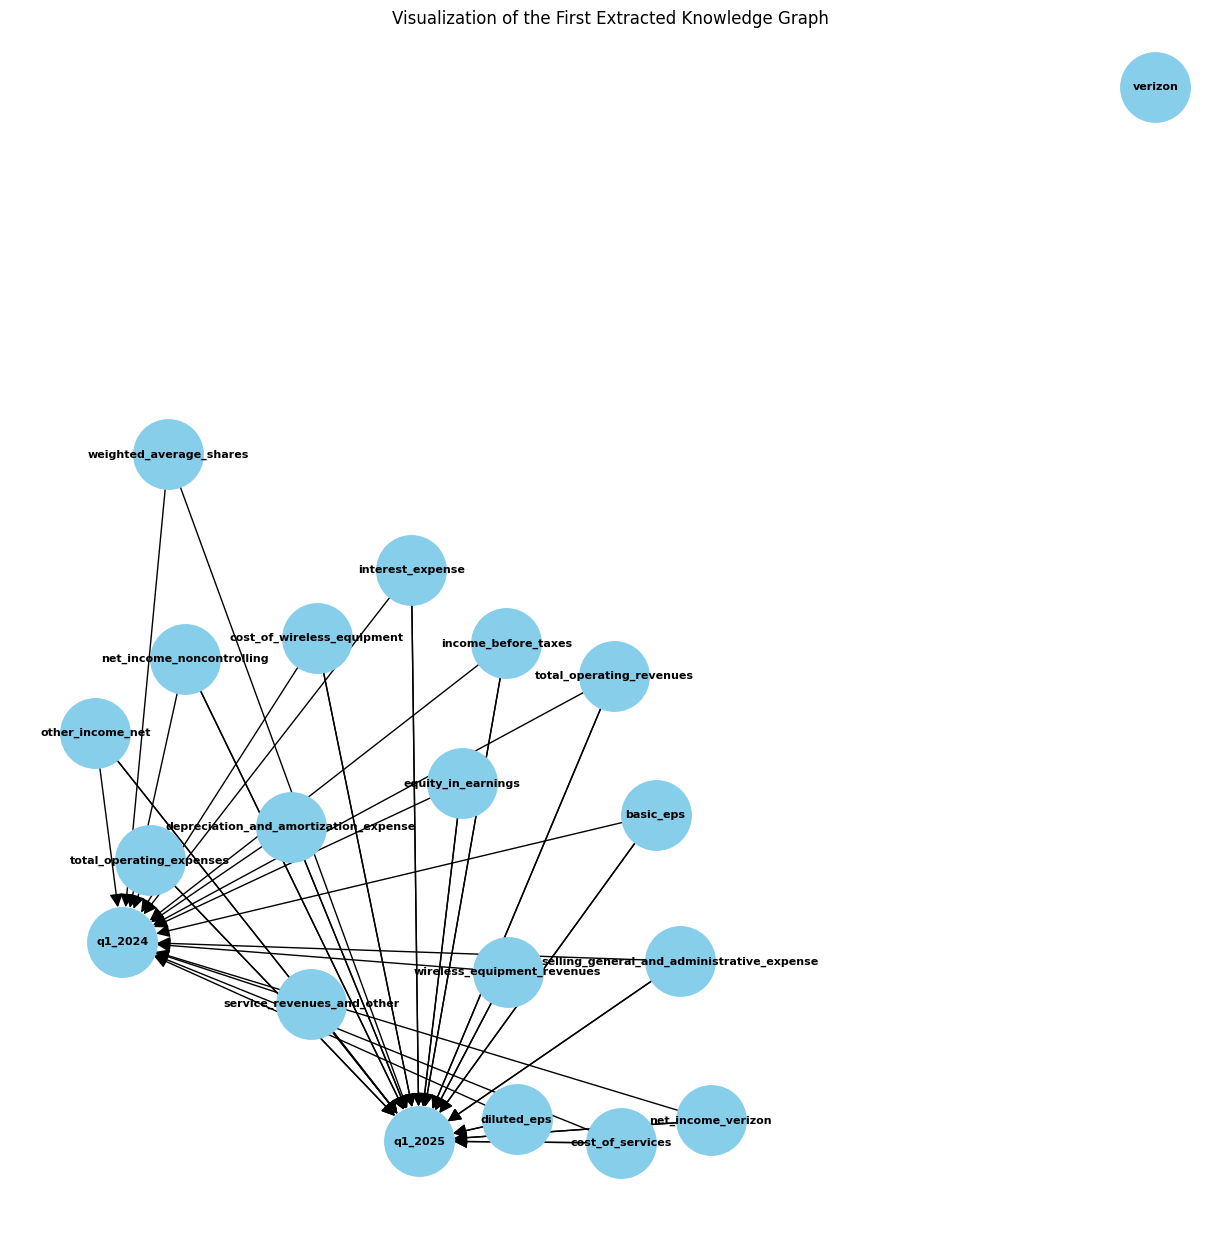

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

# --- 6. Build the Graph from Extracted Data ---

print("🏗️ Building graph with NetworkX...")
# Create a directed graph
G = nx.MultiDiGraph()

# Add nodes with their attributes (id, label, type)
for node in nodes:
    G.add_node(node['id'], label=node['label'], type=node['type'])

# Add relationships (edges) with their attributes
for rel in relationships:
    # Ensure all required keys exist before adding the edge
    if 'source' in rel and 'target' in rel and G.has_node(rel['source']) and G.has_node(rel['target']):
        G.add_edge(
            rel['source'], 
            rel['target'], 
            relation=rel.get('relation', 'N/A'), 
            properties=rel.get('properties', {})
        )
    else:
        print(f"⚠️  Skipping invalid edge: {rel}")

print(f"✅ Graph built successfully!")
print(f"   - Number of nodes: {G.number_of_nodes()}")
print(f"   - Number of edges: {G.number_of_edges()}")

# Optional: Visualize a small part of the graph to verify
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.9, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="skyblue", font_size=8, font_weight="bold", arrowsize=20)
plt.title("Visualization of the First Extracted Knowledge Graph")
plt.show()



---

### The Strategic Path Forward: Unifying and Refining the Graph

Now, let's address the bigger picture. How do we go from this single-table graph to a unified graph for the entire document set? This process involves three main phases.

#### Phase 1: Iterative Extraction and Collection

Your current process works for one table. The next step is to loop through all tables (and eventually other text sections) and collect the raw graph data from each.

1.  **Loop Through All Tables**: Wrap your existing logic (Table Reconstruction -> Graph Extraction) in a loop that iterates through the 11 tables `Docling` found in the document.
2.  **Store Raw Results**: For each table, run the extraction and store the resulting `nodes` and `relationships` lists. The output of this phase will be a list of graph data structures, e.g., `[graph_data_table1, graph_data_table2, ...]`.

#### Phase 2: Merging into a Unified Graph

This phase combines all the individual graph pieces into one large graph, focusing on avoiding duplicates.

1.  **Create a Master Graph**: Initialize a single, empty `networkx.DiGraph()`.
2.  **Merge with Deduplication**: Loop through the collected results from Phase 1. For each `node` and `relationship`:
    *   **Nodes**: Before adding a node, check if a node with the same `id` already exists in the master graph (`if not master_graph.has_node(node['id']):`). This is crucial. A concept like `"Q1 2025"` should be a single node, not 11 separate ones.
    *   **Edges**: Add the relationships directly. Since they connect specific entities (e.g., a metric from Table 3 to a time period), they are unique facts and won't be duplicates.

#### Phase 3: Schema Refinement and Normalization (The Most Important Step)

This is where you make the graph truly intelligent and reliable. The goal is to standardize the vocabulary (the schema) of your graph. The LLM might use slightly different terms for the same thing across different runs (e.g., "S,G,&A Expense" vs. "Selling, General and Administrative Expense").

1.  **Discover the "Raw" Schema**: After merging, get a unique set of all node types, labels, and relationship types from your master graph.
    ```python
    all_node_types = set(nx.get_node_attributes(master_graph, 'type').values())
    all_relation_types = set(nx.get_edge_attributes(master_graph, 'relation').values())
    ```
2.  **Define a Canonical Schema (The "Golden Record")**: This is your target schema. You can define it manually or use an LLM to help you.
    *   **LLM-Assisted Normalization**: Create a "Schema Refinement Agent". Give it the raw lists of types and labels you discovered and ask it to normalize them.
        *   **Prompt**: *"You are a data architect. Given this list of node labels: `['S,G,&A Expense', 'Selling, General and Administrative Expense', 'SG&A']`, consolidate them into a single canonical label. Provide the mapping in JSON format: `{'S,G,&A Expense': 'Selling, General and Administrative Expense', 'SG&A': 'Selling, General and Administrative Expense'}`."*
3.  **Apply the Canonical Schema**: Use the mapping generated in the previous step to update your master graph. Iterate through all nodes and edges and update their `type`, `label`, and `relation` attributes to match the canonical version. This ensures consistency.

This three-phase process will take you from raw, disconnected extractions to a clean, unified, and queryable knowledge graph that represents the entire document's financial information.

##### 3) Finance Normalization (scale/currency/period → canonical KG)

In [ ]:
import os, re, json, networkx as nx
from dataclasses import dataclass
from typing import List, Dict, Any, Optional

SCALE_PATTERNS = [
    r"\(?(?:amounts|dollars|figures)\s+in\s+(millions|billions|thousands)\)?",
    r"\(\$?\s?in\s+(millions|billions|thousands)\)",
    r"(?:usd|us\$|\$)\s*(?:in)?\s*(millions|billions|thousands)"
]
PERIOD_PATTERNS = [
    r"\b([1-4]q)\s*(\d{4})\b", r"\bfy\s*(\d{4})\b", r"\b(\d{4})\b"
]
NUM_RE = re.compile(r"[-+()]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|[-+()]?\d+(?:\.\d+)?")

def detect_scale(text: str) -> Optional[float]:
    t = text.lower()
    for p in SCALE_PATTERNS:
        m = re.search(p, t)
        if m:
            v = (m.group(1) or "").lower()
            if v.startswith("million"): return 1_000_000.0
            if v.startswith("billion"): return 1_000_000_000.0
            if v.startswith("thousand"): return 1_000.0
    return None

def detect_period(text: str) -> Optional[str]:
    t = text.lower()
    for p in PERIOD_PATTERNS:
        m = re.search(p, t)
        if m: return m.group(0).upper().replace(" ","")
    return None

def parse_number(cell: str) -> Optional[float]:
    m = NUM_RE.search(cell.replace("\u2212","-"))
    if not m: return None
    s = m.group(0).replace(",","")
    neg = s.startswith("(") and s.endswith(")")
    s = s.strip("()")
    try:
        v = float(s)
        return -v if neg else v
    except: return None

def normalize_triples_to_observations(raw_triples_path: str, chunks_jsonl_path: str) -> List[Dict[str, Any]]:
    # load triples and chunk meta
    triples=[]; 
    with open(raw_triples_path,"r",encoding="utf-8") as f:
        for line in f:
            try: triples.append(json.loads(line))
            except: pass
    chunk_meta={}
    with open(chunks_jsonl_path,"r",encoding="utf-8") as f:
        for line in f:
            try:
                rec = json.loads(line); chunk_meta[rec["id"]]=rec
            except: pass
    obs=[]
    for t in triples:
        prov = t.get("provenance", {})
        ch = chunk_meta.get(prov.get("chunk_id"), {})
        ctx = " ".join([str(x) for x in (ch.get("section_path") or [])])+" "+(ch.get("text","")[:400])
        scale = detect_scale(ch.get("text",""))
        period = detect_period(ch.get("text","")) or detect_period(" ".join(ch.get("section_path") or []))
        # if object looks numeric → value observation
        obj = t.get("object","")
        val = parse_number(obj)
        if val is None:
            continue
        factor = scale or 1.0
        obs.append({
            "company": "Verizon",
            "metric": t.get("predicate"),
            "period": period,
            "value": val * factor,
            "currency": "USD",
            "scale_factor": factor,
            "provenance": prov
        })
    return obs

def build_canonical_graph(observations: List[Dict[str, Any]]) -> nx.MultiDiGraph:
    G = nx.MultiDiGraph()
    G.add_node("Company::Verizon", type="Company", name="Verizon")
    for o in observations:
        metric_node = f"Metric::{o['metric']}"
        period_node = f"Period::{o['period'] or 'Unknown'}"
        value_node = f"Value::{o['metric']}::{o.get('period') or 'Unknown'}::{o['value']}"
        G.add_node(metric_node, type="Metric", name=o["metric"])
        G.add_node(period_node, type="Period", label=o.get("period") or "Unknown")
        G.add_node(value_node, type="Value", amount=o["value"], currency=o["currency"], scale=o["scale_factor"], provenance=o["provenance"])
        G.add_edge("Company::Verizon", metric_node, type="hasMetric")
        G.add_edge(metric_node, period_node, type="forPeriod")
        G.add_edge(period_node, value_node, type="hasValue")
    return G

def save_graph(G: nx.MultiDiGraph, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    import json as _json
    nx.write_gpickle(G, os.path.join(out_dir,"finance_kg.pkl"))
    # GraphML-safe
    G2 = nx.MultiDiGraph(); G2.add_nodes_from(G.nodes(data=True))
    for u,v,k,d in G.edges(keys=True, data=True):
        dd={k2: (_json.dumps(vv) if isinstance(vv,(dict,list)) else vv) for k2,vv in d.items()}
        G2.add_edge(u,v,key=k,**dd)
    nx.write_graphml(G2, os.path.join(out_dir,"finance_kg.graphml"))

In [ ]:
ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
PARSED = os.path.join(ROOT, "output", "parsed_pdfs")
KG_OUT = os.path.join(ROOT, "output", "kg")

def main():
    for folder, _, files in os.walk(PARSED):
        if "raw_triples.jsonl" in files and any(f.endswith(".chunks.jsonl") for f in files):
            triples_path = os.path.join(folder,"raw_triples.jsonl")
            chunks_path = [os.path.join(folder, f) for f in files if f.endswith(".chunks.jsonl")][0]
            obs = normalize_triples_to_observations(triples_path, chunks_path)
            G = build_canonical_graph(obs)
            save_graph(G, KG_OUT)
            print("KG saved:", KG_OUT)
            break

##### 4) Schema Refinement (relation canonicalization, entity type induction, taxonomy/ontology, resolution)

In [ ]:
import os, json
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass

from sentence_transformers import SentenceTransformer
import hdbscan
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from rapidfuzz import fuzz

@dataclass
class RefineConfig:
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    ollama_model: str = "llama3.1"
    min_cluster_size: int = 5

def _embed(texts: List[str], model_name: str):
    emb = SentenceTransformer(model_name)
    return emb.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

def cluster_and_label(items: List[str], cfg: RefineConfig) -> Dict[str, str]:
    if not items: return {}
    X = _embed(items, cfg.model_name)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cfg.min_cluster_size, metric="euclidean")
    labels = clusterer.fit_predict(X)
    groups: Dict[int, List[str]] = {}
    for s,l in zip(items, labels):
        if l==-1: continue
        groups.setdefault(int(l), []).append(s)
    llm = ChatOllama(model=cfg.ollama_model, temperature=0)
    mapping={}
    for cid, samples in groups.items():
        prompt = ChatPromptTemplate.from_messages([
            ("system","Given relation phrases, name a concise canonical predicate (snake_case). Return only the name."),
            ("human","Samples:\n{samples}")
        ])
        name = llm.invoke(prompt.format_messages(samples="\n".join(list(set(samples))[:20]))).content.strip()
        for s in samples: mapping[s]=name
    return mapping

def canonicalize_relations(raw_triples_path: str, cfg: RefineConfig) -> Dict[str,str]:
    rels=[]
    with open(raw_triples_path,"r",encoding="utf-8") as f:
        for line in f:
            try: rels.append(json.loads(line).get("predicate",""))
            except: pass
    rels=[r for r in rels if r]
    return cluster_and_label(rels, cfg)

def infer_entity_types(entity_mentions_path: str, cfg: RefineConfig) -> Dict[str,str]:
    names=[]
    with open(entity_mentions_path,"r",encoding="utf-8") as f:
        for line in f:
            try: names.append(json.loads(line).get("entity",""))
            except: pass
    names=[n for n in names if n]
    return cluster_and_label(names, cfg)

def dedupe_entities(entity_mentions_path: str, threshold: int = 90) -> Dict[str,str]:
    # simple fuzzy-based dedupe map: alias -> canonical
    items=[]
    with open(entity_mentions_path,"r",encoding="utf-8") as f:
        for line in f:
            try: items.append(json.loads(line).get("entity",""))
            except: pass
    items=list(sorted(set([i for i in items if i])))
    mapping={}
    canon=[]
    for s in items:
        found=False
        for c in canon:
            if fuzz.WRatio(s,c)>=threshold:
                mapping[s]=c; found=True; break
        if not found:
            canon.append(s); mapping[s]=s
    return mapping

def induce_taxonomy(types: List[str], cfg: RefineConfig) -> Dict[str, Any]:
    if not types: return {}
    llm = ChatOllama(model=cfg.ollama_model, temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system","Build a simple taxonomy tree (JSON) with subClassOf relations for these types."),
        ("human","Types:\n{types}")
    ])
    resp = llm.invoke(prompt.format_messages(types="\n".join(sorted(set(types))))).content
    try: return json.loads(resp)
    except: return {"types": list(sorted(set(types))), "note":"LLM taxonomy parse failed"}

In [ ]:
ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
PARSED = os.path.join(ROOT, "output", "parsed_pdfs")
OUT = os.path.join(ROOT, "output", "refinement"); os.makedirs(OUT, exist_ok=True)

def main():
    cfg = RefineConfig()
    # take first doc's outputs
    targets=[]
    for folder, _, files in os.walk(PARSED):
        if "raw_triples.jsonl" in files and "raw_entities.jsonl" in files:
            targets.append((os.path.join(folder,"raw_triples.jsonl"), os.path.join(folder,"raw_entities.jsonl")))
    if not targets: 
        print("No raw triples/entities found"); return
    rel_map = canonicalize_relations(targets[0][0], cfg)
    ent_types = infer_entity_types(targets[0][1], cfg)
    dedupe_map = dedupe_entities(targets[0][1])
    tax = induce_taxonomy(list(set(ent_types.values())), cfg)
    with open(os.path.join(OUT,"relation_map.json"),"w",encoding="utf-8") as f: json.dump(rel_map, f, indent=2)
    with open(os.path.join(OUT,"entity_types.json"),"w",encoding="utf-8") as f: json.dump(ent_types, f, indent=2)
    with open(os.path.join(OUT,"dedupe_map.json"),"w",encoding="utf-8") as f: json.dump(dedupe_map, f, indent=2)
    with open(os.path.join(OUT,"taxonomy.json"),"w",encoding="utf-8") as f: json.dump(tax, f, indent=2)
    print("Refinement artifacts in", OUT)

In [ ]:
ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
PARSED = os.path.join(ROOT, "output", "parsed_pdfs")
CHROMA_DIR = os.path.join(ROOT, "vector_db", "pdf_chunks")

def main():
    chunks = glob.glob(os.path.join(PARSED, "**", "*.chunks.jsonl"), recursive=True)
    print("Chunks:", len(chunks))
    info = build_chroma_index(chunks, CHROMA_DIR)
    print("Indexed:", info)


##### 5) Storage & Indexes (NetworkX, exports; Chroma)

In [ ]:
import os, glob
# from pdf_ingestion.ingest import IngestConfig, run_ingest

ROOT = r"i:\My Drive\M. Tech AI ML\AIML SEM 4\Dissertation\Project"
Q1_2025 = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\downloaded_verizon_quarterly_pdfs\2025\1Q")
ANNUAL = os.path.join(ROOT, r"downloaded_verizon_financial_pdfs\Yearly_Financial_Report")
OUT = os.path.join(ROOT, "output", "parsed_pdfs")

SAMPLES = [
    os.path.join(Q1_2025, "Download Financial & Operating information PDF_3dedf514.pdf"),
    os.path.join(ANNUAL, "View 2024 Annual Report on Form 10-K (PDF)_475d787c.pdf"),
    os.path.join(ANNUAL, "View 2023 Annual Report on Form 10-K (PDF)_6364211c.pdf"),
]

def main():
    cfg = IngestConfig(out_dir=OUT, page_limit=None, prefer_docling_text=True)
    for pdf in SAMPLES:
        if not os.path.exists(pdf): print("SKIP:", pdf); continue
        print("Ingest:", pdf)
        print(run_ingest(pdf, cfg))

if __name__=="__main__": main()